# Boston University Spring 2022 CS523: Deep Learning

## Learned Skills and Projects

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yzhang37/Extras/blob/main/Fall2022_Deep_Learning_Projects.ipynb)

Student Name: `Zhenghang Yin`

BUID: `U82871437`

Lecturer: [Brian Kulis](https://people.bu.edu/bkulis/), [Kate Saenko](http://ai.bu.edu/ksaenko.html)


---

**Table of Contents**

This following files show:

1. **(Convoluation Neural Network)** [Train a CNN model](#proj_1)

2. **(Pytorch)** [Save/restore and fine-tune with model weights](#proj_2)

3. **(Style Transfer)** [Neural style transfer learning](#proj_3)

4. **(Algorithms)** [Understanding Spurious Bias and its impact on Model Performance](#proj_4)

5. **(Algorithms)** [Implementing Domain-Independance: A method to mitigate Spurious Bias](#proj_5)

6. **(GAN)** [Introduce Generative Adversarial Learning building blocks (GAN)](#proj_6)

7. **(GAN)** [Use GAN to change hairstyles of popular celebrities available in the CelebA dataset](#proj_7)

8. **(Reinforcement Learning)** [Deep Reinforcement Learning with DQN and DDPG](#proj_8)

9. **(Transformers)** [Understanding the basic structure of Transformers](#proj_9)

---


# 1. Convolutional Networks (40 points) <a id="proj_1"></a>

In this part, we will experiment with CNNs in PyTorch. You will need to read the documentation of the functions provided below to understand how they work.

**GPU Training.** Smaller networks will train fine on a CPU, but you may want to use GPU training for this part of the homework. You can run your experiments on Colab's GPUs or on BU's  [Shared Computing Cluster (SCC)](http://www.bu.edu/tech/services/research/computation/scc/). You may find this SCC tutorial helpful: [SCC tutorial](http://rcs.bu.edu/classes/CS542/SC542.html). To get access to a GPU on Colab, go to `Edit->Notebook Settings` in the notebook and set the hardware accelerator to "GPU".

## 1.1 Training a CNN on SVHN

In last homework, we implemented a 2-layer MLP network on the [SVHN Dataset](http://ufldl.stanford.edu/housenumbers/).

The SVHN dataset consists of photos of house numbers, collected automatically using Google's Street View. Recognizing multi-digit numbers in photographs captured at street level is an important component of modern-day map making. Google’s Street View imagery contains hundreds of millions of geo-located 360 degree panoramic images. The ability to automatically transcribe an address number from a geo-located patch of pixels and associate the transcribed number with a known street address helps pinpoint, with a high degree of accuracy, the location of the building it represents. Below are example images from the dataset. Note that for this dataset, each image (32x32 pixels) has been cropped around a single number in its center, which is the number we want to classify.


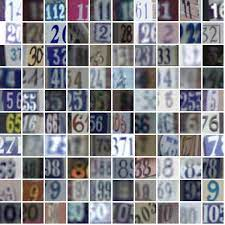

In this homework, we will create and train a convolutional network (CNN) on the [SVHN Dataset](http://ufldl.stanford.edu/housenumbers/).

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import typing
from tqdm.notebook import tqdm

### 1.1.0 Data Download
First, download the SVHN dataset using `torchvision` and display the RGB images in the first batch. Take a look at the [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) tutorial for an example. Follow the settings used there, such as the normalization, batch size of 4 for the `torch.utils.data.DataLoader`, etc.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                        transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.SVHN(root='./data', split='test',
                                        transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

    1     3     1     3


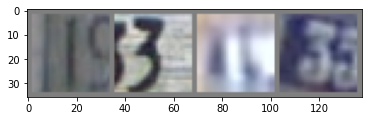

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 1.1.1 CNN Model
Next, we will train a CNN on the data. We have defined a simple CNN for you with two convolutional layers and two fully-connected layers below.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # define the first layer of Convlution
        self.conv1 = nn.Conv2d(3, 6, 5)
        # the first max-pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # define the second layer of Convlution
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)   # flatten features

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Instantiate the cross-entropy loss `criterion`, and an SGD optimizer from the `torch.optim` package with learning rate $.001$ and momentum $.9$. You may also want to enable GPU training using `torch.device()`.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
criterion = nn.CrossEntropyLoss()

### 1.1.2 Training
Write the training loop that makes two full passes through the dataset (two epochs) using SGD. Your batch size should be 4.

Go slack off for a while...

![reddit xkcd comic](https://i.redd.it/5cjdqxcg07k11.png)

In [ ]:
import pdb

# 对同一组数据集进行多次计算 / epochs
# loop over the dataset multiple times
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()
        
        # 获取数据并转换成 GPU
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 计算网络转换
        outputs = net(inputs)

        # 计算损失值
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        # print statistics / 打印统计信息
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.244
[1,  4000] loss: 2.231
[1,  6000] loss: 1.974
[1,  8000] loss: 1.012
[1, 10000] loss: 0.787
[1, 12000] loss: 0.662
[1, 14000] loss: 0.608
[1, 16000] loss: 0.596
[1, 18000] loss: 0.565
[2,  2000] loss: 0.501
[2,  4000] loss: 0.500
[2,  6000] loss: 0.499
[2,  8000] loss: 0.493
[2, 10000] loss: 0.477
[2, 12000] loss: 0.475
[2, 14000] loss: 0.440
[2, 16000] loss: 0.460
[2, 18000] loss: 0.441
Finished Training


### 1.1.3 Test Accuracy
Load the test data (don't forget to move it to GPU if using). Make predictions on it using the trained network and compute the accuracy. You should see an accuracy of above 80%.

In [ ]:
def test_on_SVHN(net, testloader):
    all_corrects = 0
    all_wrongs = 0

    with torch.no_grad():
        for i, data in enumerate(testloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            # 将输入转换为最大类标
            output_labels = torch.argmax(outputs, dim=1)

            correct = (torch.sum(output_labels == labels)).cpu().numpy().item()
            wrong = (torch.sum(output_labels != labels)).cpu().numpy().item()

            all_corrects += correct
            all_wrongs += wrong

    return all_corrects / (all_corrects + all_wrongs)

acc = test_on_SVHN(net, testloader)
print('Accuracy of the network on the 10000 test images: %.1f %%' % (acc * 100))

Accuracy of the network on the 10000 test images: 84.0 %



## 1.2. Understanding the CNN Architecture

Explain the definition of the following terms. What is the corresponding setting in our SVHN net? Are there any other choices?

- Stride

	The interval we move our filter against pixels.

	Corresponding setting: In both two convolution layer, the stride is 1. In pooling layer, it's 2.

- Padding

	Because of the filter and the boundary, the final shape will become **Input Size** - **Filter Size** + 1. To fix the problem of size mismatch, we can manually create 0 surrounding the original input. This is called **Padding**.

	Corresponding setting: There are no padding settings in the current network configuration.

- Non-linearity

	Convolutional neural network is different from the traditional full connection layer, it does not have linear properties.

	Corresponding setting: Using the Convolutional layer.

- Pooling

	Pooling reduce the spatial resolution of each feature, to decrease the variance of shift and distortion to some extent.

	Corresponding setting: A pooling layer, with $2 \times 2$ size kernel and stride = 2.

- Loss function

	The Loss function defines the metric between the predicted value and the actual value.

	Corresponding setting: **Cross Entropy Loss**

- Optimizer

	Corresponding setting: **Stochastic Gradient Descent**

- Learning rate

	Corresponding setting: $0.001$

- Momentum

	Corresponding setting: $0.9$


## 1.3. Improving SVHN accuracy

We will now vary the architecture and training hyper-parameters of the network to try and achieve a higher accuracy on the SVHN dataset. Note that human performance on this dataset achieves around a 2% error, as reported in

- *Convolutional Neural Networks Applied to House Numbers Digit Classification*,
Pierre Sermanet, Soumith Chintala, Yann LeCun [ [pdf](https://arxiv.org/pdf/1204.3968.pdf) ]

You may want to read the above paper, as it provides the first exploration of deep learning for this problem. It is possible to achieve an error of less than 2% with modern deep learning methods, see for example this paper:
- *Batch-normalized Maxout Network in Network*, by Chang and Chen
[ [pdf](https://arxiv.org/pdf/1511.02583.pdf) ]

We do not expect you to achieve such results, but you should be able to improve on the initial accuracy we got and increase it to above 90%. It is more important that you try varying different architecture and training settings to understand how they affect (or not) the results.



### 1.3.1 Architecture 
First, try to vary the structure of the network. For example, you can still use  two  convolutional layers, but vary their parameters. You can also try adding more convolutional, pooling and/or fully-connected (FC) layers.

Keep careful track of performance as a function of architecture changes using a table or a plot. For example, you can report the final test accuracy on 3 different numbers of channels (filters), 3 different sizes of kernels, 3 different strides, and 3 different dimensions of the final fully connected layer, using a table like the one below. Each time when you vary one parameter, you should **keep the others fixed at the original value**. 

Explain your results. Note, you're welcome to decide how many training epochs to use, but do report the number you used and keep it the same for all architecture changes (as well as other training hyper-parameters). Be careful not to change more than one thing between training/test runs, otherwise you will not know which of the multiple changes caused the results to change.

**Please implement your experiments in a separate cell, DO NOT change your codes in Q1.1 for this question. During submission, you are Not required to submit any code for this question.**

#### helper functions

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


def test_on_SVHN(net, testloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    all_corrects = 0
    all_wrongs = 0

    with torch.no_grad():
        for i, data in enumerate(testloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            # 将输入转换为最大类标
            output_labels = torch.argmax(outputs, dim=1)

            correct = (torch.sum(output_labels == labels)).cpu().numpy().item()
            wrong = (torch.sum(output_labels != labels)).cpu().numpy().item()

            all_corrects += correct
            all_wrongs += wrong

    return all_corrects / (all_corrects + all_wrongs)

# utility to get a new Net
def newNet(net_cls: type):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    new_net = net_cls()
    new_net = new_net.to(device)
    return new_net

def trainNet(the_net: nn.Module, loss_fn, optimizer, epochs: int=2,
             plot_int: int=2000):
    from matplotlib import pyplot as plt
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    batch_split_count = 0
    data_count = 0
    loss_stats = []

    # loop over the dataset multiple times
    for epo_i, epoch in enumerate(tqdm(range(epochs), unit='epochs')):
        loss_stat = []

        tqdm2 = tqdm(desc=f"Epoch {epo_i + 1}",
                     total=(data_count if data_count != 0 else None))
        for i, data in enumerate(trainloader, 0):
            optimizer.zero_grad()
            
            # 获取数据并转换成 GPU
            inputs, labels = data
            
            if epo_i == 0:
                data_count += len(labels)

            tqdm2.update(len(labels))

            inputs = inputs.to(device)
            labels = labels.to(device)

            # 计算网络转换
            outputs = the_net(inputs)

            # 计算损失值
            loss = loss_fn(outputs, labels)
            loss.backward()

            optimizer.step()

            # print statistics / 打印统计信息
            if epo_i == 0 and i % plot_int == 0:
                batch_split_count += 1
            if i % plot_int == 0:
                loss_stat.append(loss.item() / (trainloader.batch_size * plot_int))
    
        tqdm2.close()
        loss_stats.append(loss_stat)
    
    # draw the plot
    x = [x * plot_int for x in range(1, batch_split_count + 1, 1)]
    for epo_i, loss_stat in enumerate(loss_stats):
        plt.plot(x, loss_stat, label=f"Epoch {epo_i + 1}")
    plt.xlabel('progress')
    plt.ylabel('loss')
    plt.legend()


#### Testing on different networks

#### Change filter size

- Change the filter/channel # of the `Conv1`

| # of Filter | Accuracy        |
| ----------- | --------------- |
| 6 (Default) | 84% ~ 85.30%    |
| 9           | 85.00%          |
| 12          | 85.99%          |
| 16          | 85.66%          |
| 20          | 85.26% ~ 86.32% |
| 24          | 85.25% ~ 85.82% |
| 32          | 86.42% ~ 86.57% |
| 64          | 85.05% ~ 85.79% |
| 96          | 85.16% ~ 86.22% |
| 128         | 85.51% ~ 86.64% |


  **Conclusion:**

  When filter $\ge 12$ and $ \le 20$, it seems the result is better: approach 86%.

- Change the channels of the `Conv2` (epochs=1):

| `Conv1` filters | `Conv2` filters | Accuracy |
| --------------- | --------------- | -------- |
| 12              | 16              | 80.07 %  |
| 12              | 24              | 83.73 %  |
| 12              | 32              | 82.64 %  |
| 12              | 40              | 81.87 %  |
| 12              | 48              | 81.94 %  |
| 12              | 56              | 83.30 %  |
| 12              | 64              | 83.63 %  |
| 16              | 16              | 82.24 %  |
| 16              | 24              | 79.92 %  |
| 16              | 32              | 82.95 %  |
| 16              | 40              | 81.58 %  |
| 16              | 48              | 82.65 %  |
| 16              | 56              | 84.22 %  |
| 16              | 64              | 83.03 %  |
| 20              | 16              | 83.77 %  |
| 20              | 24              | 82.36 %  |
| 20              | 32              | 82.51 %  |
| 20              | 40              | 80.95 %  |
| 20              | 48              | 83.33 %  |
| 20              | 56              | 80.61 %  |
| 20              | 64              | 81.65 %  |



#### Changing kernel size

- Change the kernel size of the **1st** `ConvNet`

|Kernel Size|Accuracy|
|---|---|
|3|82.64 ~ 84.12 %|
|5 (Default)|84 % ~ 85.3 %|
|10|82.43 %|
|15|78.81 %|
|20|73.97 %|
	
**Conclusion**:

Enlarging the Kernel Size of the first `ConvNet` layer alone and maintaining the Kernel Size of the second `ConvNet` will cause serious performance degradation.


- Change the kernel size of the **2nd** `ConvNet`

|Kernel Size|Accuracy|
|---|---|
|3|85.30 % ~ 85.53 %|
|5 (Default)|84 % ~ 85.3 %|
|8|81.66 % ~ 82.82 %|
	
	
**Conclusion**:

Enlarging the Kernel Size of the second `ConvNet` will still degrade the performance. Shrinking the kernel size has not changed much.

- Change the kernel size of the **Both** `ConvNet`

|Kernel Size|Accuracy|
|---|---|
|3|82.91% ~ 83.44%|
|5 (Default)|84 % ~ 85.3 %|
|8|80.21% ~ 82.16%|
|10|81.49 %|
	
	
**Conclusion**:

Kernel Size cannot be too large. When it is too large, the required details may be lost, resulting in incorrect identification.

---

#### Changing stride size

- Change the stride of the 1st `ConvNet`

|Stride|Accuracy|
|---|---|
|1 (Default)|84 % ~ 85.3 %|
|2|76.85 % ~ 78.30 %|
|3|76.19 %|
	
	
- Change the stride of the Pooling Layer

|Stride|Accuracy|
|---|---|
|1|85.15 % ~ 85.37 %|
|2 (Default)|84 % ~ 85.3 %|
|3|78.56 % ~ 82.33 %|
	
	
- Change the stride of the 2nd `ConvNet`

|Stride|Accuracy|
|---|---|
|1 (Default)|84 % ~ 85.3 %|
|2|85.3 %|
|3|80.21% ~ 82.16%|
	
	

**Conclusion:**

Just increasing the size of Stride usually makes the network unable to capture effective information, resulting in a decrease in Accuracy.

#### Changing Size of the final FC layer

|FC size|Accuracy|
|---|---|
|16|84.39 % ~ 85.27 %|
|24|84.73 % ~ 85.78 %|
|32 (Default)|84 % ~ 85.3 %|
|48|84.36 % ~ 84.60 %|
|96|84.81 % ~ 85.82 %|

**Conclusion:**

Modifying the feature number of the last FC layer doesn't have great influence on the result.

### 1.3.2 Training Hyper-Parameters

Repeat the process for training hyper-parameters, exploring at least three of the following:
- training iterations, optionally with early stopping
- learning rate
- momentum
- optimizer
- initialization
- dropout
- batch normalization
- dataset augmentation

Document your results with tables or figures, and explain what happened. You may want to use Tensorboard (see Problem 2 below) but this is optional.

What is the best accuracy you were able to achieve on the test set, and which factors contributed the most to the improvement? (A good result should be above 85%.)

**Please implement your experiments in a separate cell, DO NOT change your codes in Q1.1 for this question. During submission, you are Not required to submit any code for this question.**


#### Add epochs and early stopping

| Epochs | Accuracy |
| ------ | -------- |
| 2 （Default) | 85.39 %  |
| 3      | 86.83 %  |
| 4      | 87.23 %  |
| 5      | 87.73 %  |
| 6      | 86.98 %  |
| 7      | 87.69 %  |
| 8      | 87.20 %  |
| 9      | 87.53 %  |
| 10     | 88.13 %  |

![2](https://drive.google.com/uc?id=1_RGXb6WhGSTW3frAeNyLJzYZywAHbSm4)

#### Set learning rate

| Learning rate   | Accuracy |
| --------------- | -------- |
| 0.0001          | 19.58 %  |
| 0.0005          | 85.23 %  |
| 0.001 (Default) | 85.39 %  |
| 0.0015          | 84.93 %  |
| 0.002           | 82.84 %  |

#### Set momentum

| Momentum      | Accuracy |
| ------------- | -------- |
| 0.05          | 74.47 %  |
| 0.7           | 80.14 %  |
| 0.9 (Default) | 85.39 %  |
| 1.1           | 6.69 %  |

Final training result:

I tried `Conv1.Channels` = 16, `Conv2.Channels` = 64
and `(16, 56)`, `(16, 64)`, and `(20, 48)`, with epochs = 10.

The final training result accuracies are all around 88%.

![12_64](https://drive.google.com/uc?id=1GLCq7VjRyMN3EgMx8kCOo_pYKZZ5WahQ)

![16_56](https://drive.google.com/uc?id=13c60F4h0_jlVmX4FIKXZTrgqQrETcGsH)

![16_64](https://drive.google.com/uc?id=1Are4Oc_MVknnCdtw4RygM6JbZWWy5fft)

![20_48](https://drive.google.com/uc?id=1VPDRi9eF6h21LPK68ZaoHzZ98r4i0prb)

The final best result is (16, 56), with epochs = 10.

Accuracies is 89%.

### 1.3.3 The power of CNN

Compare to the results you got from HW2 Q4.6.3, which model learns better on image dataset - MLP or CNN? Explain it.

Hint: You can discuss on accuracy, runtime, number of parameters, etc.

The effect of CNN is far better than that of MLP.

- First of all, because CNN uses the convolution method for calculation, all convolution calculations can be performed in parallel in each calculation. However, Full-Connected networks do not and must be calculated sequentially. So the speed is slightly lower than CNN.

- Second, because of the use of the principles of Pooling and convolution, CNN can better deal with the scaling problems of Distortion and Scale than MLP.


---

# 2: Save and restore model weights (30 points) <a name="proj_2"></a>

In this section you will learn to save the weights of a trained model, and to load the weights of a saved model. This is really useful when we would like to load an already trained model in order to continue training or to fine-tune it. Often times we save “snapshots” of the trained model as training progresses in case the training is interrupted, or in case we would like to fall back to an earlier model, this is called snapshot saving.


## 2.1 Saving and Loading Weights
In this section you will learn how to [save and load pytorch models for inference](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference).

### 2.1.1 State_dict
In PyTorch, the learnable parameters (i.e. weights and biases) of an torch.nn.Module model are contained in the model’s parameters (accessed with model.parameters()). A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor. Because state_dict objects are Python dictionaries, they can be easily saved, updated, altered, and restored, adding a great deal of modularity to PyTorch models and optimizers.

Print out the keys of state_dict of the model you trained in Q1.1.4. (Note state_dict is a property of the module object.)

In [ ]:
print(net.state_dict)

<bound method Module.state_dict of Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)>


### 2.1.2 Save state_dict

Save the state_dict of the model in Q1.1.4 with the torch.save() function to a local path.

In [ ]:
def DPATH(path: str) -> str:
    from os.path import join
    return join("/content/drive/MyDrive/Users/青椒/CS523/hw3_stuffs", path)

In [ ]:
torch.save(net.state_dict(), DPATH("Net1.pt"))

### 2.1.3 Load state_dict

Now let's initiate net2 which has the same structure, and load the weights you saved to net2 by using load_state_dict().

In [ ]:
net2 = Net()

net2.load_state_dict(torch.load(DPATH("Net1.pt")))
net2 = net2.to(device)

<All keys matched successfully>

Test net2's performance on SVHN.

In [ ]:
acc = test_on_SVHN(net2)
print('Accuracy of the net2 on the 10000 test images: %.1f %%' % (acc * 100))

Accuracy of the net2 on the 10000 test images: 84.8 %


## 2.2 Fine-tune  a pre-trained model on CIFAR-10

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) is another popular benchmark for image classification.

![cifar10_teaser](https://drive.google.com/uc?id=1V8NbwIsBDsYsAiMcm68DAG6VbGHyCxEM)

### 2.2.0 Data Download
Similar to Q1.1.2, download the CIFAR-10 dataset using `torchvision` and display the RGB images in the first batch. 

Files already downloaded and verified
Files already downloaded and verified
    9     5     5     0


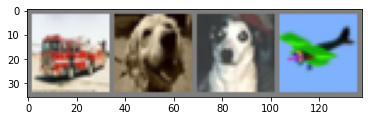

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

cifar10_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        transform=transform, download=True)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
cifar10_testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        transform=transform, download=True)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# get some random training images
cifar10_dataiter = iter(cifar10_trainloader)
images, labels = cifar10_dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].numpy() for j in range(4)))

### 2.2.1 Load state_dict partially

Let's define net_cifar = Net(), and only load selected weights in selected_layers. 

In [ ]:
def load_selected_state_dict(module: nn.Module, state_dict, selected_layers: list):
    from torch.nn import Parameter

    own_state = module.state_dict()
    for name, param in state_dict.items():
        if name not in own_state or name not in selected_layers:
            continue
        if isinstance(param, Parameter):
            # backwards compatibility for serialized parameters
            param = param.data
        own_state[name].copy_(param)

In [ ]:
net_cifar = Net()
selected_layers = ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias']

load_selected_state_dict(net_cifar, torch.load(DPATH("Net1.pt")), selected_layers)

In [ ]:
print(np.array_equal(net_cifar.state_dict()['conv1.weight'].numpy(), net.cpu().state_dict()['conv1.weight'].numpy()))
print(np.array_equal(net_cifar.state_dict()['fc3.weight'].numpy(), net.cpu().state_dict()['fc3.weight'].numpy()))

True
False


### 2.2.2 Fine-tune net_cifar on CIFAR-10

Fine-tune the net_cifar on CIFAR-10 (you need to train and test the accuracy of net_cifar on CIFAR10 test set instead of on SVHN test set), and show the plot of training loss.

In [ ]:
# before fine-tuning:

net_cifar = net_cifar.to(device)
print(f"Acc: {test_on_SVHN(net_cifar, cifar10_testloader) * 100}%")

Acc: 10.59%


  0%|          | 0/2 [00:00<?, ?epochs/s]

Epoch 1: 0it [00:00, ?it/s]

Epoch 2:   0%|          | 0/50000 [00:00<?, ?it/s]

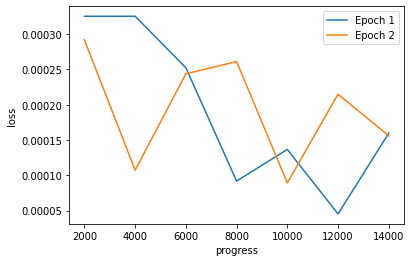

In [ ]:
net_cifar = net_cifar.to(device)
optimizer = optim.SGD(net_cifar.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
trainNet(cifar10_trainloader, net_cifar, criterion, optimizer)

In [ ]:
# after fine-tuning:
print(f"Acc: {test_on_SVHN(net_cifar, cifar10_testloader) * 100}%")

Acc: 54.21%



---

# 3: Neural style transfer (30 points)

In this problem, we will use deep learning to compose one image in the style of another image. This is known as [neural style transfer](https://towardsdatascience.com/a-brief-introduction-to-neural-style-transfer-d05d0403901d) and the technique is outlined in paper [A Neural Algorithm of Artistic Style (Gatys et al.)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf). Please read the paper before you proceed with Problem 4.

Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

![inputs](https://www.tensorflow.org/tutorials/generative/style_transfer_files/output__UWQmeEaiKkP_0.png)
![output](https://www.tensorflow.org/tutorials/generative/style_transfer_files/output_iYSLexgRKSh-_0.png)

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

## 3.0 Visualize the inputs

We provide two images, starry.jpg and golden.jpg, for style and content input respectively. To save runtime, we downscale the images to (128,128). You are welcome to play with your own inputs at any resolution scale (note a larger resolution requires more runtime). To upload files to your colab notebook, you can click on  `files` on the left side of your notebook then choose upload.

In [ ]:
from torch.cuda import is_available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = (512, 512) if torch.cuda.is_available() else (128,128) 

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

from torchvision.utils import save_image
def img_save(img, path: str):
    save_image(img, path)

style_img = image_loader(DPATH("starry.jpg"))
content_img = image_loader(DPATH("golden.jpg"))

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

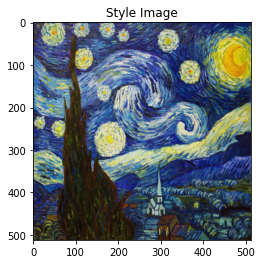

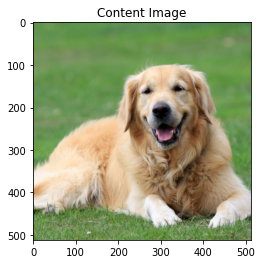

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## 3.1 Loss functions

The cost function has two terms - a content loss term and a style loss term, both of which are explained below.


### 3.1.1 Content Loss

The content of an image is represented by the values of the intermediate feature maps.  This is based on the intuition that images with similar content will have similar representation in the higher layers of the network. Let $p$ and $x$ be the original image and the image that is generated,

$$
\mathcal{L}_{\text {content }}(\vec{p}, \vec{x}, l)=\frac{1}{2} \sum_{i, j}\left(F_{i j}^{l}-P_{i j}^{l}\right)^{2}
$$

where $P^l$ is the representation of the original image and $F^l$ is the representation of the generated image in the feature maps of layer $l$.

Finish the ContentLoss() to match the corresponding content target representations. (hint: You can implement the ContentLoss using pytorch buildin `mse_loss()`)

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):       
        self.loss = F.mse_loss(input, self.target)
        return input


### 3.1.2 Style Loss

The style loss is implemented similarly to the content loss. It will act as a transparent layer in a network that computes the style loss of that layer. In order to calculate the style loss, we need to compute the gram matrix. A gram matrix is the result of multiplying a given matrix by its transposed matrix. 

$$
G_{i j}^{l}=\sum_{k} F_{i k}^{l} F_{j k}^{l}
$$


Let $~a$ and $~x$ be the original image and the image that is generated, 

$$
E_{l}=\frac{1}{4 N_{l}^{2} M_{l}^{2}} \sum_{i, j}\left(G_{i j}^{l}-A_{i j}^{l}\right)^{2}\\\mathcal{L}_{\text {style }}(\vec{a}, \vec{x})=\sum_{l=0}^{L} w_{l} E_{l}
$$

Here, $A^l$ is the representation of the original image and $G^l$ is the representation of the generated image in layer $l$. $N_l$ is the number of feature maps and $M_l$ is the size of the flattened feature map in layer $l$. $w_l$ is the weight given to the style loss of layer $l$.

Complete the gram_matrix() to alculate a Gram matrix that includes this information and finish the StyleLoss().

In [ ]:
def gram_matrix(input: torch.Tensor):
    # b: batch size
    # c: channel size
    # h: height
    # w: width
    b, c, h, w = input.shape

    features = input.view(b * c, h * w)

    gram = torch.mm(features, features.t())
    
    # normalize:
    gram = gram.div(b * c * h * w)

    return gram

In [ ]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = target.detach()
        self.gram_target = gram_matrix(target).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.gram_target)
        return input

### 3.1.3 Import a pre-trained VGG-19.

Now we need to import a pre-trained neural network. We will use a 19 layer VGG network like the one used in the paper.

Import a pretrained VGG-19 from [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html). Make sure to set the network to evaluation mode using .eval().

In [ ]:
vgg19 = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

### 3.1.4 VGG-19 pre-processing

VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. 

Complete Normalization() to normalize the image before sending it into the network.

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean: torch.Tensor, std: torch.Tensor):
        super(Normalization, self).__init__()
        # There is actually a problem here in that the three dimensions
        # provided are for each of the three channels of R G B,
        # respectively, for each image.
        # 
        # So here a simple dimension change must be made.

        self.mean = mean.view(-1, 1, 1).clone().detach()
        self.std = std.view(-1, 1, 1).clone().detach()

    def forward(self, img: torch.Tensor):
        # normalize img

        normalized_img = (img - self.mean) / self.std
        return normalized_img

### 3.1.5 Get content/style representations

Choose intermediate layers from the network to represent the style and content of the image. Use the selected intermediate layers of the model to get the content and style representations of the image. In this problem, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. 

Note the content_layers and style_layers is a list that may containing multiple layers.  Save the corresponding losses into the  content_losses/style_losses list.

Complete the get_style_model_and_losses() so you can easily extract the intermediate layer values.

In [ ]:
def get_style_model_and_losses(cnn: nn.Sequential,
                               normalization_mean: torch.Tensor,
                               normalization_std: torch.Tensor,
                               style_img: torch.Tensor,
                               content_img: torch.Tensor,
                               content_layers,
                               style_layers):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            # compute the content similarity loss
            content_loss = ContentLoss(target)
            # add the current into the layer
            model.add_module(f"content_loss_{i}", content_loss)
            # add content_loss to the stat list
            content_losses.append(content_loss)
            
        if name in style_layers:
            # add style loss:
            target = model(style_img).detach()
            style_loss = StyleLoss(target)
            # add the current into the layer
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)
            
    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]
    return model, style_losses, content_losses


## 3.2 Build the model



### 3.2.1 Perform the neural transfer
 
Finally, we must define a function that performs the neural transfer. To transfer the style of an artwork $~a$ onto a photograph $~p$ we synthesise a new image that simultaneously matches the content representation of $~p$ and the style representation of $~a$. Thus we jointly minimise the distance of the feature representations of an initial image from the content representation of the photograph in one layer and the style representation of the painting defined on a number of layers of the Convolutional Neural Network. The loss function we minimise 

$$
\mathcal{L}_{\text {total }}(\vec{p}, \vec{a}, \vec{x})=\alpha \mathcal{L}_{\text {content }}(\vec{p}, \vec{x})+\beta \mathcal{L}_{\text {style }}(\vec{a}, \vec{x})
$$

where α and β are the weighting factors for content and
style reconstruction, respectively. If there were multiple selected layers, just simply sum up the corresponding losses with an equal weight.

For each iteration of the networks, it is fed an updated input and computes new losses. We will run the backward methods of each loss module to dynamicaly compute their gradients. The paper recommends LBFGS, but Adam works okay, too.

Compelte the run_style_transfer().

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1,
                       content_layers=content_layers_selected,
                       style_layers=style_layers_selected,
                       show_loss: bool=False):
    """Run the style transfer."""
    print('Building the style transfer model..')

    # pdb.set_trace()
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, content_layers, style_layers)

    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.1, eps=1e-1)
    
    print('Optimizing..')
    step_i = 0

    while step_i <= num_steps:
        with torch.no_grad():
            input_img.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)
        style_score = 0.0
        content_score = 0.0

        for sl in style_losses:
            style_score += sl.loss

        for cl in content_losses:
            content_score += cl.loss
        
        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()

        step_i += 1

        if show_loss and step_i % 50 == 0:
            print("run {}:".format(step_i))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
            print()

        optimizer.step()

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

### 3.2.2 Test your model

Now you have done your coding tasks, let's test them!

Building the style transfer model..
Optimizing..


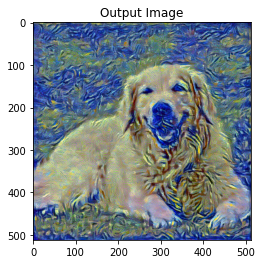

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_weight=1000000
input_img = content_img.clone().detach().requires_grad_(True)

output = run_style_transfer(vgg19,
                            cnn_normalization_mean,
                            cnn_normalization_std,
                            content_img, style_img, input_img,
                            num_steps=1000,
                            style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

## 3.3 Content/style loss weight ratio

Try two different style loss weights: 5000 and  10. Discuss what you learn from the results.

Building the style transfer model..
Optimizing..


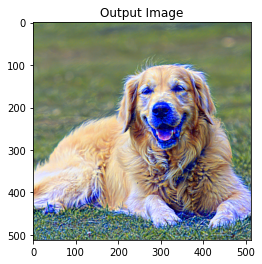

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_weight=5000
input_img = content_img.clone().detach().requires_grad_(True)

output2= run_style_transfer(vgg19,
                            cnn_normalization_mean,
                            cnn_normalization_std,
                            content_img,
                            style_img,
                            input_img,
                            num_steps=1000,
                            style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output2, title='Output Image')

plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


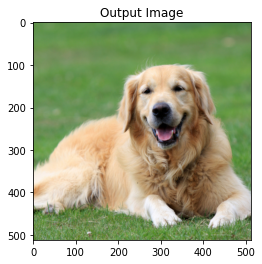

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_weight=10
input_img = content_img.clone().detach().requires_grad_(True)

output3= run_style_transfer(vgg19,
                            cnn_normalization_mean,
                            cnn_normalization_std,
                            content_img,
                            style_img,
                            input_img,
                            num_steps=1000,
                            style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output3, title='Output Image')

plt.ioff()
plt.show()

***your solution:***

As the `style_weight` decreases, the generated new works maintain the structure of the original image, and the similarity with the **style** image is becoming much lower.

## 3.4 Choose different intermediate layers

Try three different intermediate layers for style representations: conv_1, conv_3 and conv_5. Discuss what you learn from the results.

Building the style transfer model..
Optimizing..


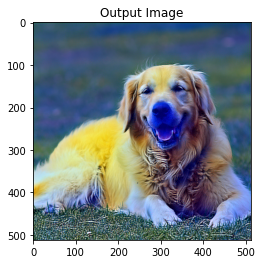

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1']
style_weight=1000000
input_img = content_img.clone().detach().requires_grad_(True)

output4= run_style_transfer(vgg19,
                            cnn_normalization_mean,
                            cnn_normalization_std,
                            content_img,
                            style_img,
                            input_img,
                            num_steps=1000,
                            style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output4, title='Output Image')

plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


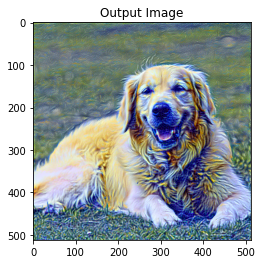

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_3']
style_weight=1000000
input_img = content_img.clone().detach().requires_grad_(True)

output5= run_style_transfer(vgg19,
                            cnn_normalization_mean,
                            cnn_normalization_std,
                            content_img,
                            style_img,
                            input_img,
                            num_steps=1000,
                            style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output5, title='Output Image')

plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


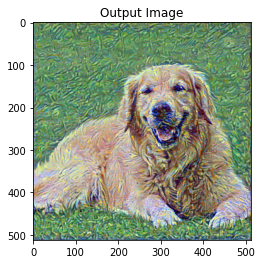

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_5']
style_weight=1000000
input_img = content_img.clone().detach().requires_grad_(True)

output6= run_style_transfer(vgg19,
                            cnn_normalization_mean,
                            cnn_normalization_std,
                            content_img,
                            style_img,
                            input_img,
                            num_steps=1000,
                            style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output6, title='Output Image')

plt.ioff()
plt.show()

***your solution:***

As can be seen from the comparison in the figures above, the more the network layer is in front, the more style can be applied to the whole picture.

- in the first picture generated, the whole picture was becomes somewhat blue, fits the original The Starry Night's main theme.

The later the network layer is, the more details of the generated image can be replaced with style.

- in the last picture generated, the whole picture's main theme is still green, but the detail is much more like the starry sky details as in the masterpiece.

# HW4: Bias and GANs


Designed by Maan Qraitem drawing from prior work by Anil Kag, Samarth Mishra, Kun He, Xide Xia, Kubra Cilingir, Vijay Thakkar, Ali Siahkamari, and Brian Kulis.


In [ ]:
from os import path

# Change this part to locate the correct directory where dataset resides
use_colab = True

if use_colab:
    # from google.colab import drive
    # drive.mount('/content/gdrive')
    #!ls "/content/gdrive/My Drive/Datasets/shared/HW4_shared_files"

    ## Update the experiments directory
    EXPERIMENTS_DIRECTORY = '/content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/'
    DATA_DIRECTORY = '/content/drive/MyDrive/Common Data/CS523/hw4/'
else:
    ## Update the experiments directory
    EXPERIMENTS_DIRECTORY = '/projectnb/dl523/students/mqraitem/experiments'
    DATA_DIRECTORY = '/projectnb/dl523/students/mqraitem/datasets/'

CELEBA_GOOGLE_DRIVE_PATH = path.join(DATA_DIRECTORY, 'celeba_attributes_images.hdf5')
IMDB_REVIEWS_FILE_PATH = path.join(DATA_DIRECTORY, 'data/')

def check_gpu() -> None:
    result = !nvidia-smi --query-gpu=name --format=csv,noheader
    answer = result[0].strip()
    if len(answer) == 0 or "nvidia-smi" in (answer.lower()):
        print("No gpus are found in this Notebook.")
    else:
        print(f"You are using: {answer}")

check_gpu()

You are using: Tesla V100-SXM2-16GB


In [ ]:
def DPATH(f: str) -> str:
    from os.path import join
    return join(EXPERIMENTS_DIRECTORY, f)

### Modules needed

In [ ]:
import os
import random
import math
import datetime
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
#import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils import data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.backends import cudnn

import numpy as np 
from PIL import Image
from tqdm.notebook import tqdm 
import random 

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch import nn, optim

import typing

%matplotlib inline

# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


---

# 4. Understanding Spurious Bias and its impact on Model Performance

## 4.1 : Survery of Bias in Deep Learning [10 Points]

Bias in Deep Learning can manifest in many ways. Start by reading the following [Survey](https://arxiv.org/pdf/1908.08843.pdf) . Upon reading, please answer the questions below: 


1. Given a sensitive group of samples (eg a certain class of people), can a deep learning model learn to discriminate against said group if we do not explicitly feed identifying information to the model (ex class indicator variable, zip code, etc)? Support your argument with an example. 

  Yes. For example, a DNN can learn representative of raw texts, which is related to the gender of the user. Although users have never actively-reported their gender (thus, there's no such `gender` label), DNN can still find the distribution differences of texts and sentences produced by people of different genders.
 


2. What is the disadvantage of post-processing methods that calibrate prediction scores to fit a certain fairness metric? discuss this disadvantage in the context of deep learning applications. 

  They require inference-time access to protected attributes, which however usually are not available during inference time in real-world applications. For example, during training and validating in a gender-related program, we can use the existing gender field to mitigate the classifier's relying on the hair style in the picture to predict the gender of a person. However during the predicting stage in production environment (i.e. when program used by the end user), the program will have no chance to get the protected attribute.

In this problem, we will study one form of Bias, usually called: Spurious Correlations. We will explore this bias implication on model performance using a visual recognition problem *. More concretely, given a standard visual recognition dataset with image-target pairs $(X, Y)$ assume that each $x\in X$ can also be classified into a sensitive group $b \in B$. For example, $B$ can represent the various colors of an object or the material it is made of. Bias research is concerned with the scenario when most samples of one class (e.g., airplane) belong to one sensitive group (e.g., objects with the color red). Therefore, the model might use this signal (most airplanes are red) in predicting airplanes. This means the model might be less likely to predict an airplane if it was of the color blue. If your goal for your model is to recognize airplanes of all colors equally well, then the behavior above is suboptimal. 

In this problem, we will use the CIFAR10 dataset to document the occurrence of such Bias. Then, we will experiment with a simple baseline that mitigates it. 

\* Note that this form of Bias can affect more than visual recognition. Examples include Image captioning, VQA, and others.

In [ ]:
class BiasedCifar10: 
    def __init__(self,
                 root,
                 split,
                 skew_value=0.5): 
        
        train_valid = (split == 'train' or split == 'valid')

        # 使用下载好的 cifar 数据集
        self.cifar10 = CIFAR10(root, train=train_valid, download=True)
        self.images = self.cifar10.data 
        self.targets = np.array(self.cifar10.targets) 
        self.bias = np.zeros_like(self.targets) 
        self.split = split
        self.gray_classes =  [0,1,2,3,4]


        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2470, 0.2435, 0.2616]
        self.transform =  transforms.Compose([
                          transforms.ToPILImage(), 
                          transforms.RandomCrop(32, padding=4),
                          transforms.RandomHorizontalFlip(),
                          transforms.ToTensor(),
                          transforms.Normalize(mean, std)])

        if train_valid: 
            self.build_split() 
            self.corrupt_dataset(skew_value)    

        else: 
            self.corrupt_dataset(0.5)
                          
    def build_split(self):
        
        indices = {i:[] for i in range(10)} 
        size_per_class = 5000
        for idx, tar in enumerate(self.targets): 
            indices[tar].append(idx)

        if self.split == 'train': 
            start = 0 
            end = int(size_per_class * 0.9) 

        if self.split == 'valid':
            start = int(size_per_class * 0.9) 
            end = size_per_class

        final_indices = [] 
        for ind_group in indices.values(): 
            final_indices.extend(ind_group[start:end]) 
        
        random.shuffle(final_indices) 
        
        self.images = self.images[final_indices]
        self.bias = self.bias[final_indices]
        self.targets = self.targets[final_indices] 
        
    def rgb_to_grayscale(self, img):
        """Convert image to gray scale"""
        
        pil_img = Image.fromarray(img)
        pil_gray_img = pil_img.convert('L')
        np_gray_img = np.array(pil_gray_img, dtype=np.uint8)
        np_gray_img = np.dstack([np_gray_img, np_gray_img, np_gray_img])
    
        return np_gray_img

    def corrupt_dataset(self, skew_level):
        
        samples_by_class = {i:[] for i in range(10)} 
        for idx, target in enumerate(self.targets): 
            samples_by_class[target].append(idx) 

        for class_idx in tqdm(range(10), desc="Processing classes", unit="cls"): 
            class_samples = samples_by_class[class_idx]
            if class_idx in self.gray_classes: 
                samples_skew_num = int(len(class_samples) * skew_level) 
            else: 
                samples_skew_num = int(len(class_samples) * (1 - skew_level)) 
                
            samples_skew = random.sample(class_samples, samples_skew_num)
            for sample_idx in samples_skew: 
                self.images[sample_idx] = self.rgb_to_grayscale(self.images[sample_idx]) 
                self.bias[sample_idx] = 1 
    
    def __len__(self): 
        return len(self.images) 

    def __getitem__(self, index): 
        img = self.images[index]
        target = self.targets[index]
        bias = self.bias[index]
    
        if self.transform: 
            img = self.transform(img)
        
        return img, target, bias

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch 

from torchvision.models import resnet18


class FCResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        model = resnet18(pretrained=False)
        modules = list(model.children())[:-1]
        self.extractor = nn.Sequential(*modules)
        self.embed_size = 512
        self.num_classes = num_classes
        self.fc = nn.Linear(self.embed_size, num_classes)

    def forward(self, x):
        out = self.extractor(x)
        out = out.squeeze(-1).squeeze(-1)

        logits = self.fc(out)
        return logits

In [ ]:
skew_value = 0.85
batch_size = 128

ds_train = BiasedCifar10(root='./', split='train', skew_value=skew_value) 
ds_val = BiasedCifar10(root='./', split='valid', skew_value=skew_value) 
ds_test = BiasedCifar10(root='./', split='test') 


train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=2)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

 As discussed earlier, we will work with CIFAR10 dataset. The dataset comes equipped with 10 classes. The dataset code above introduces bias by converting a $S\%$ of the images in the first 5 classes to Gray-Scale. For the rest of the 5 classes, it will convert $1 - S\%$ of them to Gray-Scale. Assuming $S > 50\%$, the first 5 classes will be biased toward Gray, and the rest will be biased toward Color. Thus, $B = \{\text{Color}, \text{Gray-Scale}\}$. You can control the variable $S$ through the skew_value above. To get you started, run the training code below.

In [ ]:
model = FCResNet18(num_classes=10).cuda()
criterion = nn.CrossEntropyLoss()
decay_epochs = [10, 15, 20]

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum =0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_epochs, gamma=0.1)

Epochs = 25

for epoch in range(1, Epochs + 1):
    model.train()

    train_iter = iter(train_loader)
    loss_acc = 0 
    for idx, (images, labels, biases) in enumerate(train_iter):
        labels, biases = labels.cuda(), biases.cuda()

        images = images.cuda()
        logits = model(images)

        loss = criterion(logits, labels)
        loss_acc += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_acc /= Epochs
    print('Epoch %d: Loss = %.2f'%(epoch, loss_acc))

Epoch 1: Loss = 31.00
Epoch 2: Loss = 20.83
Epoch 3: Loss = 18.16
Epoch 4: Loss = 16.39
Epoch 5: Loss = 15.03
Epoch 6: Loss = 14.13
Epoch 7: Loss = 13.37
Epoch 8: Loss = 12.85
Epoch 9: Loss = 12.41
Epoch 10: Loss = 12.12
Epoch 11: Loss = 11.71
Epoch 12: Loss = 11.44
Epoch 13: Loss = 11.33
Epoch 14: Loss = 11.13
Epoch 15: Loss = 10.91
Epoch 16: Loss = 10.80
Epoch 17: Loss = 10.65
Epoch 18: Loss = 10.62
Epoch 19: Loss = 10.34
Epoch 20: Loss = 10.28
Epoch 21: Loss = 10.20
Epoch 22: Loss = 10.16
Epoch 23: Loss = 10.18
Epoch 24: Loss = 9.96
Epoch 25: Loss = 9.97


 As you might have noticed, we only introduce bias to the training set. Therefore, our test set is equally distributed among the bias groups. This choice is because we want to test our model's predictive ability on every bias group. To that end, we will use two metrics. The first one is a standard accuracy metric. The second one is called True Positive Rate Disparity. It seeks to measure the average difference in TPR between the two bias groups for each class. More concretely, it measures: 

$$TD = \frac{1}{C} \sum_{y} | P(\hat{y}=1 | b = 1, y = 1) - P(\hat{y}=1 | b = 0, y = 1)|$$

 Where $C$ indicates the number of classes, $\hat{y}$ indicates model prediction, and $y$ denotes ground-truth label.




## 4.2 Now, please answer the following questions [10 Points]

1. Why do you think TPR disparity is a good metric to track bias? 

   **Answer:** Because TPR disparity actually represents: for each class, the number of data which should be TP (True Positive), but become others result due to `biased = 1`.

2. What do you think will happen to the Accuracy metric if our test set was not balanced among the bias groups? i.e. it followed the distribution of the training set

   **Answer:** If the distribution of the training set is identical to the training data set, then $P(\hat{y}=1 | b = 1, y = 1)$ will be the same as $P(\hat{y}=1 | b = 0, y = 1)$. This means that the algorithm can no longer measure the value of TPR Disparity.

## 4.3: Finish the test loop below by writing code to compute accuracy and TPR disparity [10 Points]

In [ ]:
correct = np.zeros((10, 2)) 
counts = np.zeros((10, 2))

with torch.no_grad():
    for idx, (images, labels, biases) in enumerate(tqdm(test_loader)):
        images = images.cuda()
        output = model(images).cpu()
        preds = output.data.max(1, keepdim=True)[1].squeeze(1).numpy()

        true_positive = np.equal(preds, labels.numpy())
        no_biases = (biases.numpy() == 0)
        have_biases = (biases.numpy() == 1)

        for this_label in range(0, 10):
            # Filter the current class label
            these = (labels.numpy() == this_label)
            
            # Count the current class labeled with bias and without bias
            these_no_biases = these & no_biases
            these_have_biases = these & have_biases
            
            counts[this_label, 0] += np.sum(these_no_biases)
            counts[this_label, 1] += np.sum(these_have_biases)

            # current and true
            these_true_no_biases = these_no_biases & true_positive
            these_true_have_biases = these_have_biases & true_positive

            correct[this_label, 0] += np.sum(these_true_no_biases)
            correct[this_label, 1] += np.sum(these_true_have_biases)


final = correct / counts

print("Accuracy %.2f " % np.mean(final))
print("TPR Disparity %.2f " % np.mean(np.abs(final[:, 0] - final[:, 1])))

  0%|          | 0/352 [00:00<?, ?it/s]

Accuracy 0.67 
TPR Disparity 0.28 


In [ ]:
print(f'额外统计信息: final:\n{final}\n correct:\n{correct}\n counts:\n{counts}')

额外统计信息: final:
[[0.72       0.84392157]
 [0.67407407 0.89777778]
 [0.52740741 0.60784314]
 [0.28444444 0.76470588]
 [0.51407407 0.73385621]
 [0.72       0.3037037 ]
 [0.81359477 0.45925926]
 [0.90013072 0.68740741]
 [0.90849673 0.66962963]
 [0.8648366  0.44888889]]
 correct:
[[ 486. 3228.]
 [ 455. 3434.]
 [ 356. 2325.]
 [ 192. 2925.]
 [ 347. 2807.]
 [2754.  205.]
 [3112.  310.]
 [3443.  464.]
 [3475.  452.]
 [3308.  303.]]
 counts:
[[ 675. 3825.]
 [ 675. 3825.]
 [ 675. 3825.]
 [ 675. 3825.]
 [ 675. 3825.]
 [3825.  675.]
 [3825.  675.]
 [3825.  675.]
 [3825.  675.]
 [3825.  675.]]


## 4.4 Repeat the above training procedure three times using $S \in \{0.85, 0.9, 0.95\}$. Record your TPR and Acc values below and run the code to plot your results. what do you conclude? [10 Points]

In [ ]:
# Wrapping all previous code into functions for easy reuse.


def train_sub(this_train_loader: any) -> any:
    model = FCResNet18(num_classes=10).cuda()
    criterion = nn.CrossEntropyLoss()
    decay_epochs = [10, 15, 20]

    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_epochs, gamma=0.1)

    Epochs = 25

    with tqdm(total=Epochs, desc="Epoch: ") as tqdm1:
        for epoch in range(1, Epochs + 1):
            model.train()

            train_iter = iter(this_train_loader)
            loss_acc = 0 
            for idx, (images, labels, biases) in enumerate(train_iter):
                labels, biases = labels.cuda(), biases.cuda()

                images = images.cuda()
                logits = model(images)

                loss = criterion(logits, labels)
                loss_acc += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            loss_acc /= Epochs
            # print('Epoch %d: Loss = %.2f'%(epoch, loss_acc))
            tqdm1.update()

    return model

def test_sub(this_test_loader: any, model: any):
    correct = np.zeros((10, 2)) 
    counts = np.zeros((10, 2))

    with torch.no_grad():
        for idx, (images, labels, biases) in enumerate(tqdm(this_test_loader)):
            images = images.cuda()
            output = model(images).cpu()
            preds = output.data.max(1, keepdim=True)[1].squeeze(1).numpy()

            true_positive = np.equal(preds, labels.numpy())
            no_biases = (biases.numpy() == 0)
            have_biases = (biases.numpy() == 1)

            for this_label in range(0, 10):
                # Filter the current class label
                these = (labels.numpy() == this_label)
                
                # Count the current class labeled with bias and without bias
                these_no_biases = these & no_biases
                these_have_biases = these & have_biases
                
                counts[this_label, 0] += np.sum(these_no_biases)
                counts[this_label, 1] += np.sum(these_have_biases)

                # current and true
                these_true_no_biases = these_no_biases & true_positive
                these_true_have_biases = these_have_biases & true_positive

                correct[this_label, 0] += np.sum(these_true_no_biases)
                correct[this_label, 1] += np.sum(these_true_have_biases)


    final = correct / counts

    print("Accuracy %.2f " % np.mean(final))
    print("TPR Disparity %.2f " % np.mean(np.abs(final[:, 0] - final[:, 1])))
    # print(f'额外统计信息: final:\n{final}\n correct:\n{correct}\n counts:\n{counts}')


def train_with_skew(skew_prop: float):
    from torch.utils.data import DataLoader

    if skew_prop < 0 or skew_prop > 1:
        raise ValueError("skep_prop should be a float between 0.0 and 1.0")
    
    skew_value = skew_prop
    batch_size = 128

    this_ds_train = BiasedCifar10(root='./', split='train', skew_value=skew_value)

    this_train_loader = DataLoader(this_ds_train, batch_size=batch_size,
                                   shuffle=True, num_workers=2)
    this_test_loader = DataLoader(this_ds_train, batch_size=batch_size,
                                   shuffle=True, num_workers=2)
    
    model = train_sub(this_train_loader)
    test_sub(this_test_loader, model)
        

for skew in [0.85, 0.9, 0.95]:
    print(f"Skew = {skew}")
    train_with_skew(skew)


Skew = 0.85
Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

Accuracy 0.67 
TPR Disparity 0.30 
Skew = 0.9
Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

Accuracy 0.65 
TPR Disparity 0.31 
Skew = 0.95
Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

Accuracy 0.59 
TPR Disparity 0.48 


Text(0, 0.5, 'TPR Disparity')

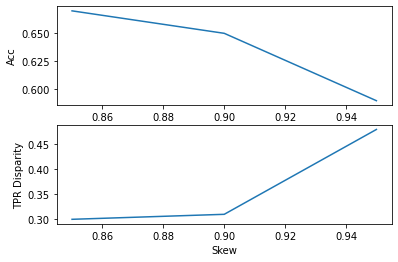

In [ ]:
Skew = [0.85, 0.9, 0.95]

################################################
##### FILL YOUR EXPERIMENTS VALUES HERE
Acc = [0.67, 0.65, 0.59]
TPR = [0.30, 0.31, 0.48] 
################################################


import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(Skew, Acc)
ax1.set_xlabel('Skew')
ax1.set_ylabel('Acc')

ax2.plot(Skew, TPR)
ax2.set_xlabel('Skew')
ax2.set_ylabel('TPR Disparity')

**Answer:** The higher the rate of bias in each class, the more Accuracy is eventually lost due to bias (i.e., the value of TDR Disparity, which is larger to indicate more loss).
 

---

# 5. A method to mitigate Spurious Bias

In this section of the problem, we will explore Domain Independence, one of many solutions for mitigating Bias. The solution dedicates a prediction head for each different sensitive group $b$. Observe the Figure below. Note that each sensitive group: Color/Gray will have its prediction head of 10 classes. Thus, when training, samples that belong to $b= $Color will backpropagate only through the Color prediction head. 


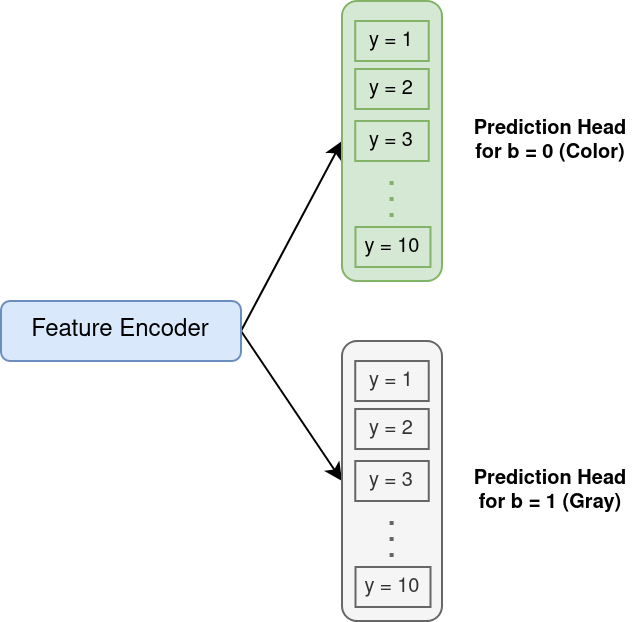

## 5.1 Why do you think this might be a good solution? [5 Points]

It uses a similarity metric as a feature to compare with labeled domain data. Then the model will learn a matching function to infer the correct semantic label of the data.


## 5.2: We wrote most of the model structure but we left the final linear layer for you to implement. Fill in the code below: [5 Points]

In [ ]:
class DIResNet18(nn.Module):
    def __init__(self, num_classes=10, num_biases=2):
        super().__init__()

        # Using a pre-trained ResNet 18 network
        model = resnet18(pretrained=False)

        # Remove the last layer of the network
        # and modify it to our custom structure
        modules = list(model.children())[:-1]
        self.extractor = nn.Sequential(*modules)

        # The number of cells that will be output
        # by the last layer of the ResNet network
        self.embed_size = 512
        self.num_classes = num_classes
        self.num_biases = num_biases

        ################################################
        ##### CODE HERE
        self.fc = nn.Linear(self.embed_size,
                            self.num_classes * self.num_biases)
        ################################################ 
                
    def forward(self, x):
        out = self.extractor(x)
        out = out.squeeze(-1).squeeze(-1)
        logits = self.fc(out)
        return logits

## 5.3: Before we start training, we need to write the loss function.

- [ ] First, you will need to apply softmax for each head independently. 
- [ ] Then, given the bias value for each sample, you will need to select the logit values of that sample from the correct prediction head [20 Points] 

Hint: Consider using Pytorch NLL [implemenation](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html). 

In [ ]:
import pdb

class DILoss(nn.Module):
    def __init__(self,
                 num_classes: int=10,
                 num_biases: int=2):
        super().__init__()
        self.num_classes = num_classes
        self.num_biases = num_biases

    def forward(self, logits: torch.Tensor, labels: torch.Tensor, biases: torch.Tensor):
        # split into different classes

        logits_heads = [logits[:,self.num_classes * i:self.num_classes * (i + 1)] for i in range(self.num_biases)]
        
        logSoftMax = nn.LogSoftmax(dim=1)
        ll_logits_heads = [logSoftMax(logits_heads[i]) for i in range(self.num_biases)]

        # then we will select from this heads
        final_ll_logits = []
        for i, bias in enumerate(biases):
            final_ll_logits.append(ll_logits_heads[bias][i])
        final_ll_logits = torch.stack(final_ll_logits)

        nllLoss = nn.NLLLoss()
        loss = nllLoss(final_ll_logits, labels)
        return loss

**Once you are done with the loss, you can start training the model below. **

In [ ]:
skew_value = 0.95
batch_size = 128

ds_train = BiasedCifar10(root='./', split='train', skew_value=skew_value) 
ds_val = BiasedCifar10(root='./', split='valid', skew_value=skew_value) 
ds_test = BiasedCifar10(root='./', split='test') 


train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

In [ ]:
model = DIResNet18().cuda()
criterion = DILoss()
decay_epochs = [10, 15, 20]

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum =0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_epochs, gamma=0.1)

Epochs = 25

for epoch in range(1, Epochs + 1):
    model.train()

    train_iter = iter(train_loader)
    loss_acc = 0 
    for idx, (images, labels, biases) in enumerate(train_iter):
        labels, biases = labels.cuda(), biases.cuda()

        images = images.cuda()
        logits = model(images)

        loss = criterion(logits, labels, biases)
        loss_acc += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_acc /= Epochs
    print('Epoch %d: Loss = %.2f'%(epoch, loss_acc))

Epoch 1: Loss = 24.07
Epoch 2: Loss = 16.84
Epoch 3: Loss = 14.78
Epoch 4: Loss = 13.18
Epoch 5: Loss = 12.18
Epoch 6: Loss = 11.41
Epoch 7: Loss = 10.90
Epoch 8: Loss = 10.46
Epoch 9: Loss = 10.10
Epoch 10: Loss = 9.94
Epoch 11: Loss = 9.67
Epoch 12: Loss = 9.43
Epoch 13: Loss = 9.31
Epoch 14: Loss = 9.05
Epoch 15: Loss = 9.07
Epoch 16: Loss = 8.90
Epoch 17: Loss = 8.79
Epoch 18: Loss = 8.59
Epoch 19: Loss = 8.57
Epoch 20: Loss = 8.61
Epoch 21: Loss = 8.45
Epoch 22: Loss = 8.39
Epoch 23: Loss = 8.29
Epoch 24: Loss = 8.43
Epoch 25: Loss = 8.28


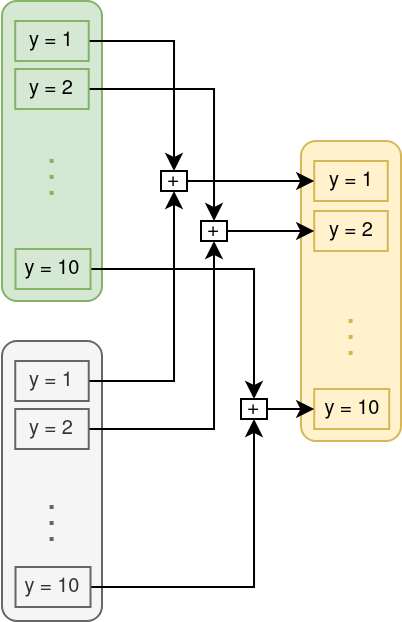

Finally, we will have to do some inference! A significant challenge with this problem is that we don't have access to the bias label at test time. Therefore, we will have to combine the information from each head. It turns out that summing the logits for each class from every head is a good solution, as the figure above suggests. 

## 5.4: Imeplemnt the inference procedure described above. Have your Unbiased Accuracy and TPR Disparity Improve? [10 Points] 

In [ ]:
correct = np.zeros((10, 2)) 
counts = np.zeros((10, 2))

with torch.no_grad():
    for idx, (images, labels, biases) in enumerate(tqdm(test_loader)):
        images = images.cuda()
    
        ################################################
        ##### TODO CODE HERE

        # output contains 20 output, where 0-9 means bias=0,
        # and 10-19 means bias=1
        output = model(images).cpu()

        # Cumulative prediction results for bias=0 and bias=1
        output2 = output[:,0:10] + output[:,10:20]

        preds = output2.data.max(1, keepdim=True)[1].squeeze(1).numpy()

        true_positive = np.equal(preds, labels.numpy())
        no_biases = (biases.numpy() == 0)
        have_biases = (biases.numpy() == 1)

        for this_label in range(0, 10):
            # Filter the current class label
            these = (labels.numpy() == this_label)
            
            # Count the current class labeled with bias and without bias
            these_no_biases = these & no_biases
            these_have_biases = these & have_biases
            
            counts[this_label, 0] += np.sum(these_no_biases)
            counts[this_label, 1] += np.sum(these_have_biases)

            # current and true
            these_true_no_biases = these_no_biases & true_positive
            these_true_have_biases = these_have_biases & true_positive

            correct[this_label, 0] += np.sum(these_true_no_biases)
            correct[this_label, 1] += np.sum(these_true_have_biases)
        
        ################################################

final = correct/counts
print("Accuracy %.2f "%np.mean(final))
print("TPR Disparity %.2f "%np.mean(np.abs(final[:, 0] - final[:, 1])))

  0%|          | 0/352 [00:00<?, ?it/s]

Accuracy 0.69 
TPR Disparity 0.05 


---

# 6. GAN model on Celeb-A face dataset

We will implement a Generative Adversarial Network (GAN) in Q3 and Q4. In this problem, we will start by implementing basic helper functions and a working training routine which would be modified a bit in problem Q4 to present a hairstyle change application. 

This assignment is inspired by the following research paper, 

[StarGAN: Unified Generative Adversarial Networks for Multi-Domain Image-to-Image Translation](https://arxiv.org/abs/1711.09020)

Note that the basic building blocks of GAN are 
1. **Generator** : generates images similar to the real images provided in the dataset in order to fool the discriminator.

2. **Discriminator** : acts as a fact checker in order to determine which images are fake and which are real 

3. **Latent representation** : generator cannot arbitrarily generate images out of thin air. It picks up a latent representation (usually a noise or some fixed pattern), and utilizes this source as a latent code and generates image during this process.

For an easy tutorial to understand GAN's building blocks, please follow the PyTorch DC-GAN [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html). It is recommended you study the tutorial before proceeding with the assignment. 


Note that f and g in the following image are the same as $D$ and $G$ respectively

<img src="https://i.imgur.com/FhSycJD.png" style="width: 600px;"/>

Although the tutorial describes the GAN framework very well with appropriate links to the original paper, for completeness, we mention the losses for the discriminator and generator. The GAN optimization objective is the following : 

$$\underset{G}{\text{min}} ~~ \underset{D}{\text{max}} ~~ V(D,G) = \mathbb{E}_{x\sim p_{x}(x)}\big[\log D(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[\log (1-D(G(z)))\big]$$

where $p_{x}(x)$ is the distribution of the real image data and $p_{z}(z)$ is the distribution from which latent vectors are sampled to input to the generator. $G$ is the generator, parametrized by parameters $w$ and $D$, the discriminator with parameters $\phi$. In practice, these parameters are usually optimized in an alternating fashion, fixing one when optimizing the other, with the following loss functions:

$$ loss_D(\phi) = - \mathbb{E}_{x\sim p_{x}(x)}\big[\log D(x; \phi)\big] - \mathbb{E}_{z\sim p_{z}(z)}\big[\log (1-D(G(z; w); \phi))\big] $$

$$ loss_G(w) = - \mathbb{E}_{z\sim p_{z}(z)}\big[\log (D(G(z; w); \phi))\big] $$

In this assignment you shall use these loss functions and method of training $G$ and $D$.

## StarGAN Architecture (Single dataset)

Above figure is a generic representation of a DC-GAN architecture, although powerful, it will not be able to accuractly generate discrete feature transformations. Instead we use StarGAN, originally proposed to learn feature generators using multiple dataset (uses two large vision datasets (CelebA, RaFD) in the paper). For example in the image below, you see the entire architecture which uses only CelebA dataset, and keeps discards RaFD information. For simplicity, we will use only one dataset, i.e. CelebA. From this architecture, you should takeaway the following points

1. **Discriminator** is learning to distinguish between a real and a fake/generator image. It also learns what the label looked like in the original dataset (we only care about CelebA label).

2. **Generator** is learning to generate a new image from the given input image and the target attribute (for example hairstyle change, in the image below, gender change is requested). 

Note that the attribute or the latent information for the generator is a discrete boolean vector, instead of a Gaussian vector which you generate in GANs like DC-GAN. 

<img src="https://i.imgur.com/58dbEX9.png" style="width: 600px;"/>


### Arguments

First, we first define some arguments for the training run. 

-  **selected_attributes** -  the attributes which will be used for generating various style attributes on the celebrity face.
-  **c_dim** - the number of attributes we will use from the CelebA dataset. its set to `len(selected_attributes)`
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. 
-  **g_conv_dim** - the number of convolutional fitlers for generator
-  **d_conv_dim** - the number of convolutional fitlers for discriminator 
-  **g_repeat_num** - the number of residual blocks in the generator 
-  **d_repeat_num** - the number of residual blocks in the discriminator
-  **lambda_cls** - the regularization hyper-parameter for classification error
-  **lambda_rec** -  the regularization hyper-parameter for reconstruction error
-  **lambda_gp** -  the regularization hyper-parameter for gradient penalty

-  **batch_size** - the batch size used in training. The paper
   uses a batch size of 16 for large configuration
-  **num_iters** - the number of training iterations
   the DataLoader
-  **num_iters_decay** - the number of iterations after which learning rate will decay
-  **g_lr** - the learning rate for generator
-  **d_lr** - the learning rate for discriminator
-  **n_critic** - generator will be updated every n_critic iterations.
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **beta2** - beta2 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.999
-  **num_workers** - the number of worker threads for loading the data with
   the DataLoader
-  **log_step** - log the update every log_steps
-  **sample_step** - generate a new sample every sample_step
-  **model_save_step** - save the model every model_save_step
-  **lr_update_step** - update the learning rate every lr_update_step
-  **log_dir** - directory where logs are stored
-  **sample_dir** - directory where samples are stored
-  **model_save_dir** - directory where trained models are stored
-  **result_dir** - directory where results are stored



In [ ]:
cudnn.benchmark = True

def get_experiment_configuration(repeat_num=6, num_iters=200000,
              log_step=100, sample_step=100, model_save_step=10000, 
              lr_update_step=1000, batch_size=16, mode='train', resume_iters=False,
              selected_attributes = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']):
    config = {}

    # Model configurations.
    config['c_dim'] = len(selected_attributes)
    config['image_size'] = 64
    config['g_conv_dim'] = 64
    config['d_conv_dim'] = 64
    config['g_repeat_num'] = repeat_num
    config['d_repeat_num'] = repeat_num
    config['lambda_cls'] = 1
    config['lambda_rec'] = 10
    config['lambda_gp'] = 10
    config['selected_attributes'] = selected_attributes 

    # Training configurations.
    config['batch_size'] = batch_size #16
    config['num_iters'] = num_iters
    config['num_iters_decay'] = num_iters//2
    config['g_lr'] = 0.0001
    config['d_lr'] = 0.0001
    config['n_critic'] = 5
    config['beta1'] = 0.5
    config['beta2'] = 0.999
    config['resume_iters'] = resume_iters

    # Test configurations.
    config['test_iters'] = num_iters

    # Miscellaneous.
    config['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    config['num_workers'] = 1
    config['mode'] = mode

    # Step size.
    config['log_step'] = log_step #10
    config['sample_step'] = sample_step
    config['model_save_step'] =  model_save_step #10000
    config['lr_update_step'] = lr_update_step # 1000

    EXPERIMENT_RESULTS_FOLDER = EXPERIMENTS_DIRECTORY + 'gan-experiments/'

    suffix = str(repeat_num) + '-cdim-' + str(len(selected_attributes))
    config['log_dir'] = EXPERIMENT_RESULTS_FOLDER + 'logs-' + suffix
    config['sample_dir'] = EXPERIMENT_RESULTS_FOLDER + 'sample_dir-' + suffix
    config['model_save_dir'] = EXPERIMENT_RESULTS_FOLDER + 'model_save_dir-' + suffix
    config['result_dir'] = EXPERIMENT_RESULTS_FOLDER + 'result_dir-' + suffix

    print('\n\nPlease ensure you are using a GPU for computation')
    print('Will be using the following device for computation : ', config['device'])

    # Create directories if not exist.
    if not os.path.exists(config['log_dir']):
        os.makedirs(config['log_dir'])
    if not os.path.exists(config['sample_dir']):
        os.makedirs(config['sample_dir'])
    if not os.path.exists(config['model_save_dir']):
        os.makedirs(config['model_save_dir'])
    if not os.path.exists(config['result_dir']):
        os.makedirs(config['result_dir'])

    return config

### Data

We have downloaded pre-processed and stored data in the HDF5 format on the zip file provided with the assignment. Think of the file storing a large numpy ndarray of images (shape : `num_imgs x num_channels x height x width`). `celebA` class implemented below derives from `torch.utils.data.Dataset` and provides the code infrastucture to read images from this file. 

This data contains images of many celebrities along with labels for various image attributes (hair, gender, age, etc). There are 40 such attributes. We will use them later for cool applications. 

In [ ]:
ALL_ATTRIBUTES = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',  
      'Bags_Under_Eyes',  'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 
      'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby',
      'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup',
      'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
      'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 
      'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
      'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
      'Wearing_Necklace', 'Wearing_Necktie', 'Young' ]
print('# attributes = ', len(ALL_ATTRIBUTES))

# attributes =  40


The above attributes can help us learn a GAN which can transfer various attributes from the given input image. For example, in the original paper, they show that the input image can be transformed such that many attributes change (hair color, gender, age, skin in this example).
<img src="https://i.imgur.com/eXxK09G.jpg" style="width: 600px;"/> 

In [ ]:
class CelebA(torch.utils.data.Dataset):
    """Dataset class for the CelebA dataset."""

    def __init__(self, transform, mode, config):
        """Initialize and preprocess the CelebA dataset."""

        self.file = h5py.File(CELEBA_GOOGLE_DRIVE_PATH, 'r')
        self.total_num_imgs, self.H, self.W, self.C = self.file['images'].shape
        
        self.images = self.file['images']
        self.attributes = self.file['attributes']

        self.selected_attrs = config['selected_attributes'] 
        self.all_attr_names = ALL_ATTRIBUTES

        self.transform = transform
        self.mode = mode

        self.train_dataset = []
        self.test_dataset = []
        self.attr2idx = {}
        self.idx2attr = {}
        self.preprocess()

        if mode == 'train':
            self.num_images = len(self.train_dataset)
        else:
            self.num_images = len(self.test_dataset)

    def preprocess(self):
        """Preprocess the CelebA attribute file."""
        for i, attr_name in enumerate(self.all_attr_names):
            self.attr2idx[attr_name] = i
            self.idx2attr[i] = attr_name

        self.all_idxs = np.arange(self.total_num_imgs)
        N_test = 9
        self.train_dataset = self.all_idxs[:-N_test] 
        self.test_dataset = self.all_idxs[-N_test:]

        random.seed(1234)
        np.random.seed(1234)        
        np.random.shuffle(self.train_dataset)

        print('Finished preprocessing the CelebA dataset...')

    def __getitem__(self, index):
        """Return one image and its corresponding attribute label."""
        dataset = self.train_dataset if self.mode == 'train' else self.test_dataset
        idx = dataset[index]

        image = self.file['images'][idx]
        attributes = self.file['attributes'][idx]

        label = []
        for attr_name in self.selected_attrs:
            idx = self.attr2idx[attr_name]
            label.append(attributes[idx])

        # pdb.set_trace()
        # print(self.transform(image))
        # print(torch.FloatTensor(label))
        
        return self.transform(image), torch.FloatTensor(label)

    def __len__(self):
        """Return the number of images."""
        return self.num_images


def get_loader(config, mode='train'):
    """Build and return a data loader."""
    
    batch_size = config['batch_size']
    num_workers = config['num_workers']
    
    transform = []
    transform.append(T.ToPILImage())
    if mode == 'train':
        transform.append(T.RandomHorizontalFlip())
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)
    
    dataset = CelebA(transform, mode, config)

    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=(mode=='train'),
                                  num_workers=num_workers)
    return data_loader
  
def denorm(x):
    """Convert the range from [-1, 1] to [0, 1]."""
    out = (x + 1) / 2
    return out.clamp_(0, 1)



Please ensure you are using a GPU for computation
Will be using the following device for computation :  cuda
Finished preprocessing the CelebA dataset...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


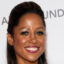

In [ ]:
SELECTED_ATTRIBUTES = ['Black_Hair', 'Blond_Hair', 'Brown_Hair']

small_config = get_experiment_configuration(repeat_num=1, num_iters=20000,
              batch_size=128, selected_attributes = SELECTED_ATTRIBUTES)

loader = get_loader(small_config, mode='test')
data_iter = iter(loader)
x_fixed, _ = next(data_iter)

from torchvision.transforms import ToPILImage
to_img = ToPILImage()

# display tensor
to_img( denorm( x_fixed[0]  ) )

### Modules for Generator and Discriminator

The following cell defines the generator and discriminator networks as `nn.Modules` .

In [ ]:
class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True))

    def forward(self, x):
        return x + self.main(x)

class Generator(nn.Module):
    """Generator network."""
    def __init__(self, conv_dim=64, c_dim=5, repeat_num=6):
        super(Generator, self).__init__()

        layers = []
        layers.append(nn.Conv2d(3+c_dim, conv_dim, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-sampling layers.
        curr_dim = conv_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck layers.
        for i in range(repeat_num):
            layers.append(ResidualBlock(dim_in=curr_dim, dim_out=curr_dim))

        # Up-sampling layers.
        for i in range(2):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 3, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.Tanh())
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        # Replicate spatially and concatenate domain information.
        # Note that this type of label conditioning does not work at all if we use reflection padding in Conv2d.
        # This is because instance normalization ignores the shifting (or bias) effect.
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        return self.main(x)

class Discriminator(nn.Module):
    """Discriminator network."""
    def __init__(self, image_size=128, conv_dim=64, c_dim=5, repeat_num=6):
        super(Discriminator, self).__init__()
        layers = []
        layers.append(nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.01))

        curr_dim = conv_dim
        for i in range(1, repeat_num):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.LeakyReLU(0.01))
            curr_dim = curr_dim * 2

        kernel_size = int(image_size / np.power(2, repeat_num))
        self.main = nn.Sequential(*layers)
        self.conv1 = nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(curr_dim, c_dim, kernel_size=kernel_size, bias=False)
        
    def forward(self, x):
        h = self.main(x)
        out_src = self.conv1(h)
        out_cls = self.conv2(h)
        return out_src, out_cls.view(out_cls.size(0), out_cls.size(1))

Miscellaneous functions for updating learning rates, resetting the gradients and restoring a trained model from storage.

In [ ]:
def update_lr(g_optimizer, d_optimizer, g_lr, d_lr):
    """Decay learning rates of the generator and discriminator."""
    for param_group in g_optimizer.param_groups:
        param_group['lr'] = g_lr
    for param_group in d_optimizer.param_groups:
        param_group['lr'] = d_lr

def reset_grad(g_optimizer, d_optimizer):    
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

### Helper Functions

Implement the following helper functions to complete the training code. Follow the instructions in the questions below.



## 6.1  Print number of parameters in the networks (5 points)

Write a function that takes input as a model and the model name, and prints the model and the number of parameters in the model.


In [ ]:
def print_network(model, name):
    print()
    print(f"{ name } network 1.0")
    print('=' * 100)
    num_params = 0

    model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
    layer_names = [child for child in model.children()]
    
    for i, layer_name in enumerate(layer_names):
        if i > 0:
            print('-' * 100)
        print(layer_name)

    print('=' * 100)
    num_params = sum(map(lambda m: m.numel(), model_parameters))
    print("The number of parameters:" + " " * 40 + f"{num_params}")

## 6.2 Invoke the optimizers on the Generator and Discriminator parameters (5 points)
Write a function that takes optimization parameters as input and returns optimizer functions for the discriminator and generator in PyTorch. Use [ADAM](https://arxiv.org/pdf/1412.6980.pdf) optimizer with the parameters $\beta_1$ and $\beta_2$ specified earlier.

In [ ]:
def get_optimizers(G: nn.Module,
                   D: nn.Module,
                   g_learning_rate: float,
                   d_learning_rate: float,
                   beta1,
                   beta2):
    """
    Returns a 2-tuple, optimizers for parameters of netD and netG
    """

    g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=(beta1, beta2))
    d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=(beta1, beta2))

    return g_optimizer, d_optimizer

## 6.3 Compute classification loss (5 points)

Given the logits and the target labels, compute binary cross entropy loss $\ell_{\text{cls}}$ .

In [ ]:
import torch.nn.functional as F

def classification_loss(logit, target):
    """
    Compute binary cross entropy loss.
    """

    return F.binary_cross_entropy_with_logits(logit, target,
                                              size_average=False) / logit.size(0)

    # return F.binary_cross_entropy_with_logits(logit, target)

## 6.4 Compute reconstruction loss (5 points)

This is a very popular loss function used in situations where you are given an original input $x$. In generative learning, through some latent space, you'll generate an almost replica of $x$, let us denote it by $\hat{x}$.

The reconstruction loss measures the distance between the replica and the original. Let $N$ be the number of elements in $x$ and $\hat{x}$, then the loss can be written as 

$$
\ell_{\text{rec}} =  \frac{1}{N} \sum^N_{i=1} | x_i - \hat{x}_i |
$$

In [ ]:
def reconstruction_loss( x_real, x_reconstructed ):
    """
    Compute the reconstruction loss.
    """

    x = x_real - x_reconstructed
    x = torch.abs(x)
    loss = torch.mean(x)
    
    return loss

## 6.5 Implement the discriminator loss (5 points)
Write a function that returns the discriminator loss written as :

$$
\ell_{discriminator} = \ell_{real} + \ell_{fake}  +  \lambda_{cls} * \ell_{cls}
$$

Note that we add an additional term associated with the generated data (its simple to compute so we do it for you :P ).

In [ ]:
def get_discriminator_loss(G: nn.Module,
                           D: nn.Module,
                           label_org: torch.Tensor,
                           x_real: torch.Tensor,
                           c_trg: torch.Tensor,
                           lambda_cls: float,
                           lambda_gp: float):
    """
    x_real = x_real.to(device)           # Input images.
    c_trg = c_trg.to(device)             # Target labels.
    label_org = label_org.to(device)     # Labels for computing classification loss.
    label_trg = label_trg.to(device)     # Labels for computing classification loss.
    """

    out_src, out_cls = D(x_real)
    d_loss_real = -torch.mean(out_src)
    ################################################
    ##### CODE HERE
    ##### classification loss between out_cls, label_org
    d_loss_cls = classification_loss(out_cls, label_org)
    ################################################

    # Compute loss with fake images.
    x_fake = G(x_real, c_trg)
    out_src, out_cls = D(x_fake.detach())
    d_loss_fake = torch.mean(out_src)

    d_loss_gp = torch.tensor(0.0)

    # Backward and optimize.
    d_loss = d_loss_real + d_loss_fake
    ################################################
    ##### add remaining loss terms as described in the problem

    # add lambda_cls * d_loss_cls
    d_loss += lambda_cls * d_loss_cls
    ################################################
    
    # d_loss = d_loss_real + d_loss_fake + lambda_cls * d_loss_cls
    return d_loss, d_loss_real, d_loss_fake, d_loss_cls, d_loss_gp

## 6.6 Implement the generator loss (5 points)

Write a function that returns the generator loss written as :

$$
\ell_{generator} = \ell_{fake} + \lambda_{rec} * \ell_{rec} +  \lambda_{cls} * \ell_{cls}
$$

Note that we add an additional term associated with the generated data (its simple to compute so we do it for you :P ).

In [ ]:
def get_generator_loss(G: nn.Module,
                       D: nn.Module,
                       x_real: torch.Tensor,
                       c_trg: torch.Tensor,
                       c_org: torch.Tensor,
                       label_trg: torch.Tensor,
                       lambda_rec: float,
                       lambda_cls: float):
    """
    """

    # Original-to-target domain.
    x_fake = G(x_real, c_trg)
    out_src, out_cls = D(x_fake)
    g_loss_fake = - torch.mean(out_src)

    ################################################
    ##### TODO CODE HERE
    ##### classification loss between out_cls and label_trg
    g_loss_cls = classification_loss(out_cls, label_trg)
    ################################################

    # Target-to-original domain.
    x_reconst = G(x_fake, c_org)
    ################################################
    ##### TODO CODE HERE
    ##### reconstruction loss between x_real and x_reconst
    g_loss_rec = reconstruction_loss(x_real, x_reconst)
    ################################################

    # Backward and optimize.
    g_loss = g_loss_fake
    ################################################
    ##### TODO CODE HERE
    ##### add remaining loss terms as described in the problem
    g_loss += lambda_rec * g_loss_rec
    g_loss += lambda_cls * g_loss_cls
    ################################################

    return g_loss, g_loss_fake, g_loss_cls, g_loss_rec

The following cell initializes the generator and discriminator. Prints both  neural networks, and allocates optimizers.

In [ ]:
# Instantiate Generator and Discriminator

SELECTED_ATTRIBUTES = ['Blond_Hair']

config = get_experiment_configuration(repeat_num=1, num_iters=10000, 
              log_step=100, sample_step=1000, model_save_step=1000, 
              batch_size=64, selected_attributes = SELECTED_ATTRIBUTES)

G = Generator(config['g_conv_dim'], config['c_dim'], config['g_repeat_num'])

D = Discriminator(config['image_size'], 
                  config['d_conv_dim'], 
                  config['c_dim'], 
                  config['d_repeat_num']) 

g_optimizer, d_optimizer = get_optimizers(G, D, 
                                          config['g_lr'], config['d_lr'], 
                                          config['beta1'], config['beta2'])

print_network(G, 'Generator')
print_network(D, 'Discriminator')
    
G = G.to(config['device'])
D = D.to(config['device'])



Please ensure you are using a GPU for computation
Will be using the following device for computation :  cuda

Generator network 1.0
Sequential(
  (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ResidualBlock(
    (main): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU

In [ ]:
def create_labels(c_org, c_dim=5, selected_attrs=SELECTED_ATTRIBUTES):
    """Generate target domain labels for debugging and testing."""
    # Get hair color indices.
    hair_color_indices = []
    for i, attr_name in enumerate(selected_attrs):
        if attr_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']:
            hair_color_indices.append(i)

    c_trg_list = []
    for i in range(c_dim):
        c_trg = c_org.clone()
        if i in hair_color_indices:  # Set one hair color to 1 and the rest to 0.
            c_trg[:, i] = 1
            for j in hair_color_indices:
                if j != i:
                    c_trg[:, j] = 0
        else:
            c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value.

        c_trg_list.append(c_trg.to(config['device']))
    return c_trg_list

# Set data loader.
data_loader = get_loader(config, 'train')
device = config['device']

# Fetch fixed inputs for debugging.
data_iter = iter(data_loader)
x_fixed, c_org = next(data_iter)
x_fixed = x_fixed.to(device)
c_fixed_list = create_labels(c_org, config['c_dim'], config['selected_attributes'])

Finished preprocessing the CelebA dataset...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


## 6.7 : Training loop (10 points)
Now, using the functions defined above, implement the main training loop. Some of it has already been done for you. Fill in code where indicated.

Note that your after every `config['sample_step']`, the code generates new samples in the directory indicated in the configuration. Please monitor this to see how your generated images look like.


In [ ]:
# Learning rate cache for decaying.
g_lr = config['g_lr']
d_lr = config['d_lr']

# Start training from scratch or resume training.
start_iters = 0

G_losses = []
D_losses = []
cur_g_loss = 0
cur_d_loss = 0

# Start training.
print('Start training...')
start_time = time.time()
for i in range(start_iters, config['num_iters']):
    # =================================================================================== #
    #                             1. Preprocess input data                                #
    # =================================================================================== #

    # Fetch real images and labels.
    try:
        x_real, label_org = next(data_iter)
    except:
        data_iter = iter(data_loader)
        x_real, label_org = next(data_iter)

    # Generate target domain labels randomly.
    rand_idx = torch.randperm(label_org.size(0))
    label_trg = label_org[rand_idx]

    c_org = label_org.clone()
    c_trg = label_trg.clone()

    x_real = x_real.to(device)           # Input images.
    c_org = c_org.to(device)             # Original labels.
    c_trg = c_trg.to(device)             # Target labels.
    label_org = label_org.to(device)     # Labels for computing classification loss.
    label_trg = label_trg.to(device)     # Labels for computing classification loss.

    # Train discriminator
    ################################################
    ##### CODE HERE
    ##### Get the discriminator loss and optimize discriminator
    (d_loss, d_loss_real,
     d_loss_fake, d_loss_cls,
     d_loss_gp) = get_discriminator_loss(G, D, label_org,
        x_real, c_trg,
        config['lambda_cls'],
        config['lambda_gp'])
    
    # Now Optimize discriminator
    ################################################
    reset_grad(g_optimizer, d_optimizer)
    d_loss.backward()
    d_optimizer.step()

    cur_d_loss = d_loss.item()
    # Logging.
    loss = {}
    loss['D/loss_real'] = d_loss_real.item()
    loss['D/loss_fake'] = d_loss_fake.item()
    loss['D/loss_cls'] = d_loss_cls.item()
    loss['D/loss_gp'] = d_loss_gp.item()
    
    # Train the generator                         
    ################################################
    ##### CODE HERE
    ##### Get the generator loss and optimize generator
    (g_loss, g_loss_fake,
     g_loss_cls, g_loss_rec) = get_generator_loss(G, D,
        x_real, c_trg, c_org, label_trg,
        config['lambda_rec'],
        config['lambda_cls'])
    
    # Now Optimize generator
    ################################################
    g_loss.backward()
    g_optimizer.step()

    # Logging.
    loss['G/loss_fake'] = g_loss_fake.item()
    loss['G/loss_rec'] = g_loss_rec.item()
    loss['G/loss_cls'] = g_loss_cls.item()
    cur_g_loss = g_loss.item() 

    # Save Losses for plotting later
    G_losses.append(cur_g_loss)
    D_losses.append(cur_d_loss)

    # Print out training information.
    if (i+1) % config['log_step']  == 0:
        et = time.time() - start_time
        et = str(datetime.timedelta(seconds=et))[:-7]
        log = "Elapsed [{}], Iteration [{}/{}]".format(et, i+1, config['num_iters'])
        for tag, value in loss.items():
            log += ", {}: {:.4f}".format(tag, value)
        print(log)

    # Translate fixed images for debugging.
    if (i+1) %  config['sample_step']  == 0:
        with torch.no_grad():
            x_fake_list = [x_fixed]
            for c_fixed in c_fixed_list:
                x_fake_list.append(G(x_fixed, c_fixed))
            x_concat = torch.cat(x_fake_list, dim=3)
            sample_path = os.path.join(config['sample_dir'], '{}-images.jpg'.format(i+1))
            save_image(denorm(x_concat.data.cpu()), sample_path, nrow=1, padding=0)
            print('Saved real and fake images into {}...'.format(sample_path))

    # Decay learning rates.
    if (i+1) % config['lr_update_step'] == 0 and (i+1) > (config['num_iters'] - config['num_iters_decay']):
        g_lr -= (config['g_lr'] / float(config['num_iters_decay']))
        d_lr -= (config['d_lr'] / float(config['num_iters_decay']))
        update_lr(g_optimizer, d_optimizer, g_lr, d_lr)
        print ('Decayed learning rates, g_lr: {}, d_lr: {}.'.format(g_lr, d_lr))

Start training...
Elapsed [0:00:16], Iteration [100/10000], D/loss_real: -0.2861, D/loss_fake: 0.3338, D/loss_cls: 0.2775, D/loss_gp: 0.0000, G/loss_fake: 1.5733, G/loss_rec: 0.1871, G/loss_cls: 0.0329
Elapsed [0:00:32], Iteration [200/10000], D/loss_real: 0.0381, D/loss_fake: -0.0542, D/loss_cls: 0.1375, D/loss_gp: 0.0000, G/loss_fake: 1.5137, G/loss_rec: 0.1450, G/loss_cls: 0.0081
Elapsed [0:00:48], Iteration [300/10000], D/loss_real: 0.0700, D/loss_fake: -0.0985, D/loss_cls: 0.1607, D/loss_gp: 0.0000, G/loss_fake: 1.5655, G/loss_rec: 0.1461, G/loss_cls: 0.0083
Elapsed [0:01:04], Iteration [400/10000], D/loss_real: 0.0297, D/loss_fake: -0.0692, D/loss_cls: 0.2365, D/loss_gp: 0.0000, G/loss_fake: 1.4397, G/loss_rec: 0.1363, G/loss_cls: 0.0083
Elapsed [0:01:20], Iteration [500/10000], D/loss_real: 0.0343, D/loss_fake: -0.0637, D/loss_cls: 0.1987, D/loss_gp: 0.0000, G/loss_fake: 1.3368, G/loss_rec: 0.1267, G/loss_cls: 0.0044
Elapsed [0:01:36], Iteration [600/10000], D/loss_real: 0.0332,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [0:08:34], Iteration [3200/10000], D/loss_real: -0.1520, D/loss_fake: 0.1183, D/loss_cls: 0.2404, D/loss_gp: 0.0000, G/loss_fake: 0.7111, G/loss_rec: 0.0825, G/loss_cls: 0.0017
Elapsed [0:08:50], Iteration [3300/10000], D/loss_real: -0.1356, D/loss_fake: 0.1088, D/loss_cls: 0.1255, D/loss_gp: 0.0000, G/loss_fake: 0.6630, G/loss_rec: 0.0772, G/loss_cls: 0.0023
Elapsed [0:09:07], Iteration [3400/10000], D/loss_real: -0.1503, D/loss_fake: 0.1289, D/loss_cls: 0.1874, D/loss_gp: 0.0000, G/loss_fake: 0.7852, G/loss_rec: 0.0904, G/loss_cls: 0.0018
Elapsed [0:09:23], Iteration [3500/10000], D/loss_real: -0.1320, D/loss_fake: 0.1185, D/loss_cls: 0.1228, D/loss_gp: 0.0000, G/loss_fake: 0.6403, G/loss_rec: 0.0748, G/loss_cls: 0.0023
Elapsed [0:09:39], Iteration [3600/10000], D/loss_real: -0.1622, D/loss_fake: 0.1517, D/loss_cls: 0.1698, D/loss_gp: 0.0000, G/loss_fake: 0.6977, G/loss_rec: 0.0842, G/loss_cls: 0.0045
Elapsed [0:09:55], Iteration [3700/10000], D/loss_real: -0.1651, D/loss_fak

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [0:17:09], Iteration [6400/10000], D/loss_real: -0.3971, D/loss_fake: 0.3826, D/loss_cls: 0.1966, D/loss_gp: 0.0000, G/loss_fake: 0.3179, G/loss_rec: 0.0703, G/loss_cls: 0.0033
Elapsed [0:17:26], Iteration [6500/10000], D/loss_real: -0.4060, D/loss_fake: 0.3932, D/loss_cls: 0.1532, D/loss_gp: 0.0000, G/loss_fake: 0.2702, G/loss_rec: 0.0660, G/loss_cls: 0.0031
Elapsed [0:17:42], Iteration [6600/10000], D/loss_real: -0.4145, D/loss_fake: 0.3907, D/loss_cls: 0.1881, D/loss_gp: 0.0000, G/loss_fake: 0.2542, G/loss_rec: 0.0640, G/loss_cls: 0.0045
Elapsed [0:17:58], Iteration [6700/10000], D/loss_real: -0.4172, D/loss_fake: 0.3950, D/loss_cls: 0.2587, D/loss_gp: 0.0000, G/loss_fake: 0.3141, G/loss_rec: 0.0699, G/loss_cls: 0.0022
Elapsed [0:18:14], Iteration [6800/10000], D/loss_real: -0.4425, D/loss_fake: 0.4245, D/loss_cls: 0.1670, D/loss_gp: 0.0000, G/loss_fake: 0.2619, G/loss_rec: 0.0691, G/loss_cls: 0.0021
Elapsed [0:18:30], Iteration [6900/10000], D/loss_real: -0.4227, D/loss_fak

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [0:25:28], Iteration [9500/10000], D/loss_real: -0.7631, D/loss_fake: 0.7614, D/loss_cls: 0.0872, D/loss_gp: 0.0000, G/loss_fake: -0.1915, G/loss_rec: 0.0571, G/loss_cls: 0.0023
Elapsed [0:25:44], Iteration [9600/10000], D/loss_real: -0.7853, D/loss_fake: 0.7832, D/loss_cls: 0.0980, D/loss_gp: 0.0000, G/loss_fake: -0.1774, G/loss_rec: 0.0607, G/loss_cls: 0.0021
Elapsed [0:26:01], Iteration [9700/10000], D/loss_real: -0.8211, D/loss_fake: 0.8103, D/loss_cls: 0.0930, D/loss_gp: 0.0000, G/loss_fake: -0.2125, G/loss_rec: 0.0604, G/loss_cls: 0.0018
Elapsed [0:26:17], Iteration [9800/10000], D/loss_real: -0.7789, D/loss_fake: 0.7819, D/loss_cls: 0.1483, D/loss_gp: 0.0000, G/loss_fake: -0.2208, G/loss_rec: 0.0565, G/loss_cls: 0.0011
Elapsed [0:26:33], Iteration [9900/10000], D/loss_real: -0.8141, D/loss_fake: 0.7974, D/loss_cls: 0.1741, D/loss_gp: 0.0000, G/loss_fake: -0.2280, G/loss_rec: 0.0565, G/loss_cls: 0.0070
Elapsed [0:26:49], Iteration [10000/10000], D/loss_real: -0.8220, D/lo

- Plot the generator and discriminator losses. Remember to leave this output intact when you submit the notebook. Not doing so would result in a 2 points penalty.

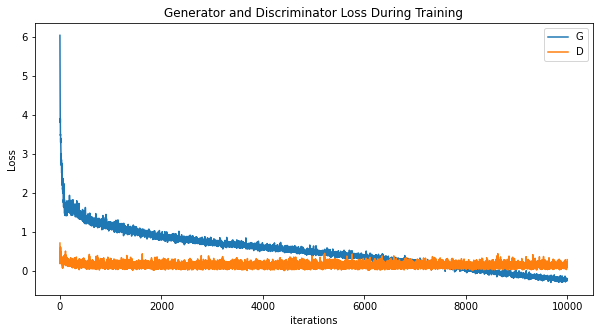

In [ ]:
# Losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

---

# 7. Use GAN to change hairstyles of popular celebrities available in the CelebA dataset

In this problem, we will take image and change hair styles as per the trained GAN in the previous step

## 7.1 : Save trained model (5 points)

We will implement a routine to save the trained generator and discrimantor models, so that we can simply load these later on for inference.

In [ ]:
def save_model(G: nn.Module,
               D: nn.Module,
               config,
               step):
    """
    Save the trained generator and discriminator
    """
    model_save_dir = config['model_save_dir']
    G_path = os.path.join(model_save_dir, '{}-G.ckpt'.format(step+1))
    D_path = os.path.join(model_save_dir, '{}-D.ckpt'.format(step+1))

    ################################################
    ##### CODE HERE
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)
    ################################################
    
    print('Saved model checkpoints into {}...'.format(model_save_dir))


## 7.2 : Load trained model (5 points)

We will implement a routine to load the trained generator and discrimantor models.

In [ ]:
def restore_model(resume_iters, model_save_dir):
    """
    Restore the trained generator and discriminator.
    """

    print('Loading the trained models from step {}...'.format(resume_iters))
    G_path = os.path.join(model_save_dir, '{}-G.ckpt'.format(resume_iters))
    D_path = os.path.join(model_save_dir, '{}-D.ckpt'.format(resume_iters))

    ################################################
    ##### CODE HERE
    G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
    D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))
    ################################################

    return G, D

## 7.3 Implement gradient penalty (10 points)

Given $y = f(x)$, we refer $ \frac{ dy }{ dx } $ as the gradient in this problem. We want to include a gradient penalty in the GAN loss. 
We can write gradient penalty $\ell_{gp}$ as 

$$
\ell_{gp} = \Bigg\|  \Big\| \frac{ dy }{ dx } \Big\|_2 - 1 \Bigg\|^2
$$

(Hint : Using ```grad``` function in the ```torch.autograd``` modules, compute the gradient penalty )

In [ ]:
def gradient_penalty(y, x):
    """
    Compute gradient penalty: (L2_norm(dy/dx) - 1)**2.
    """

    ################################################
    #####
    weight = torch.ones(y.size()).to(config['device'])
    dydx = torch.autograd.grad(outputs=y,
                               inputs=x,
                               grad_outputs=weight,
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]

    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    ################################################

    loss = torch.mean((dydx_l2norm-1)**2)
    return loss

## 7.4 Implement the discriminator loss (5 points)
Write a function that returns the discriminator loss written as :

$$
\ell_{discriminator} = \ell_{real} + \ell_{fake} + \lambda_{gp} \times \ell_{gp} +  \lambda_{cls} \times \ell_{cls}
$$

Note that we add an additional term associated with the generated data (its simple to compute so we do it for you :P ).

In [ ]:

def get_new_discriminator_loss(
    G: nn.Module,
    D: nn.Module,
    label_org: torch.Tensor,
    x_real: torch.Tensor,
    c_trg: torch.Tensor,
    lambda_cls: float,
    lambda_gp: float):
    """
    x_real = x_real.to(device)           # Input images.
    c_trg = c_trg.to(device)             # Target labels.
    label_org = label_org.to(device)     # Labels for computing classification loss.
    label_trg = label_trg.to(device)     # Labels for computing classification loss.
    """

    out_src, out_cls = D(x_real)
    d_loss_real = -torch.mean(out_src)
    ################################################
    ##### CODE HERE
    ##### classification loss between out_cls, label_org
    d_loss_cls = classification_loss(out_cls, label_org)
    ################################################

    # Compute loss with fake images.
    x_fake = G(x_real, c_trg)
    out_src, out_cls = D(x_fake.detach())
    d_loss_fake = torch.mean(out_src)

    # Compute loss for gradient penalty.
    alpha = torch.rand(x_real.size(0), 1, 1, 1).to(device)
    x_hat = (alpha * x_real.data + (1 - alpha) * x_fake.data).requires_grad_(True)
    out_src, _ = D(x_hat)
    ################################################
    ##### TODO CODE HERE
    ##### gradient penalty on y=out_src, x=x_hat
    d_loss_gp = gradient_penalty(out_src, x_hat)
    ################################################

    # Backward and optimize.
    d_loss = d_loss_real + d_loss_fake
    ################################################
    ##### CODE HERE
    ##### add remaining loss terms as described in the problem
    d_loss += lambda_cls * d_loss_cls
    d_loss += lambda_gp * d_loss_gp
    ################################################
    
    return d_loss, d_loss_real, d_loss_fake, d_loss_cls, d_loss_gp

## 7.5 : Initialize a larger GAN using ```get_experiment_configuration``` (10 points)

We will use three hair style attributes in this experiment.

We will train a larger GAN in this problem. First, lets get a larger generator and discriminator models (use more than 3 repeat blocks in the experiment configuration which will increase the number of residual blocks in both the models).

Initialize the generator and discriminator accordingly and get the optimizers.

In [ ]:

SELECTED_ATTRIBUTES = ['Black_Hair', 'Blond_Hair', 'Brown_Hair']

################################################
config = get_experiment_configuration(
    log_step=100,
    sample_step=1000,
    model_save_step=1000,
    batch_size=64,
    selected_attributes = SELECTED_ATTRIBUTES)

G = Generator(config['g_conv_dim'], config['c_dim'], config['g_repeat_num'])

D = Discriminator(config['image_size'], 
                  config['d_conv_dim'], 
                  config['c_dim'], 
                  config['d_repeat_num']) 

g_optimizer, d_optimizer = get_optimizers(G, D, 
                                          config['g_lr'], config['d_lr'], 
                                          config['beta1'], config['beta2'])

data_loader = get_loader(config, mode='train')

# Fetch fixed inputs for debugging.
data_iter = iter(data_loader)
x_fixed, c_org = next(data_iter)
x_fixed = x_fixed.to(device)
c_fixed_list = create_labels(c_org, config['c_dim'], config['selected_attributes'])

################################################

print_network(G, 'Generator')
print_network(D, 'Discriminator')
    
G = G.to(config['device'])
D = D.to(config['device'])





Please ensure you are using a GPU for computation
Will be using the following device for computation :  cuda
Finished preprocessing the CelebA dataset...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



Generator network 1.0
Sequential(
  (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ResidualBlock(
    (main): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

## 7.6 : Train the larger GAN (15 points)

At the heart of a GAN network is a minimax problem. Earlier we were optimizing the Generator and the Discriminator at the same speed. 

It turns out that in this case, its recommended that the generator is updated at a slower pace than the discriminator. 

One way to achieve this is to run the generator with smaller learning rate . Instead we want to use the same learning rates as before but we will update the generator every few iterations, i.e. discriminator will be trained in every iteration but the generator will be trained every 5 iterations or more specifically ```config['n_critic']``` number of iterations. Use this recommended value or update as per your intuition.

Note that your after every `config['sample_step']`, the code generates new samples in the directory indicated in the configuration. Please monitor this to see how your generated images look like.

The script also saves your model to the `config['model_save_dir']` every `config['mode_save_step']` so that you can resume training (in case your script crashes after making significant progress) and we can also restore this model when we generate new hairstyles on the test images.

Hopefully your results will be better with these updates.

This will take more than 10 hours to give you reasonable images. So start early.


In [ ]:
# Learning rate cache for decaying.
g_lr = config['g_lr']
d_lr = config['d_lr']

# Start training from scratch or resume training.
start_iters = 0
if config['resume_iters']:
    start_iters = config['resume_iters'] 
    G, D = restore_model(config['resume_iters'], config )

G_losses = []
D_losses = []
cur_g_loss = 0
cur_d_loss = 0

# Start training.
print('Start training...')
start_time = time.time()
for i in range(start_iters, config['num_iters']):
    # =================================================================================== #
    #                             1. Preprocess input data                                #
    # =================================================================================== #

    # Fetch real images and labels.
    try:
        x_real, label_org = next(data_iter)
    except:
        data_iter = iter(data_loader)
        x_real, label_org = next(data_iter)

    # Generate target domain labels randomly.
    rand_idx = torch.randperm(label_org.size(0))
    label_trg = label_org[rand_idx]

    c_org = label_org.clone()
    c_trg = label_trg.clone()

    x_real = x_real.to(device)           # Input images.
    c_org = c_org.to(device)             # Original labels.
    c_trg = c_trg.to(device)             # Target labels.
    label_org = label_org.to(device)     # Labels for computing classification loss.
    label_trg = label_trg.to(device)     # Labels for computing classification loss.

    # Train discriminator
    ################################################
    ##### CODE HERE
    ##### Get the discriminator loss and optimize discriminator
    (d_loss, d_loss_real,
     d_loss_fake, d_loss_cls,
     d_loss_gp) = get_new_discriminator_loss(G, D, label_org,
        x_real, c_trg,
        config['lambda_cls'],
        config['lambda_gp'])
    
    # Now Optimize discriminator
    ################################################
    reset_grad(g_optimizer, d_optimizer)
    d_loss.backward()
    d_optimizer.step()

    cur_d_loss = d_loss.item()
    # Logging.
    loss = {}
    loss['D/loss_real'] = d_loss_real.item()
    loss['D/loss_fake'] = d_loss_fake.item()
    loss['D/loss_cls'] = d_loss_cls.item()
    loss['D/loss_gp'] = d_loss_gp.item()
    
    # Train the generator                         
    ################################################
    ##### TODO CODE HERE
    ##### Get the generator loss and optimize generator (every n_critic iterations)
    (g_loss, g_loss_fake,
     g_loss_cls, g_loss_rec) = get_generator_loss(G, D,
        x_real, c_trg, c_org, label_trg,
        config['lambda_rec'],
        config['lambda_cls'])
    
    # Now Optimize generator
    g_loss.backward()
    g_optimizer.step()

    # Logging.
    loss['G/loss_fake'] = g_loss_fake.item()
    loss['G/loss_rec'] = g_loss_rec.item()
    loss['G/loss_cls'] = g_loss_cls.item()
    ################################################
        
    # Print out training information.
    if (i+1) % config['log_step']  == 0:
        et = time.time() - start_time
        et = str(datetime.timedelta(seconds=et))[:-7]
        log = "Elapsed [{}], Iteration [{}/{}]".format(et, i+1, config['num_iters'])
        for tag, value in loss.items():
            log += ", {}: {:.4f}".format(tag, value)
        print(log)

    # Translate fixed images for debugging.
    if (i+1) %  config['sample_step']  == 0:
        with torch.no_grad():
            x_fake_list = [x_fixed]
            for c_fixed in c_fixed_list:
                x_fake_list.append(G(x_fixed, c_fixed))
            x_concat = torch.cat(x_fake_list, dim=3)
            sample_path = os.path.join(config['sample_dir'], '{}-images.jpg'.format(i+1))
            save_image(denorm(x_concat.data.cpu()), sample_path, nrow=1, padding=0)
            print('Saved real and fake images into {}...'.format(sample_path))

    # Save model checkpoints.
    if (i+1) % config['model_save_step'] == 0:
        save_model(G, D, config, i)

    # Decay learning rates.
    if (i+1) % config['lr_update_step'] == 0 and (i+1) > (config['num_iters'] - config['num_iters_decay']):
        g_lr -= (config['g_lr'] / float(config['num_iters_decay']))
        d_lr -= (config['d_lr'] / float(config['num_iters_decay']))
        update_lr(g_optimizer, d_optimizer, g_lr, d_lr)
        print ('Decayed learning rates, g_lr: {}, d_lr: {}.'.format(g_lr, d_lr))

Start training...


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Elapsed [0:00:29], Iteration [100/200000], D/loss_real: -1.9901, D/loss_fake: 3.5162, D/loss_cls: 1.3864, D/loss_gp: 0.8088, G/loss_fake: 0.7713, G/loss_rec: 0.2724, G/loss_cls: 1.4210
Elapsed [0:00:58], Iteration [200/200000], D/loss_real: -0.0537, D/loss_fake: 0.2945, D/loss_cls: 1.9643, D/loss_gp: 0.7918, G/loss_fake: 3.7054, G/loss_rec: 0.2136, G/loss_cls: 1.9220
Elapsed [0:01:26], Iteration [300/200000], D/loss_real: 1.0828, D/loss_fake: -0.9845, D/loss_cls: 1.4153, D/loss_gp: 0.0107, G/loss_fake: 4.6033, G/loss_rec: 0.1940, G/loss_cls: 1.3641
Elapsed [0:01:55], Iteration [400/200000], D/loss_real: -0.5543, D/loss_fake: 0.9045, D/loss_cls: 1.6000, D/loss_gp: 0.6042, G/loss_fake: 2.7950, G/loss_rec: 0.2341, G/loss_cls: 1.5046
Elapsed [0:02:23], Iteration [500/200000], D/loss_real: -0.5624, D/loss_fake: 2.1796, D/loss_cls: 1.5813, D/loss_gp: 0.0993, G/loss_fake: 2.8362, G/loss_rec: 0.2200, G/loss_cls: 1.5903
Elapsed [0:02:51], Iteration [600/200000], D/loss_real: 0.4789, D/loss_fake

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [0:15:07], Iteration [3200/200000], D/loss_real: -1.9979, D/loss_fake: 1.9943, D/loss_cls: 1.4751, D/loss_gp: 0.0068, G/loss_fake: 0.3447, G/loss_rec: 0.1070, G/loss_cls: 1.4289
Elapsed [0:15:36], Iteration [3300/200000], D/loss_real: -2.0312, D/loss_fake: 2.2280, D/loss_cls: 1.3783, D/loss_gp: 0.0051, G/loss_fake: 0.0668, G/loss_rec: 0.1148, G/loss_cls: 1.2178
Elapsed [0:16:04], Iteration [3400/200000], D/loss_real: -1.8072, D/loss_fake: 1.9534, D/loss_cls: 1.3652, D/loss_gp: 0.0078, G/loss_fake: -0.0591, G/loss_rec: 0.1096, G/loss_cls: 1.1246
Elapsed [0:16:33], Iteration [3500/200000], D/loss_real: -2.3455, D/loss_fake: 2.3598, D/loss_cls: 1.1434, D/loss_gp: 0.0027, G/loss_fake: -0.5247, G/loss_rec: 0.1081, G/loss_cls: 1.0110
Elapsed [0:17:01], Iteration [3600/200000], D/loss_real: -2.5875, D/loss_fake: 2.7065, D/loss_cls: 1.1557, D/loss_gp: 0.0043, G/loss_fake: -0.4296, G/loss_rec: 0.1027, G/loss_cls: 0.9242
Elapsed [0:17:29], Iteration [3700/200000], D/loss_real: -2.4349, D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [0:30:17], Iteration [6400/200000], D/loss_real: -2.9930, D/loss_fake: 2.9589, D/loss_cls: 0.8204, D/loss_gp: 0.0027, G/loss_fake: -1.5189, G/loss_rec: 0.0894, G/loss_cls: 0.5151
Elapsed [0:30:45], Iteration [6500/200000], D/loss_real: -3.3160, D/loss_fake: 3.1628, D/loss_cls: 0.9850, D/loss_gp: 0.0035, G/loss_fake: -1.5354, G/loss_rec: 0.0881, G/loss_cls: 0.5090
Elapsed [0:31:13], Iteration [6600/200000], D/loss_real: -3.1961, D/loss_fake: 3.1373, D/loss_cls: 0.9293, D/loss_gp: 0.0040, G/loss_fake: -1.1888, G/loss_rec: 0.1029, G/loss_cls: 0.4533
Elapsed [0:31:41], Iteration [6700/200000], D/loss_real: -3.2031, D/loss_fake: 3.1245, D/loss_cls: 0.7335, D/loss_gp: 0.0036, G/loss_fake: -1.6390, G/loss_rec: 0.0889, G/loss_cls: 0.3971
Elapsed [0:32:10], Iteration [6800/200000], D/loss_real: -3.2663, D/loss_fake: 3.1482, D/loss_cls: 1.1565, D/loss_gp: 0.0028, G/loss_fake: -1.6294, G/loss_rec: 0.0868, G/loss_cls: 0.4231
Elapsed [0:32:38], Iteration [6900/200000], D/loss_real: -2.5302,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [0:44:53], Iteration [9500/200000], D/loss_real: -1.8264, D/loss_fake: 1.8822, D/loss_cls: 0.8291, D/loss_gp: 0.0034, G/loss_fake: -0.6061, G/loss_rec: 0.0815, G/loss_cls: 0.3280
Elapsed [0:45:21], Iteration [9600/200000], D/loss_real: -1.7000, D/loss_fake: 1.5645, D/loss_cls: 0.9671, D/loss_gp: 0.0040, G/loss_fake: -0.2962, G/loss_rec: 0.0889, G/loss_cls: 0.3359
Elapsed [0:45:49], Iteration [9700/200000], D/loss_real: -2.1419, D/loss_fake: 2.3434, D/loss_cls: 0.6073, D/loss_gp: 0.0058, G/loss_fake: -0.7731, G/loss_rec: 0.0895, G/loss_cls: 0.2795
Elapsed [0:46:17], Iteration [9800/200000], D/loss_real: -1.8023, D/loss_fake: 1.7021, D/loss_cls: 0.8324, D/loss_gp: 0.0055, G/loss_fake: -0.5035, G/loss_rec: 0.0763, G/loss_cls: 0.3464
Elapsed [0:46:45], Iteration [9900/200000], D/loss_real: -1.9362, D/loss_fake: 1.7411, D/loss_cls: 0.6625, D/loss_gp: 0.0042, G/loss_fake: -0.3265, G/loss_rec: 0.0868, G/loss_cls: 0.4137
Elapsed [0:47:13], Iteration [10000/200000], D/loss_real: -1.8736

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [0:59:57], Iteration [12700/200000], D/loss_real: -1.0683, D/loss_fake: 0.6795, D/loss_cls: 0.7263, D/loss_gp: 0.0073, G/loss_fake: 0.5584, G/loss_rec: 0.0832, G/loss_cls: 0.3236
Elapsed [1:00:25], Iteration [12800/200000], D/loss_real: -0.6579, D/loss_fake: 0.4831, D/loss_cls: 0.8042, D/loss_gp: 0.0098, G/loss_fake: 0.6363, G/loss_rec: 0.0736, G/loss_cls: 0.3012
Elapsed [1:00:53], Iteration [12900/200000], D/loss_real: -1.0787, D/loss_fake: 0.8850, D/loss_cls: 0.7521, D/loss_gp: 0.0071, G/loss_fake: 0.5033, G/loss_rec: 0.0803, G/loss_cls: 0.3200
Elapsed [1:01:21], Iteration [13000/200000], D/loss_real: -1.2883, D/loss_fake: 1.2076, D/loss_cls: 0.6420, D/loss_gp: 0.0038, G/loss_fake: -0.0453, G/loss_rec: 0.0734, G/loss_cls: 0.2885
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/13000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experime

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [1:15:01], Iteration [15900/200000], D/loss_real: -1.1613, D/loss_fake: 0.7548, D/loss_cls: 0.7104, D/loss_gp: 0.0039, G/loss_fake: 0.5870, G/loss_rec: 0.0801, G/loss_cls: 0.3141
Elapsed [1:15:29], Iteration [16000/200000], D/loss_real: -0.7399, D/loss_fake: 1.3603, D/loss_cls: 0.5826, D/loss_gp: 0.0049, G/loss_fake: 0.4939, G/loss_rec: 0.0798, G/loss_cls: 0.3279
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/16000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [1:15:58], Iteration [16100/200000], D/loss_real: -0.9270, D/loss_fake: 0.7808, D/loss_cls: 0.7080, D/loss_gp: 0.0039, G/loss_fake: 0.3861, G/loss_rec: 0.0733, G/loss_cls: 0.3735
Elapsed [1:16:27], Iteration [16200/200000], D/loss_real: -0.9293, D/loss_fake: 0.8302, D/loss_cls: 0.6040, D/loss_gp: 0.0040, G/loss_fake: 0.3833, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [1:29:38], Iteration [19000/200000], D/loss_real: -0.7146, D/loss_fake: 0.8423, D/loss_cls: 0.7369, D/loss_gp: 0.0038, G/loss_fake: 0.4014, G/loss_rec: 0.0740, G/loss_cls: 0.3077
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/19000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [1:30:07], Iteration [19100/200000], D/loss_real: -0.5069, D/loss_fake: 0.4267, D/loss_cls: 0.6840, D/loss_gp: 0.0030, G/loss_fake: 0.6727, G/loss_rec: 0.0698, G/loss_cls: 0.3307
Elapsed [1:30:35], Iteration [19200/200000], D/loss_real: -0.2338, D/loss_fake: 0.1976, D/loss_cls: 0.5741, D/loss_gp: 0.0077, G/loss_fake: 1.1879, G/loss_rec: 0.0821, G/loss_cls: 0.3264
Elapsed [1:31:03], Iteration [19300/200000], D/loss_real: -0.4066, D/loss_fake: 0.4240, D/loss_cls: 0.6031, D/loss_gp: 0.0061, G/loss_fake: 0.9079, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [1:44:43], Iteration [22200/200000], D/loss_real: -0.0544, D/loss_fake: 0.1752, D/loss_cls: 0.5284, D/loss_gp: 0.0064, G/loss_fake: 1.0207, G/loss_rec: 0.0727, G/loss_cls: 0.3910
Elapsed [1:45:11], Iteration [22300/200000], D/loss_real: -0.3088, D/loss_fake: 0.2757, D/loss_cls: 0.7812, D/loss_gp: 0.0043, G/loss_fake: 1.0457, G/loss_rec: 0.0742, G/loss_cls: 0.3666
Elapsed [1:45:39], Iteration [22400/200000], D/loss_real: -0.6796, D/loss_fake: 0.5888, D/loss_cls: 0.6743, D/loss_gp: 0.0033, G/loss_fake: 0.7305, G/loss_rec: 0.0716, G/loss_cls: 0.4299
Elapsed [1:46:07], Iteration [22500/200000], D/loss_real: -0.4648, D/loss_fake: 0.5177, D/loss_cls: 0.5597, D/loss_gp: 0.0046, G/loss_fake: 0.6576, G/loss_rec: 0.0681, G/loss_cls: 0.3050
Elapsed [1:46:35], Iteration [22600/200000], D/loss_real: -0.3071, D/loss_fake: 0.4129, D/loss_cls: 0.7092, D/loss_gp: 0.0026, G/loss_fake: 0.7869, G/loss_rec: 0.0660, G/loss_cls: 0.3813
Elapsed [1:47:04], Iteration [22700/200000], D/loss_real: -0.3886

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [1:59:47], Iteration [25400/200000], D/loss_real: -0.4265, D/loss_fake: 0.2073, D/loss_cls: 0.7518, D/loss_gp: 0.0049, G/loss_fake: 1.0462, G/loss_rec: 0.0700, G/loss_cls: 0.2785
Elapsed [2:00:15], Iteration [25500/200000], D/loss_real: -0.6777, D/loss_fake: 0.5039, D/loss_cls: 0.7463, D/loss_gp: 0.0050, G/loss_fake: 0.6963, G/loss_rec: 0.0630, G/loss_cls: 0.4181
Elapsed [2:00:43], Iteration [25600/200000], D/loss_real: -0.5513, D/loss_fake: 0.2749, D/loss_cls: 0.6344, D/loss_gp: 0.0040, G/loss_fake: 0.7982, G/loss_rec: 0.0697, G/loss_cls: 0.3228
Elapsed [2:01:12], Iteration [25700/200000], D/loss_real: -0.3113, D/loss_fake: 0.5252, D/loss_cls: 0.5595, D/loss_gp: 0.0092, G/loss_fake: 0.9186, G/loss_rec: 0.0689, G/loss_cls: 0.2130
Elapsed [2:01:40], Iteration [25800/200000], D/loss_real: -0.4902, D/loss_fake: 0.3484, D/loss_cls: 0.7745, D/loss_gp: 0.0046, G/loss_fake: 0.8706, G/loss_rec: 0.0644, G/loss_cls: 0.3882
Elapsed [2:02:08], Iteration [25900/200000], D/loss_real: -0.4610

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [2:14:23], Iteration [28500/200000], D/loss_real: 0.0430, D/loss_fake: -0.1821, D/loss_cls: 0.4870, D/loss_gp: 0.0045, G/loss_fake: 1.1991, G/loss_rec: 0.0660, G/loss_cls: 0.2331
Elapsed [2:14:51], Iteration [28600/200000], D/loss_real: -0.3129, D/loss_fake: 0.1025, D/loss_cls: 0.7667, D/loss_gp: 0.0060, G/loss_fake: 0.9082, G/loss_rec: 0.0622, G/loss_cls: 0.2644
Elapsed [2:15:19], Iteration [28700/200000], D/loss_real: -0.5851, D/loss_fake: 0.2502, D/loss_cls: 0.6418, D/loss_gp: 0.0083, G/loss_fake: 0.7143, G/loss_rec: 0.0626, G/loss_cls: 0.2179
Elapsed [2:15:48], Iteration [28800/200000], D/loss_real: 0.1219, D/loss_fake: -0.3489, D/loss_cls: 0.6134, D/loss_gp: 0.0051, G/loss_fake: 1.4511, G/loss_rec: 0.0653, G/loss_cls: 0.2995
Elapsed [2:16:16], Iteration [28900/200000], D/loss_real: -0.1780, D/loss_fake: -0.0235, D/loss_cls: 0.7200, D/loss_gp: 0.0069, G/loss_fake: 1.1955, G/loss_rec: 0.0663, G/loss_cls: 0.3961
Elapsed [2:16:44], Iteration [29000/200000], D/loss_real: -0.152

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [2:29:28], Iteration [31700/200000], D/loss_real: -0.5742, D/loss_fake: 0.4190, D/loss_cls: 0.6203, D/loss_gp: 0.0052, G/loss_fake: 0.7452, G/loss_rec: 0.0606, G/loss_cls: 0.3185
Elapsed [2:29:56], Iteration [31800/200000], D/loss_real: -0.4438, D/loss_fake: 0.5484, D/loss_cls: 0.6059, D/loss_gp: 0.0039, G/loss_fake: 0.6573, G/loss_rec: 0.0637, G/loss_cls: 0.3388
Elapsed [2:30:24], Iteration [31900/200000], D/loss_real: -0.4659, D/loss_fake: 0.1356, D/loss_cls: 0.7625, D/loss_gp: 0.0036, G/loss_fake: 0.9264, G/loss_rec: 0.0673, G/loss_cls: 0.3092
Elapsed [2:30:52], Iteration [32000/200000], D/loss_real: -0.2213, D/loss_fake: -0.0450, D/loss_cls: 0.6029, D/loss_gp: 0.0050, G/loss_fake: 1.1179, G/loss_rec: 0.0602, G/loss_cls: 0.2704
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/32000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experime

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [2:44:34], Iteration [34900/200000], D/loss_real: -0.3563, D/loss_fake: 0.2596, D/loss_cls: 0.5126, D/loss_gp: 0.0050, G/loss_fake: 0.7724, G/loss_rec: 0.0651, G/loss_cls: 0.2048
Elapsed [2:45:02], Iteration [35000/200000], D/loss_real: -0.5452, D/loss_fake: 0.4565, D/loss_cls: 0.6511, D/loss_gp: 0.0047, G/loss_fake: 0.6532, G/loss_rec: 0.0611, G/loss_cls: 0.2425
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/35000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [2:45:31], Iteration [35100/200000], D/loss_real: -0.3132, D/loss_fake: 0.1441, D/loss_cls: 0.6253, D/loss_gp: 0.0038, G/loss_fake: 0.9163, G/loss_rec: 0.0607, G/loss_cls: 0.2416
Elapsed [2:45:59], Iteration [35200/200000], D/loss_real: -0.3461, D/loss_fake: 0.0265, D/loss_cls: 0.5658, D/loss_gp: 0.0054, G/loss_fake: 0.8533, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [2:59:11], Iteration [38000/200000], D/loss_real: -0.4438, D/loss_fake: 0.3203, D/loss_cls: 0.4429, D/loss_gp: 0.0038, G/loss_fake: 0.6176, G/loss_rec: 0.0606, G/loss_cls: 0.2944
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/38000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [2:59:40], Iteration [38100/200000], D/loss_real: -0.4402, D/loss_fake: 0.3310, D/loss_cls: 0.7490, D/loss_gp: 0.0045, G/loss_fake: 0.7661, G/loss_rec: 0.0565, G/loss_cls: 0.3626
Elapsed [3:00:08], Iteration [38200/200000], D/loss_real: -0.3288, D/loss_fake: 0.3188, D/loss_cls: 0.5140, D/loss_gp: 0.0031, G/loss_fake: 0.9085, G/loss_rec: 0.0696, G/loss_cls: 0.2879
Elapsed [3:00:37], Iteration [38300/200000], D/loss_real: -0.3687, D/loss_fake: 0.3050, D/loss_cls: 0.7628, D/loss_gp: 0.0049, G/loss_fake: 0.7683, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [3:14:17], Iteration [41200/200000], D/loss_real: -0.2706, D/loss_fake: 0.2043, D/loss_cls: 0.7066, D/loss_gp: 0.0047, G/loss_fake: 0.7811, G/loss_rec: 0.0592, G/loss_cls: 0.2544
Elapsed [3:14:45], Iteration [41300/200000], D/loss_real: -0.7120, D/loss_fake: 0.6261, D/loss_cls: 0.5218, D/loss_gp: 0.0050, G/loss_fake: 0.5988, G/loss_rec: 0.0643, G/loss_cls: 0.2639
Elapsed [3:15:13], Iteration [41400/200000], D/loss_real: -0.0783, D/loss_fake: 0.0708, D/loss_cls: 0.6383, D/loss_gp: 0.0031, G/loss_fake: 0.8741, G/loss_rec: 0.0551, G/loss_cls: 0.2808
Elapsed [3:15:41], Iteration [41500/200000], D/loss_real: -0.6752, D/loss_fake: 0.3262, D/loss_cls: 0.5736, D/loss_gp: 0.0043, G/loss_fake: 0.6828, G/loss_rec: 0.0621, G/loss_cls: 0.2234
Elapsed [3:16:10], Iteration [41600/200000], D/loss_real: -0.4028, D/loss_fake: 0.1908, D/loss_cls: 0.4866, D/loss_gp: 0.0039, G/loss_fake: 0.7823, G/loss_rec: 0.0601, G/loss_cls: 0.3490
Elapsed [3:16:38], Iteration [41700/200000], D/loss_real: -0.3584

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [3:29:22], Iteration [44400/200000], D/loss_real: -0.3239, D/loss_fake: 0.0546, D/loss_cls: 0.7390, D/loss_gp: 0.0038, G/loss_fake: 1.0202, G/loss_rec: 0.0569, G/loss_cls: 0.2961
Elapsed [3:29:51], Iteration [44500/200000], D/loss_real: -0.5443, D/loss_fake: 0.3308, D/loss_cls: 0.5843, D/loss_gp: 0.0036, G/loss_fake: 0.7229, G/loss_rec: 0.0564, G/loss_cls: 0.3752
Elapsed [3:30:19], Iteration [44600/200000], D/loss_real: -0.4602, D/loss_fake: 0.1288, D/loss_cls: 0.6032, D/loss_gp: 0.0032, G/loss_fake: 0.7961, G/loss_rec: 0.0553, G/loss_cls: 0.2535
Elapsed [3:30:47], Iteration [44700/200000], D/loss_real: -0.5775, D/loss_fake: 0.5524, D/loss_cls: 0.7102, D/loss_gp: 0.0041, G/loss_fake: 0.5150, G/loss_rec: 0.0609, G/loss_cls: 0.3987
Elapsed [3:31:15], Iteration [44800/200000], D/loss_real: -0.4676, D/loss_fake: 0.3040, D/loss_cls: 0.5149, D/loss_gp: 0.0036, G/loss_fake: 0.6364, G/loss_rec: 0.0550, G/loss_cls: 0.2634
Elapsed [3:31:44], Iteration [44900/200000], D/loss_real: -0.2655

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [3:44:00], Iteration [47500/200000], D/loss_real: -0.4392, D/loss_fake: 0.1951, D/loss_cls: 0.4720, D/loss_gp: 0.0034, G/loss_fake: 0.7230, G/loss_rec: 0.0546, G/loss_cls: 0.2320
Elapsed [3:44:29], Iteration [47600/200000], D/loss_real: -0.5784, D/loss_fake: 0.3086, D/loss_cls: 0.5618, D/loss_gp: 0.0032, G/loss_fake: 0.7093, G/loss_rec: 0.0596, G/loss_cls: 0.1682
Elapsed [3:44:57], Iteration [47700/200000], D/loss_real: -0.7033, D/loss_fake: 0.4418, D/loss_cls: 0.6244, D/loss_gp: 0.0059, G/loss_fake: 0.4327, G/loss_rec: 0.0615, G/loss_cls: 0.2201
Elapsed [3:45:25], Iteration [47800/200000], D/loss_real: -0.5194, D/loss_fake: 0.2466, D/loss_cls: 0.5766, D/loss_gp: 0.0028, G/loss_fake: 0.8338, G/loss_rec: 0.0597, G/loss_cls: 0.2507
Elapsed [3:45:54], Iteration [47900/200000], D/loss_real: -0.6906, D/loss_fake: 0.5549, D/loss_cls: 0.4663, D/loss_gp: 0.0035, G/loss_fake: 0.5245, G/loss_rec: 0.0618, G/loss_cls: 0.2229
Elapsed [3:46:22], Iteration [48000/200000], D/loss_real: -0.3983

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [3:59:07], Iteration [50700/200000], D/loss_real: -0.4899, D/loss_fake: 0.2484, D/loss_cls: 0.4404, D/loss_gp: 0.0047, G/loss_fake: 0.6516, G/loss_rec: 0.0528, G/loss_cls: 0.2487
Elapsed [3:59:35], Iteration [50800/200000], D/loss_real: -0.2777, D/loss_fake: 0.1200, D/loss_cls: 0.5630, D/loss_gp: 0.0043, G/loss_fake: 0.9048, G/loss_rec: 0.0556, G/loss_cls: 0.3051
Elapsed [4:00:03], Iteration [50900/200000], D/loss_real: -0.3828, D/loss_fake: 0.1901, D/loss_cls: 0.5699, D/loss_gp: 0.0046, G/loss_fake: 0.7831, G/loss_rec: 0.0558, G/loss_cls: 0.2980
Elapsed [4:00:32], Iteration [51000/200000], D/loss_real: -0.3482, D/loss_fake: 0.2400, D/loss_cls: 0.5875, D/loss_gp: 0.0045, G/loss_fake: 0.7388, G/loss_rec: 0.0526, G/loss_cls: 0.2518
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/51000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experimen

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [4:14:13], Iteration [53900/200000], D/loss_real: -0.5543, D/loss_fake: 0.2345, D/loss_cls: 0.5292, D/loss_gp: 0.0049, G/loss_fake: 0.6898, G/loss_rec: 0.0544, G/loss_cls: 0.2482
Elapsed [4:14:41], Iteration [54000/200000], D/loss_real: -0.4625, D/loss_fake: 0.1331, D/loss_cls: 0.5490, D/loss_gp: 0.0043, G/loss_fake: 0.9199, G/loss_rec: 0.0601, G/loss_cls: 0.2222
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/54000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [4:15:10], Iteration [54100/200000], D/loss_real: -0.5409, D/loss_fake: 0.3323, D/loss_cls: 0.5035, D/loss_gp: 0.0021, G/loss_fake: 0.5693, G/loss_rec: 0.0542, G/loss_cls: 0.2053
Elapsed [4:15:38], Iteration [54200/200000], D/loss_real: -0.5557, D/loss_fake: 0.3486, D/loss_cls: 0.4916, D/loss_gp: 0.0046, G/loss_fake: 0.5998, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [4:28:50], Iteration [57000/200000], D/loss_real: -0.5853, D/loss_fake: 0.3250, D/loss_cls: 0.5302, D/loss_gp: 0.0038, G/loss_fake: 0.5816, G/loss_rec: 0.0548, G/loss_cls: 0.2910
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/57000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [4:29:19], Iteration [57100/200000], D/loss_real: -0.7519, D/loss_fake: 0.6508, D/loss_cls: 0.7454, D/loss_gp: 0.0041, G/loss_fake: 0.3484, G/loss_rec: 0.0553, G/loss_cls: 0.2024
Elapsed [4:29:48], Iteration [57200/200000], D/loss_real: -0.8123, D/loss_fake: 0.6100, D/loss_cls: 0.5813, D/loss_gp: 0.0049, G/loss_fake: 0.3286, G/loss_rec: 0.0573, G/loss_cls: 0.2201
Elapsed [4:30:16], Iteration [57300/200000], D/loss_real: -0.6142, D/loss_fake: 0.3247, D/loss_cls: 0.4942, D/loss_gp: 0.0048, G/loss_fake: 0.5784, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [4:43:58], Iteration [60200/200000], D/loss_real: -0.3282, D/loss_fake: 0.1174, D/loss_cls: 0.3903, D/loss_gp: 0.0027, G/loss_fake: 0.7260, G/loss_rec: 0.0524, G/loss_cls: 0.1754
Elapsed [4:44:26], Iteration [60300/200000], D/loss_real: -0.4115, D/loss_fake: 0.1773, D/loss_cls: 0.3791, D/loss_gp: 0.0015, G/loss_fake: 0.5979, G/loss_rec: 0.0561, G/loss_cls: 0.2164
Elapsed [4:44:55], Iteration [60400/200000], D/loss_real: -0.6382, D/loss_fake: 0.4108, D/loss_cls: 0.4427, D/loss_gp: 0.0044, G/loss_fake: 0.5893, G/loss_rec: 0.0538, G/loss_cls: 0.2685
Elapsed [4:45:23], Iteration [60500/200000], D/loss_real: -0.5270, D/loss_fake: 0.4561, D/loss_cls: 0.5589, D/loss_gp: 0.0029, G/loss_fake: 0.3453, G/loss_rec: 0.0523, G/loss_cls: 0.1736
Elapsed [4:45:51], Iteration [60600/200000], D/loss_real: -0.3495, D/loss_fake: 0.1958, D/loss_cls: 0.4398, D/loss_gp: 0.0029, G/loss_fake: 0.6450, G/loss_rec: 0.0528, G/loss_cls: 0.2553
Elapsed [4:46:19], Iteration [60700/200000], D/loss_real: -0.2358

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [4:59:05], Iteration [63400/200000], D/loss_real: -0.3894, D/loss_fake: 0.1904, D/loss_cls: 0.5733, D/loss_gp: 0.0021, G/loss_fake: 0.7245, G/loss_rec: 0.0533, G/loss_cls: 0.2370
Elapsed [4:59:34], Iteration [63500/200000], D/loss_real: -0.3276, D/loss_fake: 0.2168, D/loss_cls: 0.6564, D/loss_gp: 0.0041, G/loss_fake: 0.6069, G/loss_rec: 0.0495, G/loss_cls: 0.1823
Elapsed [5:00:02], Iteration [63600/200000], D/loss_real: -0.5258, D/loss_fake: 0.4502, D/loss_cls: 0.4243, D/loss_gp: 0.0026, G/loss_fake: 0.4580, G/loss_rec: 0.0527, G/loss_cls: 0.2589
Elapsed [5:00:30], Iteration [63700/200000], D/loss_real: -0.6937, D/loss_fake: 0.5738, D/loss_cls: 0.4962, D/loss_gp: 0.0024, G/loss_fake: 0.2594, G/loss_rec: 0.0541, G/loss_cls: 0.2271
Elapsed [5:00:58], Iteration [63800/200000], D/loss_real: -0.2261, D/loss_fake: 0.0378, D/loss_cls: 0.3906, D/loss_gp: 0.0052, G/loss_fake: 0.9181, G/loss_rec: 0.0532, G/loss_cls: 0.3039
Elapsed [5:01:27], Iteration [63900/200000], D/loss_real: -0.2519

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [5:13:44], Iteration [66500/200000], D/loss_real: -0.1989, D/loss_fake: -0.0487, D/loss_cls: 0.5830, D/loss_gp: 0.0054, G/loss_fake: 1.0194, G/loss_rec: 0.0540, G/loss_cls: 0.3178
Elapsed [5:14:13], Iteration [66600/200000], D/loss_real: -0.5215, D/loss_fake: 0.2687, D/loss_cls: 0.4028, D/loss_gp: 0.0043, G/loss_fake: 0.6324, G/loss_rec: 0.0509, G/loss_cls: 0.2786
Elapsed [5:14:41], Iteration [66700/200000], D/loss_real: -0.6610, D/loss_fake: 0.4558, D/loss_cls: 0.5246, D/loss_gp: 0.0026, G/loss_fake: 0.4422, G/loss_rec: 0.0516, G/loss_cls: 0.1597
Elapsed [5:15:09], Iteration [66800/200000], D/loss_real: -0.6064, D/loss_fake: 0.3306, D/loss_cls: 0.5663, D/loss_gp: 0.0038, G/loss_fake: 0.5259, G/loss_rec: 0.0530, G/loss_cls: 0.1911
Elapsed [5:15:37], Iteration [66900/200000], D/loss_real: -0.5021, D/loss_fake: 0.3850, D/loss_cls: 0.4908, D/loss_gp: 0.0032, G/loss_fake: 0.4591, G/loss_rec: 0.0491, G/loss_cls: 0.1895
Elapsed [5:16:06], Iteration [67000/200000], D/loss_real: -0.376

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [5:28:52], Iteration [69700/200000], D/loss_real: -0.1411, D/loss_fake: -0.1160, D/loss_cls: 0.4802, D/loss_gp: 0.0047, G/loss_fake: 0.9303, G/loss_rec: 0.0522, G/loss_cls: 0.2183
Elapsed [5:29:20], Iteration [69800/200000], D/loss_real: -0.5804, D/loss_fake: 0.2107, D/loss_cls: 0.5203, D/loss_gp: 0.0097, G/loss_fake: 0.6702, G/loss_rec: 0.0506, G/loss_cls: 0.3157
Elapsed [5:29:48], Iteration [69900/200000], D/loss_real: -0.5322, D/loss_fake: 0.4572, D/loss_cls: 0.4751, D/loss_gp: 0.0037, G/loss_fake: 0.3146, G/loss_rec: 0.0473, G/loss_cls: 0.1634
Elapsed [5:30:16], Iteration [70000/200000], D/loss_real: -0.5180, D/loss_fake: 0.3551, D/loss_cls: 0.6970, D/loss_gp: 0.0036, G/loss_fake: 0.5424, G/loss_rec: 0.0491, G/loss_cls: 0.2344
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/70000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experime

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [5:43:59], Iteration [72900/200000], D/loss_real: -0.7861, D/loss_fake: 0.5756, D/loss_cls: 0.7211, D/loss_gp: 0.0053, G/loss_fake: 0.3808, G/loss_rec: 0.0490, G/loss_cls: 0.3217
Elapsed [5:44:27], Iteration [73000/200000], D/loss_real: -0.8019, D/loss_fake: 0.6374, D/loss_cls: 0.4521, D/loss_gp: 0.0031, G/loss_fake: 0.2683, G/loss_rec: 0.0496, G/loss_cls: 0.2950
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/73000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [5:44:56], Iteration [73100/200000], D/loss_real: -0.7191, D/loss_fake: 0.4341, D/loss_cls: 0.5332, D/loss_gp: 0.0053, G/loss_fake: 0.3428, G/loss_rec: 0.0514, G/loss_cls: 0.2441
Elapsed [5:45:24], Iteration [73200/200000], D/loss_real: -0.3464, D/loss_fake: 0.1833, D/loss_cls: 0.4268, D/loss_gp: 0.0043, G/loss_fake: 0.4987, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [5:58:37], Iteration [76000/200000], D/loss_real: -0.5719, D/loss_fake: 0.4989, D/loss_cls: 0.3806, D/loss_gp: 0.0051, G/loss_fake: 0.3102, G/loss_rec: 0.0494, G/loss_cls: 0.1659
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/76000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [5:59:07], Iteration [76100/200000], D/loss_real: -0.6417, D/loss_fake: 0.4969, D/loss_cls: 0.3285, D/loss_gp: 0.0033, G/loss_fake: 0.3245, G/loss_rec: 0.0495, G/loss_cls: 0.2365
Elapsed [5:59:35], Iteration [76200/200000], D/loss_real: -0.6658, D/loss_fake: 0.4817, D/loss_cls: 0.4657, D/loss_gp: 0.0045, G/loss_fake: 0.6022, G/loss_rec: 0.0554, G/loss_cls: 0.3033
Elapsed [6:00:03], Iteration [76300/200000], D/loss_real: -0.6204, D/loss_fake: 0.3231, D/loss_cls: 0.3896, D/loss_gp: 0.0029, G/loss_fake: 0.6373, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [6:13:45], Iteration [79200/200000], D/loss_real: -0.6664, D/loss_fake: 0.4440, D/loss_cls: 0.4560, D/loss_gp: 0.0037, G/loss_fake: 0.4780, G/loss_rec: 0.0526, G/loss_cls: 0.1895
Elapsed [6:14:13], Iteration [79300/200000], D/loss_real: -0.3423, D/loss_fake: 0.1752, D/loss_cls: 0.2885, D/loss_gp: 0.0045, G/loss_fake: 0.6927, G/loss_rec: 0.0497, G/loss_cls: 0.2628
Elapsed [6:14:42], Iteration [79400/200000], D/loss_real: -0.6297, D/loss_fake: 0.3388, D/loss_cls: 0.4765, D/loss_gp: 0.0077, G/loss_fake: 0.5819, G/loss_rec: 0.0487, G/loss_cls: 0.2044
Elapsed [6:15:10], Iteration [79500/200000], D/loss_real: -0.2540, D/loss_fake: 0.0858, D/loss_cls: 0.3852, D/loss_gp: 0.0027, G/loss_fake: 0.8036, G/loss_rec: 0.0508, G/loss_cls: 0.1803
Elapsed [6:15:38], Iteration [79600/200000], D/loss_real: -0.4724, D/loss_fake: 0.2315, D/loss_cls: 0.4508, D/loss_gp: 0.0028, G/loss_fake: 0.7236, G/loss_rec: 0.0526, G/loss_cls: 0.2508
Elapsed [6:16:06], Iteration [79700/200000], D/loss_real: -0.8206

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [6:28:52], Iteration [82400/200000], D/loss_real: -0.5318, D/loss_fake: 0.3670, D/loss_cls: 0.5420, D/loss_gp: 0.0055, G/loss_fake: 0.4984, G/loss_rec: 0.0507, G/loss_cls: 0.3007
Elapsed [6:29:21], Iteration [82500/200000], D/loss_real: -0.4385, D/loss_fake: 0.2939, D/loss_cls: 0.4012, D/loss_gp: 0.0068, G/loss_fake: 0.6434, G/loss_rec: 0.0492, G/loss_cls: 0.2628
Elapsed [6:29:49], Iteration [82600/200000], D/loss_real: -0.9151, D/loss_fake: 0.6530, D/loss_cls: 0.3327, D/loss_gp: 0.0028, G/loss_fake: 0.1522, G/loss_rec: 0.0503, G/loss_cls: 0.2212
Elapsed [6:30:17], Iteration [82700/200000], D/loss_real: -0.5957, D/loss_fake: 0.4314, D/loss_cls: 0.4201, D/loss_gp: 0.0054, G/loss_fake: 0.2253, G/loss_rec: 0.0466, G/loss_cls: 0.1632
Elapsed [6:30:45], Iteration [82800/200000], D/loss_real: -0.4344, D/loss_fake: 0.1591, D/loss_cls: 0.4169, D/loss_gp: 0.0061, G/loss_fake: 0.7040, G/loss_rec: 0.0563, G/loss_cls: 0.2259
Elapsed [6:31:14], Iteration [82900/200000], D/loss_real: -0.9375

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [6:43:31], Iteration [85500/200000], D/loss_real: -0.7871, D/loss_fake: 0.4991, D/loss_cls: 0.3210, D/loss_gp: 0.0040, G/loss_fake: 0.3253, G/loss_rec: 0.0492, G/loss_cls: 0.1428
Elapsed [6:44:00], Iteration [85600/200000], D/loss_real: -0.5371, D/loss_fake: 0.2804, D/loss_cls: 0.2981, D/loss_gp: 0.0037, G/loss_fake: 0.6036, G/loss_rec: 0.0514, G/loss_cls: 0.2056
Elapsed [6:44:28], Iteration [85700/200000], D/loss_real: -0.7337, D/loss_fake: 0.2969, D/loss_cls: 0.4588, D/loss_gp: 0.0049, G/loss_fake: 0.4986, G/loss_rec: 0.0511, G/loss_cls: 0.1811
Elapsed [6:44:56], Iteration [85800/200000], D/loss_real: -1.0376, D/loss_fake: 0.8053, D/loss_cls: 0.2712, D/loss_gp: 0.0031, G/loss_fake: 0.2525, G/loss_rec: 0.0530, G/loss_cls: 0.3379
Elapsed [6:45:25], Iteration [85900/200000], D/loss_real: -0.5986, D/loss_fake: 0.3493, D/loss_cls: 0.4209, D/loss_gp: 0.0036, G/loss_fake: 0.5113, G/loss_rec: 0.0501, G/loss_cls: 0.2354
Elapsed [6:45:53], Iteration [86000/200000], D/loss_real: -1.0470

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [6:58:38], Iteration [88700/200000], D/loss_real: -0.3740, D/loss_fake: 0.1794, D/loss_cls: 0.3073, D/loss_gp: 0.0054, G/loss_fake: 0.6691, G/loss_rec: 0.0530, G/loss_cls: 0.1521
Elapsed [6:59:07], Iteration [88800/200000], D/loss_real: -0.4604, D/loss_fake: 0.3205, D/loss_cls: 0.2310, D/loss_gp: 0.0037, G/loss_fake: 0.4014, G/loss_rec: 0.0491, G/loss_cls: 0.1444
Elapsed [6:59:35], Iteration [88900/200000], D/loss_real: -0.8627, D/loss_fake: 0.7071, D/loss_cls: 0.3058, D/loss_gp: 0.0029, G/loss_fake: 0.1402, G/loss_rec: 0.0507, G/loss_cls: 0.1293
Elapsed [7:00:03], Iteration [89000/200000], D/loss_real: -0.4463, D/loss_fake: 0.2531, D/loss_cls: 0.4488, D/loss_gp: 0.0047, G/loss_fake: 0.7708, G/loss_rec: 0.0498, G/loss_cls: 0.2778
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/89000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experimen

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [7:13:46], Iteration [91900/200000], D/loss_real: -0.8012, D/loss_fake: 0.4959, D/loss_cls: 0.4788, D/loss_gp: 0.0031, G/loss_fake: 0.5042, G/loss_rec: 0.0519, G/loss_cls: 0.2027
Elapsed [7:14:14], Iteration [92000/200000], D/loss_real: -0.2610, D/loss_fake: -0.0126, D/loss_cls: 0.3346, D/loss_gp: 0.0033, G/loss_fake: 0.7131, G/loss_rec: 0.0486, G/loss_cls: 0.1944
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/92000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [7:14:43], Iteration [92100/200000], D/loss_real: -0.6817, D/loss_fake: 0.3934, D/loss_cls: 0.4720, D/loss_gp: 0.0044, G/loss_fake: 0.3736, G/loss_rec: 0.0514, G/loss_cls: 0.1944
Elapsed [7:15:11], Iteration [92200/200000], D/loss_real: -0.6999, D/loss_fake: 0.3602, D/loss_cls: 0.3727, D/loss_gp: 0.0048, G/loss_fake: 0.4310, G/loss_r

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [7:28:25], Iteration [95000/200000], D/loss_real: -0.6858, D/loss_fake: 0.3420, D/loss_cls: 0.3955, D/loss_gp: 0.0051, G/loss_fake: 0.3865, G/loss_rec: 0.0514, G/loss_cls: 0.1892
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/95000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [7:28:54], Iteration [95100/200000], D/loss_real: -0.4863, D/loss_fake: 0.3415, D/loss_cls: 0.3947, D/loss_gp: 0.0060, G/loss_fake: 0.4952, G/loss_rec: 0.0549, G/loss_cls: 0.1901
Elapsed [7:29:22], Iteration [95200/200000], D/loss_real: -1.0880, D/loss_fake: 0.8326, D/loss_cls: 0.5120, D/loss_gp: 0.0035, G/loss_fake: 0.0057, G/loss_rec: 0.0503, G/loss_cls: 0.1400
Elapsed [7:29:50], Iteration [95300/200000], D/loss_real: -0.6237, D/loss_fake: 0.3338, D/loss_cls: 0.3656, D/loss_gp: 0.0076, G/loss_fake: 0.6862, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [7:43:32], Iteration [98200/200000], D/loss_real: -0.8943, D/loss_fake: 0.6409, D/loss_cls: 0.4421, D/loss_gp: 0.0047, G/loss_fake: 0.0856, G/loss_rec: 0.0492, G/loss_cls: 0.2361
Elapsed [7:44:00], Iteration [98300/200000], D/loss_real: -1.0342, D/loss_fake: 0.7211, D/loss_cls: 0.3014, D/loss_gp: 0.0048, G/loss_fake: 0.1818, G/loss_rec: 0.0472, G/loss_cls: 0.2711
Elapsed [7:44:28], Iteration [98400/200000], D/loss_real: -0.8965, D/loss_fake: 0.5825, D/loss_cls: 0.4756, D/loss_gp: 0.0070, G/loss_fake: 0.2480, G/loss_rec: 0.0526, G/loss_cls: 0.2139
Elapsed [7:44:56], Iteration [98500/200000], D/loss_real: -1.0008, D/loss_fake: 0.7028, D/loss_cls: 0.3748, D/loss_gp: 0.0036, G/loss_fake: 0.1540, G/loss_rec: 0.0501, G/loss_cls: 0.1927
Elapsed [7:45:25], Iteration [98600/200000], D/loss_real: -0.4661, D/loss_fake: 0.0712, D/loss_cls: 0.2519, D/loss_gp: 0.0040, G/loss_fake: 0.7144, G/loss_rec: 0.0531, G/loss_cls: 0.2212
Elapsed [7:45:53], Iteration [98700/200000], D/loss_real: -0.8819

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [7:58:37], Iteration [101400/200000], D/loss_real: -0.8811, D/loss_fake: 0.5783, D/loss_cls: 0.2530, D/loss_gp: 0.0054, G/loss_fake: 0.0781, G/loss_rec: 0.0485, G/loss_cls: 0.1085
Elapsed [7:59:06], Iteration [101500/200000], D/loss_real: -1.0787, D/loss_fake: 0.7621, D/loss_cls: 0.2989, D/loss_gp: 0.0058, G/loss_fake: 0.0682, G/loss_rec: 0.0480, G/loss_cls: 0.1572
Elapsed [7:59:34], Iteration [101600/200000], D/loss_real: -0.6829, D/loss_fake: 0.4858, D/loss_cls: 0.2122, D/loss_gp: 0.0055, G/loss_fake: 0.3304, G/loss_rec: 0.0466, G/loss_cls: 0.2176
Elapsed [8:00:02], Iteration [101700/200000], D/loss_real: -0.9812, D/loss_fake: 0.7958, D/loss_cls: 0.2158, D/loss_gp: 0.0039, G/loss_fake: 0.2075, G/loss_rec: 0.0539, G/loss_cls: 0.1667
Elapsed [8:00:30], Iteration [101800/200000], D/loss_real: -1.2517, D/loss_fake: 1.0151, D/loss_cls: 0.2925, D/loss_gp: 0.0030, G/loss_fake: -0.0447, G/loss_rec: 0.0522, G/loss_cls: 0.2918
Elapsed [8:00:58], Iteration [101900/200000], D/loss_real: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [8:13:15], Iteration [104500/200000], D/loss_real: -0.9733, D/loss_fake: 0.7545, D/loss_cls: 0.3145, D/loss_gp: 0.0064, G/loss_fake: 0.1286, G/loss_rec: 0.0522, G/loss_cls: 0.2579
Elapsed [8:13:43], Iteration [104600/200000], D/loss_real: -1.0406, D/loss_fake: 0.7023, D/loss_cls: 0.1557, D/loss_gp: 0.0037, G/loss_fake: 0.2233, G/loss_rec: 0.0473, G/loss_cls: 0.3461
Elapsed [8:14:11], Iteration [104700/200000], D/loss_real: -0.8061, D/loss_fake: 0.5715, D/loss_cls: 0.1790, D/loss_gp: 0.0069, G/loss_fake: 0.4900, G/loss_rec: 0.0536, G/loss_cls: 0.1855
Elapsed [8:14:39], Iteration [104800/200000], D/loss_real: -0.9634, D/loss_fake: 0.5943, D/loss_cls: 0.3787, D/loss_gp: 0.0039, G/loss_fake: 0.2339, G/loss_rec: 0.0492, G/loss_cls: 0.2778
Elapsed [8:15:08], Iteration [104900/200000], D/loss_real: -0.8556, D/loss_fake: 0.4907, D/loss_cls: 0.3483, D/loss_gp: 0.0040, G/loss_fake: 0.3978, G/loss_rec: 0.0512, G/loss_cls: 0.1644
Elapsed [8:15:36], Iteration [105000/200000], D/loss_real: -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [8:28:20], Iteration [107700/200000], D/loss_real: -1.5233, D/loss_fake: 1.1663, D/loss_cls: 0.2372, D/loss_gp: 0.0088, G/loss_fake: -0.4705, G/loss_rec: 0.0487, G/loss_cls: 0.1053
Elapsed [8:28:48], Iteration [107800/200000], D/loss_real: -0.7644, D/loss_fake: 0.4961, D/loss_cls: 0.4164, D/loss_gp: 0.0044, G/loss_fake: 0.2586, G/loss_rec: 0.0494, G/loss_cls: 0.1949
Elapsed [8:29:17], Iteration [107900/200000], D/loss_real: -0.8706, D/loss_fake: 0.5502, D/loss_cls: 0.3637, D/loss_gp: 0.0052, G/loss_fake: 0.5337, G/loss_rec: 0.0514, G/loss_cls: 0.1974
Elapsed [8:29:45], Iteration [108000/200000], D/loss_real: -0.5445, D/loss_fake: 0.2735, D/loss_cls: 0.2912, D/loss_gp: 0.0045, G/loss_fake: 0.5431, G/loss_rec: 0.0482, G/loss_cls: 0.1647
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/108000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-exp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [8:43:26], Iteration [110900/200000], D/loss_real: -1.5326, D/loss_fake: 1.2412, D/loss_cls: 0.2663, D/loss_gp: 0.0062, G/loss_fake: -0.1160, G/loss_rec: 0.0557, G/loss_cls: 0.2482
Elapsed [8:43:54], Iteration [111000/200000], D/loss_real: -1.1509, D/loss_fake: 0.8573, D/loss_cls: 0.1802, D/loss_gp: 0.0062, G/loss_fake: 0.3248, G/loss_rec: 0.0524, G/loss_cls: 0.3253
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/111000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.998899999999998e-05, d_lr: 9.998899999999998e-05.
Elapsed [8:44:23], Iteration [111100/200000], D/loss_real: -0.8755, D/loss_fake: 0.5333, D/loss_cls: 0.4232, D/loss_gp: 0.0038, G/loss_fake: 0.2436, G/loss_rec: 0.0517, G/loss_cls: 0.1477
Elapsed [8:44:52], Iteration [111200/200000], D/loss_real: -1.2849, D/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [8:58:04], Iteration [114000/200000], D/loss_real: -1.5198, D/loss_fake: 1.0348, D/loss_cls: 0.3201, D/loss_gp: 0.0060, G/loss_fake: -0.4885, G/loss_rec: 0.0480, G/loss_cls: 0.1616
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/114000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.998599999999997e-05, d_lr: 9.998599999999997e-05.
Elapsed [8:58:33], Iteration [114100/200000], D/loss_real: -1.0185, D/loss_fake: 0.5506, D/loss_cls: 0.2314, D/loss_gp: 0.0049, G/loss_fake: 0.4671, G/loss_rec: 0.0520, G/loss_cls: 0.2702
Elapsed [8:59:02], Iteration [114200/200000], D/loss_real: -1.1726, D/loss_fake: 0.8380, D/loss_cls: 0.1895, D/loss_gp: 0.0034, G/loss_fake: 0.0926, G/loss_rec: 0.0519, G/loss_cls: 0.1116
Elapsed [8:59:30], Iteration [114300/200000], D/loss_real: -1.1782, D/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [9:13:11], Iteration [117200/200000], D/loss_real: -0.8664, D/loss_fake: 0.4113, D/loss_cls: 0.1652, D/loss_gp: 0.0066, G/loss_fake: 0.5401, G/loss_rec: 0.0483, G/loss_cls: 0.2146
Elapsed [9:13:39], Iteration [117300/200000], D/loss_real: -0.8650, D/loss_fake: 0.5198, D/loss_cls: 0.2519, D/loss_gp: 0.0029, G/loss_fake: 0.1437, G/loss_rec: 0.0487, G/loss_cls: 0.1725
Elapsed [9:14:07], Iteration [117400/200000], D/loss_real: -0.9102, D/loss_fake: 0.6134, D/loss_cls: 0.2225, D/loss_gp: 0.0040, G/loss_fake: 0.2549, G/loss_rec: 0.0489, G/loss_cls: 0.2477
Elapsed [9:14:35], Iteration [117500/200000], D/loss_real: -1.2195, D/loss_fake: 0.8469, D/loss_cls: 0.2672, D/loss_gp: 0.0053, G/loss_fake: 0.3121, G/loss_rec: 0.0495, G/loss_cls: 0.4378
Elapsed [9:15:03], Iteration [117600/200000], D/loss_real: -1.2971, D/loss_fake: 0.9549, D/loss_cls: 0.3607, D/loss_gp: 0.0068, G/loss_fake: -0.1239, G/loss_rec: 0.0498, G/loss_cls: 0.1850
Elapsed [9:15:32], Iteration [117700/200000], D/loss_real: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [9:28:17], Iteration [120400/200000], D/loss_real: -1.0172, D/loss_fake: 0.6562, D/loss_cls: 0.1945, D/loss_gp: 0.0049, G/loss_fake: 0.1189, G/loss_rec: 0.0475, G/loss_cls: 0.1754
Elapsed [9:28:45], Iteration [120500/200000], D/loss_real: -1.2322, D/loss_fake: 0.9748, D/loss_cls: 0.2724, D/loss_gp: 0.0046, G/loss_fake: 0.0261, G/loss_rec: 0.0503, G/loss_cls: 0.4267
Elapsed [9:29:13], Iteration [120600/200000], D/loss_real: -1.4439, D/loss_fake: 1.1346, D/loss_cls: 0.2476, D/loss_gp: 0.0049, G/loss_fake: -0.3049, G/loss_rec: 0.0513, G/loss_cls: 0.1769
Elapsed [9:29:41], Iteration [120700/200000], D/loss_real: -0.5018, D/loss_fake: 0.1241, D/loss_cls: 0.2492, D/loss_gp: 0.0037, G/loss_fake: 0.6495, G/loss_rec: 0.0469, G/loss_cls: 0.3004
Elapsed [9:30:10], Iteration [120800/200000], D/loss_real: -1.3021, D/loss_fake: 0.9265, D/loss_cls: 0.2696, D/loss_gp: 0.0050, G/loss_fake: 0.1915, G/loss_rec: 0.0514, G/loss_cls: 0.4145
Elapsed [9:30:38], Iteration [120900/200000], D/loss_real: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [9:42:56], Iteration [123500/200000], D/loss_real: -0.8654, D/loss_fake: 0.5302, D/loss_cls: 0.2479, D/loss_gp: 0.0048, G/loss_fake: 0.1582, G/loss_rec: 0.0484, G/loss_cls: 0.1887
Elapsed [9:43:24], Iteration [123600/200000], D/loss_real: -1.4070, D/loss_fake: 1.0726, D/loss_cls: 0.1001, D/loss_gp: 0.0037, G/loss_fake: -0.2422, G/loss_rec: 0.0490, G/loss_cls: 0.1864
Elapsed [9:43:52], Iteration [123700/200000], D/loss_real: -0.8237, D/loss_fake: 0.5899, D/loss_cls: 0.1691, D/loss_gp: 0.0059, G/loss_fake: 0.3577, G/loss_rec: 0.0491, G/loss_cls: 0.2548
Elapsed [9:44:20], Iteration [123800/200000], D/loss_real: -0.6643, D/loss_fake: 0.2457, D/loss_cls: 0.1551, D/loss_gp: 0.0043, G/loss_fake: 0.5412, G/loss_rec: 0.0523, G/loss_cls: 0.1078
Elapsed [9:44:49], Iteration [123900/200000], D/loss_real: -1.6255, D/loss_fake: 1.2698, D/loss_cls: 0.3573, D/loss_gp: 0.0049, G/loss_fake: -0.4098, G/loss_rec: 0.0513, G/loss_cls: 0.2749
Elapsed [9:45:17], Iteration [124000/200000], D/loss_real:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [9:58:03], Iteration [126700/200000], D/loss_real: -1.2020, D/loss_fake: 0.7936, D/loss_cls: 0.3073, D/loss_gp: 0.0038, G/loss_fake: -0.0250, G/loss_rec: 0.0489, G/loss_cls: 0.0750
Elapsed [9:58:31], Iteration [126800/200000], D/loss_real: -0.6220, D/loss_fake: 0.2973, D/loss_cls: 0.1987, D/loss_gp: 0.0052, G/loss_fake: 0.7195, G/loss_rec: 0.0509, G/loss_cls: 0.3515
Elapsed [9:58:59], Iteration [126900/200000], D/loss_real: -1.1512, D/loss_fake: 0.7429, D/loss_cls: 0.1131, D/loss_gp: 0.0045, G/loss_fake: 0.0513, G/loss_rec: 0.0500, G/loss_cls: 0.1165
Elapsed [9:59:28], Iteration [127000/200000], D/loss_real: -1.3791, D/loss_fake: 0.8866, D/loss_cls: 0.2286, D/loss_gp: 0.0060, G/loss_fake: 0.0719, G/loss_rec: 0.0492, G/loss_cls: 0.1948
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/127000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-exp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [10:13:10], Iteration [129900/200000], D/loss_real: -1.6666, D/loss_fake: 1.1387, D/loss_cls: 0.2418, D/loss_gp: 0.0080, G/loss_fake: -0.3626, G/loss_rec: 0.0488, G/loss_cls: 0.1506
Elapsed [10:13:39], Iteration [130000/200000], D/loss_real: -1.3607, D/loss_fake: 1.0734, D/loss_cls: 0.2517, D/loss_gp: 0.0041, G/loss_fake: -0.3230, G/loss_rec: 0.0511, G/loss_cls: 0.1525
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/130000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.996999999999994e-05, d_lr: 9.996999999999994e-05.
Elapsed [10:14:08], Iteration [130100/200000], D/loss_real: -1.1475, D/loss_fake: 0.7430, D/loss_cls: 0.2737, D/loss_gp: 0.0060, G/loss_fake: 0.1707, G/loss_rec: 0.0497, G/loss_cls: 0.1614
Elapsed [10:14:36], Iteration [130200/200000], D/loss_real: -1.224

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [10:27:49], Iteration [133000/200000], D/loss_real: -1.3389, D/loss_fake: 0.8795, D/loss_cls: 0.2300, D/loss_gp: 0.0059, G/loss_fake: 0.2706, G/loss_rec: 0.0496, G/loss_cls: 0.2717
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/133000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.996699999999993e-05, d_lr: 9.996699999999993e-05.
Elapsed [10:28:18], Iteration [133100/200000], D/loss_real: -1.3154, D/loss_fake: 1.0529, D/loss_cls: 0.2628, D/loss_gp: 0.0059, G/loss_fake: 0.0654, G/loss_rec: 0.0551, G/loss_cls: 0.2984
Elapsed [10:28:46], Iteration [133200/200000], D/loss_real: -0.7672, D/loss_fake: 0.3691, D/loss_cls: 0.1246, D/loss_gp: 0.0033, G/loss_fake: 0.4798, G/loss_rec: 0.0508, G/loss_cls: 0.2083
Elapsed [10:29:14], Iteration [133300/200000], D/loss_real: -1.4079,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [10:42:54], Iteration [136200/200000], D/loss_real: -0.9853, D/loss_fake: 0.6489, D/loss_cls: 0.1314, D/loss_gp: 0.0057, G/loss_fake: 0.3716, G/loss_rec: 0.0510, G/loss_cls: 0.3083
Elapsed [10:43:22], Iteration [136300/200000], D/loss_real: -1.2218, D/loss_fake: 0.7434, D/loss_cls: 0.2444, D/loss_gp: 0.0049, G/loss_fake: 0.2151, G/loss_rec: 0.0483, G/loss_cls: 0.1402
Elapsed [10:43:51], Iteration [136400/200000], D/loss_real: -1.0849, D/loss_fake: 0.7988, D/loss_cls: 0.2030, D/loss_gp: 0.0044, G/loss_fake: 0.0700, G/loss_rec: 0.0465, G/loss_cls: 0.2253
Elapsed [10:44:19], Iteration [136500/200000], D/loss_real: -1.1547, D/loss_fake: 0.7735, D/loss_cls: 0.0919, D/loss_gp: 0.0051, G/loss_fake: 0.2558, G/loss_rec: 0.0511, G/loss_cls: 0.2850
Elapsed [10:44:47], Iteration [136600/200000], D/loss_real: -1.3588, D/loss_fake: 0.9619, D/loss_cls: 0.1053, D/loss_gp: 0.0046, G/loss_fake: -0.2331, G/loss_rec: 0.0501, G/loss_cls: 0.0957
Elapsed [10:45:15], Iteration [136700/200000], D/loss_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [10:57:58], Iteration [139400/200000], D/loss_real: -1.9814, D/loss_fake: 1.6542, D/loss_cls: 0.1139, D/loss_gp: 0.0056, G/loss_fake: -0.7391, G/loss_rec: 0.0498, G/loss_cls: 0.1541
Elapsed [10:58:26], Iteration [139500/200000], D/loss_real: -1.9989, D/loss_fake: 1.5815, D/loss_cls: 0.2878, D/loss_gp: 0.0076, G/loss_fake: -0.5757, G/loss_rec: 0.0482, G/loss_cls: 0.1924
Elapsed [10:58:54], Iteration [139600/200000], D/loss_real: -1.4966, D/loss_fake: 1.0868, D/loss_cls: 0.1430, D/loss_gp: 0.0046, G/loss_fake: -0.2386, G/loss_rec: 0.0510, G/loss_cls: 0.1544
Elapsed [10:59:22], Iteration [139700/200000], D/loss_real: -1.1551, D/loss_fake: 0.7337, D/loss_cls: 0.1330, D/loss_gp: 0.0060, G/loss_fake: 0.0719, G/loss_rec: 0.0506, G/loss_cls: 0.1944
Elapsed [10:59:51], Iteration [139800/200000], D/loss_real: -1.6774, D/loss_fake: 1.0847, D/loss_cls: 0.3091, D/loss_gp: 0.0066, G/loss_fake: 0.0107, G/loss_rec: 0.0504, G/loss_cls: 0.1375
Elapsed [11:00:19], Iteration [139900/200000], D/los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [11:12:33], Iteration [142500/200000], D/loss_real: -1.9664, D/loss_fake: 1.4056, D/loss_cls: 0.1681, D/loss_gp: 0.0051, G/loss_fake: -0.6865, G/loss_rec: 0.0496, G/loss_cls: 0.1779
Elapsed [11:13:01], Iteration [142600/200000], D/loss_real: -0.7826, D/loss_fake: 0.4591, D/loss_cls: 0.1881, D/loss_gp: 0.0067, G/loss_fake: 0.4587, G/loss_rec: 0.0542, G/loss_cls: 0.1819
Elapsed [11:13:29], Iteration [142700/200000], D/loss_real: -1.4085, D/loss_fake: 0.8880, D/loss_cls: 0.1801, D/loss_gp: 0.0064, G/loss_fake: -0.2217, G/loss_rec: 0.0484, G/loss_cls: 0.1631
Elapsed [11:13:57], Iteration [142800/200000], D/loss_real: -1.3431, D/loss_fake: 0.7297, D/loss_cls: 0.1617, D/loss_gp: 0.0070, G/loss_fake: 0.2252, G/loss_rec: 0.0496, G/loss_cls: 0.1365
Elapsed [11:14:26], Iteration [142900/200000], D/loss_real: -0.6505, D/loss_fake: 0.1192, D/loss_cls: 0.2716, D/loss_gp: 0.0046, G/loss_fake: 0.9638, G/loss_rec: 0.0458, G/loss_cls: 0.3902
Elapsed [11:14:54], Iteration [143000/200000], D/loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [11:27:36], Iteration [145700/200000], D/loss_real: -2.0015, D/loss_fake: 1.5895, D/loss_cls: 0.1250, D/loss_gp: 0.0083, G/loss_fake: -0.7314, G/loss_rec: 0.0497, G/loss_cls: 0.1505
Elapsed [11:28:05], Iteration [145800/200000], D/loss_real: -0.5710, D/loss_fake: 0.2074, D/loss_cls: 0.1184, D/loss_gp: 0.0077, G/loss_fake: 0.8522, G/loss_rec: 0.0509, G/loss_cls: 0.3093
Elapsed [11:28:33], Iteration [145900/200000], D/loss_real: -1.2131, D/loss_fake: 0.7012, D/loss_cls: 0.2508, D/loss_gp: 0.0045, G/loss_fake: 0.1926, G/loss_rec: 0.0482, G/loss_cls: 0.2144
Elapsed [11:29:01], Iteration [146000/200000], D/loss_real: -1.5176, D/loss_fake: 1.0086, D/loss_cls: 0.1492, D/loss_gp: 0.0041, G/loss_fake: -0.1091, G/loss_rec: 0.0496, G/loss_cls: 0.2007
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/146000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/ga

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [11:42:41], Iteration [148900/200000], D/loss_real: -0.8265, D/loss_fake: 0.3818, D/loss_cls: 0.1621, D/loss_gp: 0.0057, G/loss_fake: 0.3007, G/loss_rec: 0.0474, G/loss_cls: 0.0619
Elapsed [11:43:09], Iteration [149000/200000], D/loss_real: -1.9614, D/loss_fake: 1.5348, D/loss_cls: 0.1505, D/loss_gp: 0.0065, G/loss_fake: -0.5546, G/loss_rec: 0.0506, G/loss_cls: 0.1378
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/149000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.99509999999999e-05, d_lr: 9.99509999999999e-05.
Elapsed [11:43:38], Iteration [149100/200000], D/loss_real: -1.5441, D/loss_fake: 1.0340, D/loss_cls: 0.1833, D/loss_gp: 0.0056, G/loss_fake: -0.2696, G/loss_rec: 0.0478, G/loss_cls: 0.1911
Elapsed [11:44:06], Iteration [149200/200000], D/loss_real: -0.9512,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [11:57:17], Iteration [152000/200000], D/loss_real: -1.4284, D/loss_fake: 1.0282, D/loss_cls: 0.1082, D/loss_gp: 0.0058, G/loss_fake: -0.2530, G/loss_rec: 0.0475, G/loss_cls: 0.1151
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/152000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.994799999999989e-05, d_lr: 9.994799999999989e-05.
Elapsed [11:57:46], Iteration [152100/200000], D/loss_real: -1.8295, D/loss_fake: 1.2013, D/loss_cls: 0.2889, D/loss_gp: 0.0037, G/loss_fake: -0.3008, G/loss_rec: 0.0500, G/loss_cls: 0.2634
Elapsed [11:58:14], Iteration [152200/200000], D/loss_real: -2.0205, D/loss_fake: 1.3589, D/loss_cls: 0.3401, D/loss_gp: 0.0081, G/loss_fake: -0.4997, G/loss_rec: 0.0505, G/loss_cls: 0.2515
Elapsed [11:58:42], Iteration [152300/200000], D/loss_real: 0.341

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [12:12:22], Iteration [155200/200000], D/loss_real: -1.6602, D/loss_fake: 1.2409, D/loss_cls: 0.1638, D/loss_gp: 0.0046, G/loss_fake: -0.4024, G/loss_rec: 0.0503, G/loss_cls: 0.1218
Elapsed [12:12:50], Iteration [155300/200000], D/loss_real: -1.9676, D/loss_fake: 1.5215, D/loss_cls: 0.2248, D/loss_gp: 0.0089, G/loss_fake: -0.5214, G/loss_rec: 0.0513, G/loss_cls: 0.2351
Elapsed [12:13:19], Iteration [155400/200000], D/loss_real: -1.3873, D/loss_fake: 1.1393, D/loss_cls: 0.1548, D/loss_gp: 0.0053, G/loss_fake: -0.1761, G/loss_rec: 0.0497, G/loss_cls: 0.1681
Elapsed [12:13:47], Iteration [155500/200000], D/loss_real: -1.6969, D/loss_fake: 1.3223, D/loss_cls: 0.2354, D/loss_gp: 0.0046, G/loss_fake: -0.6643, G/loss_rec: 0.0520, G/loss_cls: 0.0675
Elapsed [12:14:15], Iteration [155600/200000], D/loss_real: -1.5033, D/loss_fake: 0.9538, D/loss_cls: 0.2406, D/loss_gp: 0.0031, G/loss_fake: 0.0916, G/loss_rec: 0.0490, G/loss_cls: 0.3579
Elapsed [12:14:43], Iteration [155700/200000], D/lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [12:26:59], Iteration [158300/200000], D/loss_real: -2.5847, D/loss_fake: 2.0150, D/loss_cls: 0.2173, D/loss_gp: 0.0043, G/loss_fake: -0.9638, G/loss_rec: 0.0486, G/loss_cls: 0.3527
Elapsed [12:27:27], Iteration [158400/200000], D/loss_real: -1.2094, D/loss_fake: 0.6027, D/loss_cls: 0.1750, D/loss_gp: 0.0053, G/loss_fake: 0.3619, G/loss_rec: 0.0479, G/loss_cls: 0.3395
Elapsed [12:27:55], Iteration [158500/200000], D/loss_real: -1.8048, D/loss_fake: 1.2007, D/loss_cls: 0.1969, D/loss_gp: 0.0073, G/loss_fake: -0.2512, G/loss_rec: 0.0496, G/loss_cls: 0.2570
Elapsed [12:28:23], Iteration [158600/200000], D/loss_real: -1.2891, D/loss_fake: 0.6754, D/loss_cls: 0.2026, D/loss_gp: 0.0086, G/loss_fake: 0.0693, G/loss_rec: 0.0502, G/loss_cls: 0.2112
Elapsed [12:28:51], Iteration [158700/200000], D/loss_real: -1.2443, D/loss_fake: 0.6430, D/loss_cls: 0.2011, D/loss_gp: 0.0037, G/loss_fake: 0.5532, G/loss_rec: 0.0515, G/loss_cls: 0.2129
Elapsed [12:29:20], Iteration [158800/200000], D/loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [12:42:03], Iteration [161500/200000], D/loss_real: -1.5550, D/loss_fake: 0.9208, D/loss_cls: 0.1881, D/loss_gp: 0.0055, G/loss_fake: -0.0825, G/loss_rec: 0.0470, G/loss_cls: 0.1630
Elapsed [12:42:32], Iteration [161600/200000], D/loss_real: -1.5734, D/loss_fake: 0.9532, D/loss_cls: 0.1255, D/loss_gp: 0.0046, G/loss_fake: -0.1295, G/loss_rec: 0.0499, G/loss_cls: 0.3153
Elapsed [12:43:00], Iteration [161700/200000], D/loss_real: -1.7625, D/loss_fake: 1.1272, D/loss_cls: 0.3749, D/loss_gp: 0.0047, G/loss_fake: -0.2734, G/loss_rec: 0.0505, G/loss_cls: 0.0687
Elapsed [12:43:28], Iteration [161800/200000], D/loss_real: -1.0521, D/loss_fake: 0.5706, D/loss_cls: 0.1368, D/loss_gp: 0.0069, G/loss_fake: 0.3902, G/loss_rec: 0.0500, G/loss_cls: 0.3123
Elapsed [12:43:56], Iteration [161900/200000], D/loss_real: -1.9009, D/loss_fake: 1.2886, D/loss_cls: 0.3313, D/loss_gp: 0.0039, G/loss_fake: -0.1886, G/loss_rec: 0.0512, G/loss_cls: 0.3319
Elapsed [12:44:24], Iteration [162000/200000], D/lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [12:57:08], Iteration [164700/200000], D/loss_real: -1.5566, D/loss_fake: 1.1239, D/loss_cls: 0.0948, D/loss_gp: 0.0097, G/loss_fake: -0.1931, G/loss_rec: 0.0506, G/loss_cls: 0.3238
Elapsed [12:57:36], Iteration [164800/200000], D/loss_real: -1.3769, D/loss_fake: 0.7501, D/loss_cls: 0.1770, D/loss_gp: 0.0095, G/loss_fake: 0.1213, G/loss_rec: 0.0467, G/loss_cls: 0.2080
Elapsed [12:58:04], Iteration [164900/200000], D/loss_real: -1.5118, D/loss_fake: 1.0731, D/loss_cls: 0.1627, D/loss_gp: 0.0044, G/loss_fake: -0.2014, G/loss_rec: 0.0502, G/loss_cls: 0.2847
Elapsed [12:58:32], Iteration [165000/200000], D/loss_real: -1.8520, D/loss_fake: 1.2941, D/loss_cls: 0.1479, D/loss_gp: 0.0049, G/loss_fake: -0.6091, G/loss_rec: 0.0498, G/loss_cls: 0.1684
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/165000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/g

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [13:11:44], Iteration [167800/200000], D/loss_real: -2.5897, D/loss_fake: 2.2294, D/loss_cls: 0.2143, D/loss_gp: 0.0070, G/loss_fake: -0.6571, G/loss_rec: 0.0536, G/loss_cls: 0.5003
Elapsed [13:12:12], Iteration [167900/200000], D/loss_real: -1.0355, D/loss_fake: 0.2440, D/loss_cls: 0.2658, D/loss_gp: 0.0059, G/loss_fake: 0.6249, G/loss_rec: 0.0460, G/loss_cls: 0.1019
Elapsed [13:12:41], Iteration [168000/200000], D/loss_real: -1.5786, D/loss_fake: 0.9949, D/loss_cls: 0.1519, D/loss_gp: 0.0079, G/loss_fake: 0.0278, G/loss_rec: 0.0498, G/loss_cls: 0.2191
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/168000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.993199999999986e-05, d_lr: 9.993199999999986e-05.
Elapsed [13:13:10], Iteration [168100/200000], D/loss_real: -0.9293

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [13:26:49], Iteration [171000/200000], D/loss_real: -0.6286, D/loss_fake: 0.0928, D/loss_cls: 0.1642, D/loss_gp: 0.0051, G/loss_fake: 1.2142, G/loss_rec: 0.0491, G/loss_cls: 0.4388
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/171000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.992899999999985e-05, d_lr: 9.992899999999985e-05.
Elapsed [13:27:18], Iteration [171100/200000], D/loss_real: -1.7258, D/loss_fake: 1.2175, D/loss_cls: 0.1143, D/loss_gp: 0.0066, G/loss_fake: -0.3625, G/loss_rec: 0.0501, G/loss_cls: 0.1458
Elapsed [13:27:46], Iteration [171200/200000], D/loss_real: -1.9945, D/loss_fake: 1.4068, D/loss_cls: 0.2654, D/loss_gp: 0.0042, G/loss_fake: -0.5013, G/loss_rec: 0.0473, G/loss_cls: 0.2950
Elapsed [13:28:14], Iteration [171300/200000], D/loss_real: -2.621

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [13:41:54], Iteration [174200/200000], D/loss_real: -1.9537, D/loss_fake: 1.5758, D/loss_cls: 0.1924, D/loss_gp: 0.0055, G/loss_fake: -0.4458, G/loss_rec: 0.0514, G/loss_cls: 0.2040
Elapsed [13:42:22], Iteration [174300/200000], D/loss_real: -1.4050, D/loss_fake: 0.9968, D/loss_cls: 0.2267, D/loss_gp: 0.0061, G/loss_fake: -0.1384, G/loss_rec: 0.0475, G/loss_cls: 0.4003
Elapsed [13:42:51], Iteration [174400/200000], D/loss_real: -1.7510, D/loss_fake: 1.1792, D/loss_cls: 0.1271, D/loss_gp: 0.0061, G/loss_fake: -0.4231, G/loss_rec: 0.0471, G/loss_cls: 0.1725
Elapsed [13:43:19], Iteration [174500/200000], D/loss_real: -2.0573, D/loss_fake: 1.6706, D/loss_cls: 0.1970, D/loss_gp: 0.0044, G/loss_fake: -0.7529, G/loss_rec: 0.0478, G/loss_cls: 0.2014
Elapsed [13:43:47], Iteration [174600/200000], D/loss_real: -2.3999, D/loss_fake: 1.7782, D/loss_cls: 0.1434, D/loss_gp: 0.0077, G/loss_fake: -0.8261, G/loss_rec: 0.0486, G/loss_cls: 0.0862
Elapsed [13:44:15], Iteration [174700/200000], D/l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [13:56:31], Iteration [177300/200000], D/loss_real: -0.7693, D/loss_fake: 0.2477, D/loss_cls: 0.1190, D/loss_gp: 0.0058, G/loss_fake: 0.5821, G/loss_rec: 0.0457, G/loss_cls: 0.2728
Elapsed [13:56:59], Iteration [177400/200000], D/loss_real: -1.6771, D/loss_fake: 1.2459, D/loss_cls: 0.1424, D/loss_gp: 0.0056, G/loss_fake: -0.5067, G/loss_rec: 0.0475, G/loss_cls: 0.0983
Elapsed [13:57:27], Iteration [177500/200000], D/loss_real: -2.1354, D/loss_fake: 1.6860, D/loss_cls: 0.1569, D/loss_gp: 0.0043, G/loss_fake: -0.7809, G/loss_rec: 0.0485, G/loss_cls: 0.1048
Elapsed [13:57:55], Iteration [177600/200000], D/loss_real: -1.7882, D/loss_fake: 1.2262, D/loss_cls: 0.1781, D/loss_gp: 0.0072, G/loss_fake: 0.0550, G/loss_rec: 0.0492, G/loss_cls: 0.4332
Elapsed [13:58:24], Iteration [177700/200000], D/loss_real: -1.7025, D/loss_fake: 1.1156, D/loss_cls: 0.1156, D/loss_gp: 0.0056, G/loss_fake: -0.1520, G/loss_rec: 0.0485, G/loss_cls: 0.3206
Elapsed [13:58:52], Iteration [177800/200000], D/los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [14:11:35], Iteration [180500/200000], D/loss_real: -1.8869, D/loss_fake: 1.2734, D/loss_cls: 0.2524, D/loss_gp: 0.0074, G/loss_fake: -0.4565, G/loss_rec: 0.0484, G/loss_cls: 0.1358
Elapsed [14:12:03], Iteration [180600/200000], D/loss_real: -1.2312, D/loss_fake: 0.6926, D/loss_cls: 0.1551, D/loss_gp: 0.0040, G/loss_fake: 0.3543, G/loss_rec: 0.0477, G/loss_cls: 0.0793
Elapsed [14:12:32], Iteration [180700/200000], D/loss_real: -1.9995, D/loss_fake: 1.4337, D/loss_cls: 0.3246, D/loss_gp: 0.0045, G/loss_fake: -0.2783, G/loss_rec: 0.0487, G/loss_cls: 0.4170
Elapsed [14:13:00], Iteration [180800/200000], D/loss_real: -2.1503, D/loss_fake: 1.4326, D/loss_cls: 0.2651, D/loss_gp: 0.0049, G/loss_fake: -0.8861, G/loss_rec: 0.0469, G/loss_cls: 0.1646
Elapsed [14:13:28], Iteration [180900/200000], D/loss_real: -0.7963, D/loss_fake: 0.3959, D/loss_cls: 0.1745, D/loss_gp: 0.0053, G/loss_fake: 0.1549, G/loss_rec: 0.0514, G/loss_cls: 0.3441
Elapsed [14:13:56], Iteration [181000/200000], D/los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [14:26:39], Iteration [183700/200000], D/loss_real: -2.1795, D/loss_fake: 1.4721, D/loss_cls: 0.1445, D/loss_gp: 0.0089, G/loss_fake: -0.0420, G/loss_rec: 0.0531, G/loss_cls: 0.2090
Elapsed [14:27:07], Iteration [183800/200000], D/loss_real: -2.4804, D/loss_fake: 2.0050, D/loss_cls: 0.1052, D/loss_gp: 0.0064, G/loss_fake: -0.5762, G/loss_rec: 0.0565, G/loss_cls: 0.1492
Elapsed [14:27:36], Iteration [183900/200000], D/loss_real: -1.4328, D/loss_fake: 0.8304, D/loss_cls: 0.3203, D/loss_gp: 0.0083, G/loss_fake: 0.2717, G/loss_rec: 0.0485, G/loss_cls: 0.5456
Elapsed [14:28:04], Iteration [184000/200000], D/loss_real: -0.6353, D/loss_fake: 0.1238, D/loss_cls: 0.1540, D/loss_gp: 0.0070, G/loss_fake: 0.7270, G/loss_rec: 0.0470, G/loss_cls: 0.1542
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/184000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/ga

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [14:41:15], Iteration [186800/200000], D/loss_real: -0.6705, D/loss_fake: 0.0168, D/loss_cls: 0.2483, D/loss_gp: 0.0073, G/loss_fake: 1.0794, G/loss_rec: 0.0481, G/loss_cls: 0.2017
Elapsed [14:41:44], Iteration [186900/200000], D/loss_real: -0.9641, D/loss_fake: 0.3501, D/loss_cls: 0.1713, D/loss_gp: 0.0088, G/loss_fake: 0.3730, G/loss_rec: 0.0482, G/loss_cls: 0.0967
Elapsed [14:42:12], Iteration [187000/200000], D/loss_real: -1.5855, D/loss_fake: 0.9688, D/loss_cls: 0.1610, D/loss_gp: 0.0059, G/loss_fake: -0.0275, G/loss_rec: 0.0492, G/loss_cls: 0.3435
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/187000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.991299999999981e-05, d_lr: 9.991299999999981e-05.
Elapsed [14:42:41], Iteration [187100/200000], D/loss_real: -1.9808

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [14:56:20], Iteration [190000/200000], D/loss_real: -2.4449, D/loss_fake: 1.9699, D/loss_cls: 0.1005, D/loss_gp: 0.0087, G/loss_fake: -1.0726, G/loss_rec: 0.0474, G/loss_cls: 0.1423
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/190000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.990999999999981e-05, d_lr: 9.990999999999981e-05.
Elapsed [14:56:49], Iteration [190100/200000], D/loss_real: -2.3189, D/loss_fake: 1.7780, D/loss_cls: 0.1125, D/loss_gp: 0.0075, G/loss_fake: -0.6747, G/loss_rec: 0.0465, G/loss_cls: 0.2814
Elapsed [14:57:17], Iteration [190200/200000], D/loss_real: -1.8436, D/loss_fake: 1.3708, D/loss_cls: 0.0950, D/loss_gp: 0.0072, G/loss_fake: -0.6620, G/loss_rec: 0.0487, G/loss_cls: 0.1539
Elapsed [14:57:46], Iteration [190300/200000], D/loss_real: -1.21

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [15:11:26], Iteration [193200/200000], D/loss_real: -1.9511, D/loss_fake: 1.4044, D/loss_cls: 0.2057, D/loss_gp: 0.0068, G/loss_fake: -0.6081, G/loss_rec: 0.0487, G/loss_cls: 0.2604
Elapsed [15:11:55], Iteration [193300/200000], D/loss_real: -0.5350, D/loss_fake: -0.0709, D/loss_cls: 0.1743, D/loss_gp: 0.0050, G/loss_fake: 0.8691, G/loss_rec: 0.0481, G/loss_cls: 0.1645
Elapsed [15:12:23], Iteration [193400/200000], D/loss_real: -0.9781, D/loss_fake: 0.4456, D/loss_cls: 0.1063, D/loss_gp: 0.0078, G/loss_fake: 0.1104, G/loss_rec: 0.0486, G/loss_cls: 0.0719
Elapsed [15:12:51], Iteration [193500/200000], D/loss_real: -1.6265, D/loss_fake: 0.9624, D/loss_cls: 0.1208, D/loss_gp: 0.0058, G/loss_fake: 0.0224, G/loss_rec: 0.0489, G/loss_cls: 0.1515
Elapsed [15:13:19], Iteration [193600/200000], D/loss_real: -2.1195, D/loss_fake: 1.4844, D/loss_cls: 0.1498, D/loss_gp: 0.0045, G/loss_fake: -0.7297, G/loss_rec: 0.0486, G/loss_cls: 0.2637
Elapsed [15:13:48], Iteration [193700/200000], D/los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [15:26:04], Iteration [196300/200000], D/loss_real: -1.1114, D/loss_fake: 0.4352, D/loss_cls: 0.0657, D/loss_gp: 0.0100, G/loss_fake: 0.6387, G/loss_rec: 0.0476, G/loss_cls: 0.1712
Elapsed [15:26:32], Iteration [196400/200000], D/loss_real: -2.0571, D/loss_fake: 1.6723, D/loss_cls: 0.0897, D/loss_gp: 0.0062, G/loss_fake: -0.7101, G/loss_rec: 0.0479, G/loss_cls: 0.2593
Elapsed [15:27:00], Iteration [196500/200000], D/loss_real: -2.2335, D/loss_fake: 1.7193, D/loss_cls: 0.0891, D/loss_gp: 0.0057, G/loss_fake: -0.9071, G/loss_rec: 0.0481, G/loss_cls: 0.2522
Elapsed [15:27:28], Iteration [196600/200000], D/loss_real: -2.4465, D/loss_fake: 1.6541, D/loss_cls: 0.2189, D/loss_gp: 0.0124, G/loss_fake: -0.7029, G/loss_rec: 0.0488, G/loss_cls: 0.3690
Elapsed [15:27:57], Iteration [196700/200000], D/loss_real: -0.8207, D/loss_fake: 0.3229, D/loss_cls: 0.0868, D/loss_gp: 0.0046, G/loss_fake: 0.7098, G/loss_rec: 0.0473, G/loss_cls: 0.2758
Elapsed [15:28:25], Iteration [196800/200000], D/los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [15:41:10], Iteration [199500/200000], D/loss_real: -2.1887, D/loss_fake: 1.6187, D/loss_cls: 0.0905, D/loss_gp: 0.0081, G/loss_fake: -0.5906, G/loss_rec: 0.0476, G/loss_cls: 0.2584
Elapsed [15:41:38], Iteration [199600/200000], D/loss_real: -1.6248, D/loss_fake: 0.9204, D/loss_cls: 0.1557, D/loss_gp: 0.0060, G/loss_fake: -0.1304, G/loss_rec: 0.0466, G/loss_cls: 0.1810
Elapsed [15:42:07], Iteration [199700/200000], D/loss_real: -1.3927, D/loss_fake: 0.7234, D/loss_cls: 0.1162, D/loss_gp: 0.0043, G/loss_fake: 0.1242, G/loss_rec: 0.0494, G/loss_cls: 0.1840
Elapsed [15:42:35], Iteration [199800/200000], D/loss_real: -2.2053, D/loss_fake: 1.7184, D/loss_cls: 0.1795, D/loss_gp: 0.0080, G/loss_fake: -0.6309, G/loss_rec: 0.0466, G/loss_cls: 0.2709
Elapsed [15:43:03], Iteration [199900/200000], D/loss_real: -0.6485, D/loss_fake: -0.0860, D/loss_cls: 0.2156, D/loss_gp: 0.0080, G/loss_fake: 0.9826, G/loss_rec: 0.0471, G/loss_cls: 0.2291
Elapsed [15:43:31], Iteration [200000/200000], D/lo

## 7.7 : Generate new hairstyles for test images (10 points)

We will apply the hairstyle transformations through the trained Generator model.
We will restore the already trained model, load the test data and invoke the Generator with various hairstyle attributes.

You should expect the output to look like the following image.

<img src="https://i.imgur.com/gbNzQk8.jpg" style="width: 600px;"/>

In [ ]:

SELECTED_ATTRIBUTES = ['Black_Hair', 'Blond_Hair', 'Brown_Hair']

################################################
config = get_experiment_configuration(
    log_step=100,
    sample_step=1000,
    model_save_step=1000,
    batch_size=64,
    selected_attributes = SELECTED_ATTRIBUTES)

G = Generator(config['g_conv_dim'], config['c_dim'], config['g_repeat_num'])

D = Discriminator(config['image_size'], 
                  config['d_conv_dim'], 
                  config['c_dim'], 
                  config['d_repeat_num']) 

g_optimizer, d_optimizer = get_optimizers(G, D, 
                                          config['g_lr'], config['d_lr'], 
                                          config['beta1'], config['beta2'])

data_loader = get_loader(config, mode='train')

# Fetch fixed inputs for debugging.
data_iter = iter(data_loader)
x_fixed, c_org = next(data_iter)
x_fixed = x_fixed.to(device)
c_fixed_list = create_labels(c_org, config['c_dim'], config['selected_attributes'])

################################################

G = G.to(config['device'])
D = D.to(config['device'])



Please ensure you are using a GPU for computation
Will be using the following device for computation :  cuda
Finished preprocessing the CelebA dataset...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


In [ ]:
class XtData(torch.utils.data.Dataset):
    """
    Dataset loader for xt"""
    def __init__(self, transform):
        self.images_list = [
            DPATH("hxt/xt1.png"),
            DPATH("hxt/xt2.png"),
            DPATH("hxt/xt3.png"),
            DPATH("hxt/xt4.png"),
            DPATH("hxt/xt5.png"),
        ]

        self.raw_attributes = [0, 1, 1, 1, 1]
        self.attributes = F.one_hot(torch.tensor(self.raw_attributes), num_classes=3)
        self.attributes = self.attributes.to(torch.float32)

        self.transform = transform

    def __getitem__(self, index):
        from PIL import Image as PILImage
        import torchvision.transforms.functional as TVF

        file_path = self.images_list[index]
        image = PILImage.open(file_path)
        x = TVF.to_tensor(image)

        return self.transform(x), self.attributes[index]

    def __len__(self):
        return len(self.raw_attributes)

def get_xloader(config):
    batch_size = config['batch_size']
    num_workers = config['num_workers']

    transform = []
    transform.append(T.Resize(64))
    transform.append(T.ToPILImage())
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    x_dataset = XtData(transform)
    data_loader = torch.utils.data.DataLoader(dataset=x_dataset,
                                  batch_size=batch_size,
                                  shuffle=False,
                                  num_workers=num_workers)
    return data_loader

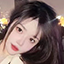

In [ ]:
xloader = get_xloader(config)
data_iter = iter(xloader)
x_fixed, _ = next(data_iter)

from torchvision.transforms import ToPILImage
to_img = ToPILImage()

# display tensor
to_img( denorm( x_fixed[0]  ) )

Loading the trained models from step 200000...
Finished preprocessing the CelebA dataset...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


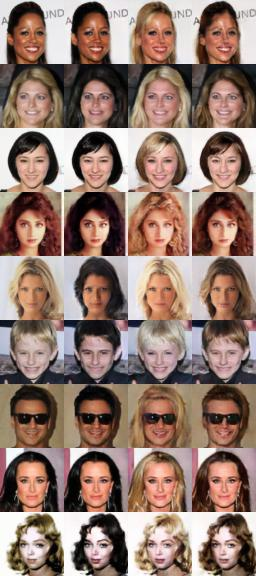

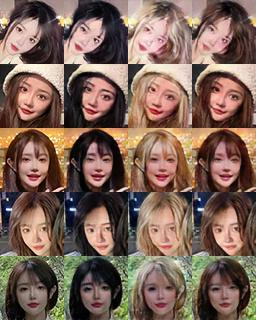

In [ ]:
from IPython.display import Image, display

# Choose the iteration number of the saved model (both G, D should be present)
################################################
##### TODO CODE HERE
##### Load the trained model
##### Also, load the data_loader in test mode

G, D = restore_model(200000, config['model_save_dir'])
G=G.to(config['device'])
D=D.to(config['device'])
data_loader = get_loader(config, mode='test')
xtdata_loader = get_xloader(config)
################################################

from itertools import chain

with torch.no_grad():
    for i, (x_real, c_org) in enumerate(chain(data_loader, xtdata_loader)):

        # Prepare input images and target domain labels.
        x_real = x_real.to(config['device'])
        c_trg_list = create_labels(c_org, config['c_dim'], config['selected_attributes'])

        # Translate images.
        x_fake_list = [x_real]
        for c_trg in c_trg_list:
            x_fake = G(x_real, c_trg)
            x_fake_list.append(x_fake)

        # Save the translated images.
        x_concat = torch.cat(x_fake_list, dim=3)
        result_path = os.path.join( config['result_dir'], '{}-images.jpg'.format(i+1) )
        save_image(denorm(x_concat.data.cpu()), result_path, nrow=1, padding=0)
        display(Image(filename=result_path))

---

# 8. Deep Reinforcement Learning with DQN and DDPG

## Notes before running code

1. If running on Windows, note that some packages may throw warnings or errors - if you encounter this, try the fixes recommended by the error message(s)

2. Additional packages may be required for running locally. This notebook is configured to help you install specific versions of the required packages but if you are concerned about them overwriting exisiting configs for other projects, it is recommended to create a new python environment.

2. When running code, make sure the following files are in your current working directory as they will be needed for some of the RL logging and plotting:
    * `test_policy.py`
    * `logx.py`
    * `plot.py`

In [ ]:
# Prerequisites

# load all the files
!ln -s /content/drive/MyDrive/Common\ Data/CS523/hw5/logx.py logx.py
!ln -s /content/drive/MyDrive/Common\ Data/CS523/hw5/plot.py plot.py
!ln -s /content/drive/MyDrive/Common\ Data/CS523/hw5/test_policy.py test_policy.py


def DPATH(*args: str) -> str:
    from os.path import join
    return join("/content/drive/MyDrive/Users/青椒/CS523/hw5_stuffs", *args)


def check_gpu() -> None:
    result = !nvidia-smi --query-gpu=name --format=csv,noheader
    answer = result[0].strip()
    if len(answer) == 0 or "nvidia-smi" in (answer.lower()):
        print("No gpus are found in this Notebook.")
    else:
        print(f"You are using: {answer}")

check_gpu()

No gpus are found in this Notebook.


## 8.1 Deep Q Learning (30 Points)

#### Key Concepts

<img src="http://ai.bu.edu/DL523/HW5_files/rl_diagram.png" width="360em">

The main components of the RL optimization loop are the agent and the environment. The environment is the world that the agent interacts with. At every step of interaction, the agent sees a (possibly partial) observation of the state of the world, and then decides on an action to take. The environment may change as a response to the agents' actions on it, but may also change on its own.

The agent also perceives a reward signal from the environment, a number that tells it how good or bad the current world state is. The goal of the agent is to maximize its cumulative reward. Reinforcement learning methods are ways that the agent can learn behaviors to achieve its goal.

##### Fully vs. Partially Observable State-spaces

When the agent is able to observe the complete state of the environment, we say that the environment is fully observed. When the agent can only see a partial observation, we say that the environment is partially observed. For the purposes of this homework, we will be dealing with fully observable environments.

##### Discrete vs. Continuous Action-spaces

Different environments allow different kinds of actions. The set of all valid actions in a given environment is often called the action space. Some environments, like old Atari games and Go, have discrete action spaces, where only a finite number of moves are available to the agent. Other environments, like where the agent controls a robot in a physical world, have continuous action spaces. In continuous spaces, actions are real-valued vectors. In this homework, we will consider problems involving both types of action spaces and some simple algorithms for solving them.

##### The RL Problem

The reward function R is critically important in reinforcement learning. It depends on the current state of the world, the action just taken, and the next state of the world:

$$
r_t = R(s_t, a_t, s_{t+1})
$$

although frequently this is simplified to just a dependence on the current state, $r_t = R(s_t)$, or state-action pair $r_t = R(s_t,a_t)$.

The goal of the agent is to maximize the expected cumulative reward over a trajectory, $\tau$, but this actually can mean a few things. We’ll notate all of these cases with $R(\tau)$. The expected return, denoted by $J(\pi)$, is then:

$$
J(\pi) = \mathbb{E}_{\tau\sim \pi}{R(\tau)}
$$

The central optimization problem in RL can then be expressed by

$$
\pi^* = \arg \max_{\pi} J(\pi)
$$

with $\pi^*$ being the optimal policy.

##### The need to approximate value functions

A way to frame the RL problem would be to say that we want actions taken by our agents to maximize the expected achievable value, given a starting state. This can be in the form of a state-value function:

$$
V^{\pi}(s) = \mathbb{E}_{\tau \sim \pi}[R(\tau) | s_0 = s]\text{ for states }s \in S
$$

or a state-action value function (often called a Q-function):

$$
Q^{\pi}(s,a) = \mathbb{E}_{\tau \sim \pi}[R(\tau) | s_0 = s, a_0 = a]\text{ for states }s \in S\text{ and actions }a \in A
$$

Both value representations obey self-consistency equations called Bellman equations, of which the basic idea is that:

    The value of your starting point is the reward you expect to get from being there, plus the value of wherever you land next.

For a given policy, $\pi$, the Bellman equations are:

$$
V^{\pi}(s_t) = \mathbb{E}_{a \sim \pi}[r(s_t,a_t) + \gamma V^\pi(s_{t+1})]
$$

$$
Q^{\pi}(s_t, a_t) = \mathbb{E}_{s}[r(s_t,a_t) + \gamma Q^\pi(s_{t+1},\pi(s_{t+1}))]]
$$

The optimal policy is one that maximizes the expected values $V$ and/or $Q$. This homework will mainly focus on Q-learning techniques, so we are mainly concerned with techniques that consider the latter.

#### Some Setup

Now for some setup to use during the RL parts of this homework.

We will be representing policy and value functions by neural networks. The problems we're working on are fairly simple so we'll be using some simple multi-layer perceptrons (MLPs).

Run the below if you're starting from a clean environment or suspect you may have the wrong versions of packages 

*(Also assumes the packages `ipython` and `jupyter` are already installed since you need them anyway to use this notebook)*

In [ ]:
!pip install "gym[classic_control]==0.17.3"
!pip install "torch==1.10.0"
!pip install numpy scipy matplotlib pandas sympy nose seaborn joblib

     |████████████████████████████████| 154 kB 5.2 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import gym
import time
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import typing

from logx import EpochLogger
from test_policy import load_policy_and_env, run_policy
from plot import plot_data, get_datasets

def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

We also use replay buffers to store trajectories during rollouts so that we can sample from them to aid in training. By storing experiences in replay buffers and sampling from them, we can mitigate catastrophic forgetting (when RL agents forget old experiences).

The Replay Buffer mainly keeps a store of the core elements of the Markov Decision Process (MDP) tuple for each interaction of the agent in the training environment. This includes the observed state (obs), the action taken (act), the reward received (rew), the resultant next state after the action (next_obs) and whether the episode was completed/terminated (done).

This data can then be sampled during optimization to use for batch updates, as we will do in this homework.

In [ ]:
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer
    """
    def __init__(self,
                 obs_dim: int,
                 act_dim: int,
                 size: int,
                 discrete: bool=False):
        self.discrete=discrete
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self,
              obs: torch.Tensor,
              act: int,
              rew: float,
              next_obs: torch.Tensor,
              done: bool):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.int64 if (k=='act' and self.discrete) else torch.float32) for k,v in batch.items()}

### 8.1.1 Deep Q Networks (DQNs)

The main idea behind Q-learning is that if we had a function $Q^*:State×Action \rightarrow \mathbb{R}$, that could tell us what our return would be, if we were to take an action in a given state, then we could easily construct a policy that maximizes our rewards:

$$
\pi^*(s_t) = \operatorname{argmax}_a Q^*(s_t,a)
$$

However, we don’t know everything about the world, so we don’t have access to $Q^*$. But, since neural networks are universal function approximators, we can simply create one and train it to resemble $Q^*$.

For a discrete action space, a Q-network can be used to estimate the Q-values for each possible action, given a state. The policy can then be designed such that:

$$
a^\pi = \operatorname{argmax}_a Q^\pi(s_t,a)
$$

For our training update rule, we’ll use a fact that every $Q$ function for some policy obeys the Bellman equation:

$$
Q^\pi(s_t,a) = r + \gamma Q^\pi(s_{t+1},\pi(s_{t+1}))
$$

The difference between the two sides of the equality is known as the temporal difference error

$$
\delta = Q(s_{t},a) - (r + \gamma \max_a Q(s_{t+1}, a))
$$



In [ ]:
class DQN(nn.Module):
    def __init__(self, obs_space, act_space, hidden_sizes=(64,64), activation=nn.ReLU, output_activation=nn.Identity):
        super().__init__()
        self.obs_space = obs_space
        self.act_space = act_space
        self.hidden_sizes = hidden_sizes

        self.Q = mlp([obs_space.shape[0]] + list(hidden_sizes) + [act_space.n],
                     activation,
                     output_activation)

    def forward(self, obs):
        # Return output from network scaled to action space limits.
        return self.Q(obs)

    def act(self, obs):
        with torch.no_grad():
            return self.Q(obs[None,]).max(1)[1].numpy()[0]

We will use the above simple DQN structure to train a policy to solve OpenAI gym's CartPole problem.

In [ ]:
# Training hyperparameters
steps_per_epoch=4000
epochs=20
gamma=0.99
polyak=0.99  
q_lr=1e-3
batch_size=100
start_steps=10000
update_after=1000 
update_every=50
act_noise=0.1
num_test_episodes=10
max_ep_len=1000
save_freq=1

We will also define a location for the trained models and logs to get saved. By default, it'll be stored in the current working directory but you may change this 

In [ ]:
# Define the directory location to save dqn logs and models
dqn_output_dir = DPATH('dqn')

# Logger setup
logger_kwargs={'output_dir':dqn_output_dir, 'exp_name':'dqn_CartPole'}
logger = EpochLogger(**logger_kwargs)

Logging data to /content/drive/MyDrive/Users/青椒/CS523/hw5_stuffs/dqn/progress.txt


The problem we'll be working on for DQN is the [CartPole](https://gym.openai.com/envs/CartPole-v1/) OpenAI Gym task. 

The agent observes the positions and velocities of the cart and pole and can take one of two discrete options to either move the cart to the left, or the right, to try and keep the pole balanced.

The episode keeps going for up to 200 steps so long as the pole doesn't fall over too much, and the agent fails if the pole falls more than $\pm 12$ degrees from the vertical. 

For every step that it remains 'alive', the agent gets 1 point of reward. The objective is to maximize this reward, which is equivalent to keep the pole balanced for as long as possible.

Additional details for the implementation of this environment can be found via the code [source](https://github.com/openai/gym/blob/4ede9280f9c477f1ca09929d10cdc1e1ba1129f1/gym/envs/classic_control/cartpole.py).

A random agent would quickly fail to balance the pole, as below (the frame hitches are due to the agent failing and the episode being reset)

<img src="http://ai.bu.edu/DL523/HW5_files/cartpole_random_demo.gif" width="360em">

But a trained agent can successfully solve this problem (using solution code for this HW).

<img src="http://ai.bu.edu/DL523/HW5_files/cartpole_demo.gif" width="360em">

In [ ]:
# Environment Definition
env_fn = lambda :gym.make('CartPole-v0')
env, test_env = env_fn(), env_fn()
obs_dim = env.observation_space.shape
act_dim = env.action_space.shape

# Seeding
seed=0
torch.manual_seed(seed)
np.random.seed(seed)
env.seed(seed)
test_env.seed(seed)

# Experience buffer
replay_size=int(1e6) 
replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size, discrete=True)

# Create DQN module
Qnet = DQN(env.observation_space, env.action_space)

To stabilize training we also use a 'target' Q-network which is held relatively constant and is periodically updated with weights from the DQN being trained.

In [ ]:
# Create target network
Qtarg = deepcopy(Qnet)

# Freeze target networks with respect to optimizers (only update via polyak averaging)
for p in Qtarg.parameters():
    p.requires_grad = False

# Set up model saving
logger.setup_pytorch_saver(Qnet)

We can next initialize some helper functions

In [ ]:
# Helper Functions
def get_action(o, eps_thresh):
    a = Qnet.act(torch.as_tensor(o, dtype=torch.float32))
    if np.random.rand() < eps_thresh:
        a = env.action_space.sample()
    return a

def test_agent():
    for j in range(num_test_episodes):
        o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
        while not(d or (ep_len == max_ep_len)):
            # Take deterministic actions at test time (noise_scale=0)
            o, r, d, _ = test_env.step(get_action(o, 0))
            ep_ret += r
            ep_len += 1
        logger.store(TestEpRet=ep_ret, TestEpLen=ep_len)

### 8.1.2 Define DQN Q-learning Loss [10 points]

For a sampled batch of data from the replay buffer consisting of sets of observations `o`, corresponding actions taken `a`, achieved reward `r`, resultant observations `o2`, and a flag indicating if the recorded step solved the problem or ended the episode `d`, we compute the DQN loss in 4 main steps:

- [x] Compute the Q-network output for `o` and extract Q-values for specific actions taken, $a_t$: $Q(s_t,a_t)$
    - Actions, $a_t \in [0,n-1]$, are indices into a discrete action space with $n$ possible actions.
- [x] Next, compute the Bellman backup: $b = r + \gamma \max_{a'} Q_{targ}(s_{t+1},a')$
    - remember that $\gamma = 0$ if $d=1$ and that you don't need to track gradients through the target Q-network.
- [x] Compute the Bellman error:

$$
e = Q(s,a) - b
$$

- [x] Finally compute the Q-loss:

$$
l_Q = \frac{1}{N} || e ||_2
$$





In [ ]:
import pdb

# Set up function for computing DQN Q-loss
def compute_loss_q(data: typing.Dict[str, torch.Tensor]):
    # Batch data sample:

    # O is the observation, a sets of Observation, each line a status
    # A is the action
    # R is the reward
    # o2 is the resultant observations
    # d is the done flag, which is False if the episode is not over, and True if it is over
    o, a, r, o2, d = data['obs'], data['act'], data['rew'], data['obs2'], data['done']

    """ STUDENT CODE GOES HERE """
    # Compute q values for observations as appropriate
    q = torch.sum(Qnet(o) * F.one_hot(a), dim=1).view(-1, 1)

    with torch.no_grad():
        qtarg_o = Qtarg(o2)
        # there's values and indices in torch.max's result.
        # here we only need values.
        q_target = torch.max(qtarg_o, dim=1).values
        backup = r + (1 - d) * gamma * q_target
    
    loss_q = F.mse_loss(torch.squeeze(q), backup).mean()
    """ STUDENT CODE ENDS """

    # Useful info for logging
    loss_info = dict(QVals=q.detach().numpy())

    return loss_q, loss_info

# Set up optimizers for policy and q-function
q_optimizer = Adam(Qnet.Q.parameters(), lr=q_lr)

def update(data):
    # First run one gradient descent step for Q.
    q_optimizer.zero_grad()
    loss_q, loss_info = compute_loss_q(data)
    loss_q.backward()
    q_optimizer.step()

    # Record things
    logger.store(LossQ=loss_q.item(), **loss_info)

    # Finally, update target networks by polyak averaging.
    with torch.no_grad():
        for p, p_targ in zip(Qnet.parameters(), Qtarg.parameters()):
            # NB: We use an in-place operations "mul_", "add_" to update target
            # params, as opposed to "mul" and "add", which would make new tensors.
            p_targ.data.mul_(polyak)
            p_targ.data.add_((1 - polyak) * p.data)

Now we run training.

While running the code, pay attention the following logged information to determine if things are progressing well:

1. For the first few thousand steps, the agents act randomly so you'll likely see low rewards that don't improve until more than `start_steps` steps have elapsed.
2. Average Episode and Test Episode returns should generally be increasing (up to 200 which is the max for the CartPole problem)
3. Despite optimizing the Q-value loss, the fact that we're having the network learn an arbitrary value means that we may never hit a loss of 0 - the loss should stabilize after some time though (feel free to experiment with more epochs of training)

In [ ]:
# Prepare for interaction with environment
total_steps = steps_per_epoch * epochs
o, ep_ret, ep_len = env.reset(), 0, 0

# Main loop: collect experience in env and update/log each epoch
for t in range(total_steps):
    
    # Until start_steps have elapsed, randomly sample actions
    # from a uniform distribution for better exploration. Afterwards, 
    # use the learned policy (with some noise, via act_noise). 
    if t > start_steps: 
        a = get_action(o, act_noise)
    else:
        a = env.action_space.sample()

    # Step the env
    o2, r, d, _ = env.step(a)
    ep_ret += r
    ep_len += 1

    # Ignore the "done" signal if it comes from hitting the time
    # horizon (that is, when it's an artificial terminal signal
    # that isn't based on the agent's state)
    d = False if ep_len==max_ep_len else d

    # Store experience to replay buffer
    replay_buffer.store(o, a, r, o2, d)

    # Super critical, easy to overlook step: make sure to update 
    # most recent observation!
    o = o2

    # End of trajectory handling
    if d or (ep_len == max_ep_len):
        logger.store(EpRet=ep_ret, EpLen=ep_len)
        o, ep_ret, ep_len = env.reset(), 0, 0

    # Update handling
    if t >= update_after and t % update_every == 0:
        for _ in range(update_every):
            batch = replay_buffer.sample_batch(batch_size)
            update(data=batch)

    # End of epoch handling
    if (t+1) % steps_per_epoch == 0:
        epoch = (t+1) // steps_per_epoch

        # Save model
        if (epoch % save_freq == 0) or (epoch == epochs):
            logger.save_state({'env': env}, None)

        # Test the performance of the deterministic version of the agent.
        test_agent()

        # Log info about epoch
        logger.log_tabular('Epoch', epoch)
        logger.log_tabular('EpRet', with_min_and_max=True)
        logger.log_tabular('TestEpRet', with_min_and_max=True)
        logger.log_tabular('EpLen', average_only=True)
        logger.log_tabular('TestEpLen', average_only=True)
        logger.log_tabular('TotalEnvInteracts', t)
        logger.log_tabular('QVals', with_min_and_max=True)
        logger.log_tabular('LossQ', average_only=True)
        logger.dump_tabular()

env.close()
test_env.close()

---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |            22.1 |
|          StdEpRet |            11.5 |
|          MaxEpRet |              66 |
|          MinEpRet |               8 |
|  AverageTestEpRet |             176 |
|      StdTestEpRet |            20.6 |
|      MaxTestEpRet |             200 |
|      MinTestEpRet |             141 |
|             EpLen |            22.1 |
|         TestEpLen |             176 |
| TotalEnvInteracts |           4e+03 |
|      AverageQVals |            12.5 |
|          StdQVals |            8.59 |
|          MaxQVals |            33.1 |
|          MinQVals |            -3.7 |
|             LossQ |           0.487 |
---------------------------------------
---------------------------------------
|             Epoch |               2 |
|      AverageEpRet |            22.8 |
|          StdEpRet |            11.3 |
|          MaxEpRet |              67 |
|          MinEpRet |               9 |


No file named config.json


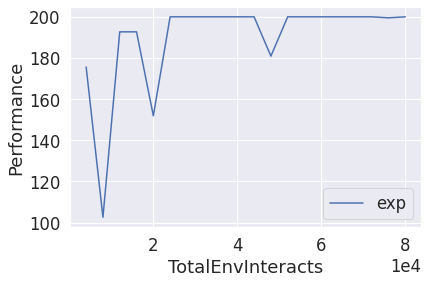

In [ ]:
plt.figure()
data = get_datasets(dqn_output_dir)
plot_data(data, xaxis='TotalEnvInteracts', value='Performance', smooth=1)

We can also run the trained agents as below (set render=True to visualize - note that additional settings may be required to view on Colab or on a remote server)

Note: In order for this code to work, the DQN model definition should be in scope.

The solved CartPole controller would typically have EpRet close to 200 (where 200 is the max) - If it doesn't quite plateau there, try rerunning the training (we're only training it for a short while with only sligtly tuned hyperparameters so it's possible that it may not stably plateau)

In [ ]:
playback_env, get_action = load_policy_and_env(dqn_output_dir, 'last', True)
run_policy(playback_env, get_action, num_episodes=10, render=False)
playback_env.close()



Loading from /content/drive/MyDrive/Users/青椒/CS523/hw5_stuffs/dqn/pyt_save/model.pt.


Logging data to /tmp/experiments/1650459421/progress.txt
Episode 0 	 EpRet 200.000 	 EpLen 200
Episode 1 	 EpRet 200.000 	 EpLen 200
Episode 2 	 EpRet 200.000 	 EpLen 200
Episode 3 	 EpRet 200.000 	 EpLen 200
Episode 4 	 EpRet 200.000 	 EpLen 200
Episode 5 	 EpRet 200.000 	 EpLen 200
Episode 6 	 EpRet 200.000 	 EpLen 200
Episode 7 	 EpRet 200.000 	 EpLen 200
Episode 8 	 EpRet 200.000 	 EpLen 200
Episode 9 	 EpRet 200.000 	 EpLen 200
-------------------------------------
|    AverageEpRet |             200 |
|        StdEpRet |               0 |
|        MaxEpRet |             200 |
|        MinEpRet |             200 |
|           EpLen |             200 |
-------------------------------------


## 8.2 Deep Deterministic Policy Gradient (DDPG) - An Actor-Critic Algorithm

Next, we'll implement a Q-learning algorithm for continuous control using a popular actor-critic algortihm, DDPG.

One of the main traits of actor-critic algortihsm is that unlike with DQNs:
1. The policy network and value estimation network are separated into two separate, distinct functions
2. They can be used to solve continuous controls problems, unlike DQNs which are limited to discrete action spaces.

The Q-learning side of training the critic works similarly to DQNs, except that Q-networks now take states and actions both as inputs to estimate a Q-value, as opposed to simultaneously estimating Q values over all possible discrete actions.

The Policy learning in DDPG is fairly simple. We want to learn a deterministic policy $\pi_{\theta}(s)$ (parameterized by $\theta$) which gives the action that maximizes $Q_{\phi}(s,a)$, a Q-value critic parameterized by $\phi$. Because the action space is continuous, and we assume the Q-function is differentiable with respect to action, we can just perform gradient ascent (with respect to policy parameters only) to solve

$\max_{\theta} \mathbb{E}_{s \sim {\mathcal D}} [ Q_{\phi}(s, \pi_{\theta}(s)) ]$

Note that the Q-function parameters are treated as constants here.

In [ ]:
class MLPActor(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit):
        super().__init__()
        pi_sizes = [obs_dim] + list(hidden_sizes) + [act_dim]
        self.pi = mlp(pi_sizes, activation, nn.Tanh)
        self.act_limit = act_limit

    def forward(self, obs):
        # Return output from network scaled to action space limits.
        return self.act_limit * self.pi(obs)

class MLPQFunction(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs, act):
        q = self.q(torch.cat([obs, act], dim=-1))
        return torch.squeeze(q, -1) # Critical to ensure q has right shape.

class MLPActorCritic(nn.Module):

    def __init__(self, observation_space, action_space, hidden_sizes=(256,256),
                 activation=nn.ReLU):
        super().__init__()

        obs_dim = observation_space.shape[0]
        act_dim = action_space.shape[0]
        act_limit = action_space.high[0]

        # build policy and value functions
        self.pi = MLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit)
        self.q = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)

    def act(self, obs):
        with torch.no_grad():
            return self.pi(obs).numpy()

For this part of the homework, we'll test DDPG on a simple inverted pendulum problem.

As before, in addition to the main trained networks, we build additional target networks to stabilize training.

We will also set the logging directory to be a part of the current working directory but feel free to change that as necessary

In [ ]:
# Define the directory location to save DDPG logs and models
ddpg_output_dir = DPATH('ddpg')

# Logger setup
logger_kwargs={'output_dir': ddpg_output_dir, 'exp_name':'ddpg_pendulum'}
logger = EpochLogger(**logger_kwargs)

Logging data to /content/drive/MyDrive/Users/青椒/CS523/hw5_stuffs/ddpg/progress.txt


The problem we'll be working on for DDPG is the (inverted) [Pendulum](https://gym.openai.com/envs/CartPole-v1/) OpenAI Gym task. 

The agent observes the angular position and velocity of the pendulum and can apply a continuous-valued torque to try and balance the pendulum.

The episode keeps going for up to 200 steps and every step the agent gets reward mainly proportional to how far off it is from balancing the inverted pendulum, with smaller reward components related to how fast the pendulum is moving and how much torque is being applied. The objective is to maximize this reward, which is equivalent to balancing the inverted pendulum quickly and for as long as possible.

Additional details for the implementation of this environment can be found via the code [source](https://github.com/openai/gym/blob/4ede9280f9c477f1ca09929d10cdc1e1ba1129f1/gym/envs/classic_control/pendulum.py).

A random agent (or a poorly trained one) is unlikely to successfully balance the pendulum, as seen below:

<img src="http://ai.bu.edu/DL523/HW5_files/pendulum_random_demo.gif" width="360em">

But a well trained agent can successfully solve this problem (using solution code for this HW).

<img src="http://ai.bu.edu/DL523/HW5_files/pendulum_demo.gif" width="360em">

In [ ]:
# Training hyperparameters
steps_per_epoch=4000
epochs=20
gamma=0.99
polyak=0.995
batch_size=100
start_steps=10000
update_after=1000 
update_every=50
act_noise=0.1
num_test_episodes=10
max_ep_len=1000
save_freq=1

pi_lr=1e-3 
q_lr=1e-3

# Environment Definition
env_fn = lambda :gym.make('Pendulum-v0')
env, test_env = env_fn(), env_fn()
obs_dim = env.observation_space.shape
act_dim = env.action_space.shape[0]
# Action limit for clamping: critically, assumes all dimensions share the same bound!
act_limit = env.action_space.high[0]

# Seeding
seed=0
torch.manual_seed(seed)
np.random.seed(seed)
env.seed(seed)
test_env.seed(seed)

# Experience buffer
replay_size=int(1e6) 
replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size)

# Create actor-critic module and target networks
ac = MLPActorCritic(env.observation_space, env.action_space)
ac_targ = deepcopy(ac)

# Freeze target networks with respect to optimizers (only update via polyak averaging)
for p in ac_targ.parameters():
    p.requires_grad = False

# Set up model saving
logger.setup_pytorch_saver(ac)

We can next initialize modified helper functions - similar to the ones before but setup for the different architecture

In [ ]:
# Helper Functions
def get_action(o, noise_scale):
    a = ac.act(torch.as_tensor(o, dtype=torch.float32))
    a += noise_scale * np.random.randn(act_dim)
    return np.clip(a, -act_limit, act_limit)

def test_agent():
    for j in range(num_test_episodes):
        o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
        while not(d or (ep_len == max_ep_len)):
            # Take deterministic actions at test time (noise_scale=0)
            o, r, d, _ = test_env.step(get_action(o, 0))
            ep_ret += r
            ep_len += 1
        logger.store(TestEpRet=ep_ret, TestEpLen=ep_len)

### Define DDPG Q-learning Loss [10 points]

This part is similar to DQN, except you'll need to modify your code to make use of the actor-critic separation appropriately

In [ ]:
# Set up function for computing DDPG Q-loss
def compute_loss_q(data):
    o, a, r, o2, d = data['obs'], data['act'], data['rew'], data['obs2'], data['done']

    """ STUDENT CODE GOES HERE """
    q = ac.q(o, a)

    with torch.no_grad():
        # first we compute the given act for using act_target's Policy
        a2 = ac_targ.pi(o2)
        ac_targ_q = ac_targ.q(o2, a2)
        backup = r + (1 - d) * gamma * ac_targ_q

    loss_q = F.mse_loss(q, backup).mean()
    """ STUDENT CODE ENDS """

    # Useful info for logging
    loss_info = dict(QVals=q.detach().numpy())

    return loss_q, loss_info

### Define DDPG Policy $\pi$ Loss [10 points]

The policy optimization loss is simple to compute. It can be computed as: $L_\pi = -Q(o,\pi(o))$

In [ ]:
# Set up function for computing DDPG pi loss
def compute_loss_pi(data):
    o = data['obs']
    """ STUDENT CODE GOES HERE """
    pi_loss = -ac.q(o, ac.pi(o)).mean()
    """ STUDENT CODE ENDS """
    return pi_loss

The overall updates are handled similarly to DQN before

In [ ]:
class model_no_grad():
    def __init__(self, model: nn.Module):
        self.model = model

    def __enter__(self):
        for p in self.model.parameters():
            p.requires_grad = False

    def __exit__(self, exc_type: any, exc_value: any, traceback: any) -> None:
        for p in self.model.parameters():
            p.requires_grad = True

In [ ]:
# Set up optimizers for policy and q-function
pi_optimizer = Adam(ac.pi.parameters(), lr=pi_lr)
q_optimizer = Adam(ac.q.parameters(), lr=q_lr)

# Set up model saving
logger.setup_pytorch_saver(ac)

def update(data):
    # First run one gradient descent step for Q.
    q_optimizer.zero_grad()
    loss_q, loss_info = compute_loss_q(data)
    loss_q.backward()
    q_optimizer.step()

    # Freeze Q-network so you don't waste computational effort 
    # computing gradients for it during the policy learning step.
    # after exit,  Unfreeze Q-network so you can optimize it at next DDPG step.
    with model_no_grad(ac.q):
        # Next run one gradient descent step for pi.
        pi_optimizer.zero_grad()
        loss_pi = compute_loss_pi(data)
        loss_pi.backward()
        pi_optimizer.step()

    # Record things
    logger.store(LossQ=loss_q.item(), LossPi=loss_pi.item(), **loss_info)

    # Finally, update target networks by polyak averaging.
    with torch.no_grad():
        for p, p_targ in zip(ac.parameters(), ac_targ.parameters()):
            # NB: We use an in-place operations "mul_", "add_" to update target
            # params, as opposed to "mul" and "add", which would make new tensors.
            p_targ.data.mul_(polyak)
            p_targ.data.add_((1 - polyak) * p.data)

Now we run training.

While running the code, pay attention the following logged information to determine if things are progressing well:

1. For the first few thousand steps, the agents act randomly so you'll likely see low rewards that don't improve until more than `start_steps` steps have elapsed.
2. Average Episode and Test Episode returns should generally be increasing from a very negative value to an average of > -150 for a successful agent.
3. The policy loss (LossPi in the log as computed in `compute_loss_pi`) should decrease as the agent gets beter as this reflects how good the policy is at choosing 'good' actions.
4. As before, we also expect the Q-value loss to decrease as the agent gets better at estimating Q-values.

Unlike DQNs, where everything rides on a good estimation of Q-values, the policy behavior for actor-critic learning relies on critics learning useful Q-value estimations and actors learning useful policies based on the estimated Q-values. 
The separation offers increased flexibility and often improved representational power (in addition to being able to support continuous-valued actions) but does add extra knobs to tune.

In [ ]:
# Prepare for interaction with environment
total_steps = steps_per_epoch * epochs
o, ep_ret, ep_len = env.reset(), 0, 0

# Main loop: collect experience in env and update/log each epoch
for t in range(total_steps):
    
    # Until start_steps have elapsed, randomly sample actions
    # from a uniform distribution for better exploration. Afterwards, 
    # use the learned policy (with some noise, via act_noise). 
    if t > start_steps:
        a = get_action(o, act_noise)
    else:
        a = env.action_space.sample()

    # Step the env
    o2, r, d, _ = env.step(a)
    ep_ret += r
    ep_len += 1

    # Ignore the "done" signal if it comes from hitting the time
    # horizon (that is, when it's an artificial terminal signal
    # that isn't based on the agent's state)
    d = False if ep_len==max_ep_len else d

    # Store experience to replay buffer
    replay_buffer.store(o, a, r, o2, d)

    # Super critical, easy to overlook step: make sure to update 
    # most recent observation!
    o = o2

    # End of trajectory handling
    if d or (ep_len == max_ep_len):
        logger.store(EpRet=ep_ret, EpLen=ep_len)
        o, ep_ret, ep_len = env.reset(), 0, 0

    # Update handling
    if t >= update_after and t % update_every == 0:
        for _ in range(update_every):
            batch = replay_buffer.sample_batch(batch_size)
            update(data=batch)

    # End of epoch handling
    if (t+1) % steps_per_epoch == 0:
        epoch = (t+1) // steps_per_epoch

        # Save model
        if (epoch % save_freq == 0) or (epoch == epochs):
            logger.save_state({'env': env}, None)

        # Test the performance of the deterministic version of the agent.
        test_agent()

        # Log info about epoch
        logger.log_tabular('Epoch', epoch)
        logger.log_tabular('EpRet', with_min_and_max=True)
        logger.log_tabular('TestEpRet', with_min_and_max=True)
        logger.log_tabular('EpLen', average_only=True)
        logger.log_tabular('TestEpLen', average_only=True)
        logger.log_tabular('TotalEnvInteracts', t)
        logger.log_tabular('QVals', with_min_and_max=True)
        logger.log_tabular('LossPi', average_only=True)
        logger.log_tabular('LossQ', average_only=True)
        logger.dump_tabular()

env.close()
test_env.close()

---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |       -1.23e+03 |
|          StdEpRet |             338 |
|          MaxEpRet |            -759 |
|          MinEpRet |       -1.75e+03 |
|  AverageTestEpRet |            -293 |
|      StdTestEpRet |             220 |
|      MaxTestEpRet |          -0.441 |
|      MinTestEpRet |            -728 |
|             EpLen |             200 |
|         TestEpLen |             200 |
| TotalEnvInteracts |           4e+03 |
|      AverageQVals |           -39.5 |
|          StdQVals |            28.7 |
|          MaxQVals |            1.86 |
|          MinQVals |            -113 |
|            LossPi |            38.4 |
|             LossQ |             9.3 |
---------------------------------------
---------------------------------------
|             Epoch |               2 |
|      AverageEpRet |       -1.29e+03 |
|          StdEpRet |             308 |
|          MaxEpRet |            -849 |


No file named config.json


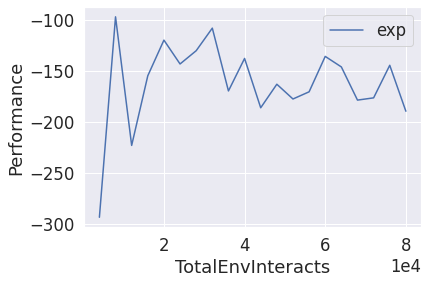

In [ ]:
plt.figure()
data = get_datasets(ddpg_output_dir)
plot_data(data, xaxis='TotalEnvInteracts', value='Performance', smooth=1)

We can also run the trained agents as below (set render=True to visualize - note that additional settings may be required to view on Colab or on a remote server)

Note: In order for this code to work, the MLPActorCritic model definition (and dependencies) should be in scope.

A solved pendulum controller would typically have EpRet > -150.

In [ ]:
playback_env, get_action = load_policy_and_env(ddpg_output_dir, 'last', True)
run_policy(playback_env, get_action, num_episodes=10, render=False)
playback_env.close()



Loading from /content/drive/MyDrive/Users/青椒/CS523/hw5_stuffs/ddpg/pyt_save/model.pt.


Logging data to /tmp/experiments/1650469895/progress.txt
Episode 0 	 EpRet -1.371 	 EpLen 200
Episode 1 	 EpRet -116.307 	 EpLen 200
Episode 2 	 EpRet -117.677 	 EpLen 200
Episode 3 	 EpRet -125.480 	 EpLen 200
Episode 4 	 EpRet -118.403 	 EpLen 200
Episode 5 	 EpRet -120.313 	 EpLen 200
Episode 6 	 EpRet -261.474 	 EpLen 200
Episode 7 	 EpRet -124.682 	 EpLen 200
Episode 8 	 EpRet -121.751 	 EpLen 200
Episode 9 	 EpRet -126.205 	 EpLen 200
-------------------------------------
|    AverageEpRet |            -123 |
|        StdEpRet |            58.4 |
|        MaxEpRet |           -1.37 |
|        MinEpRet |            -261 |
|           EpLen |             200 |
-------------------------------------


# 9. Sequence to Sequence Modelling with nn.Transformer and Torch Text (20 points)

You will implement a part of transformer. This question aims to let you to get familiar with the transformer architecture purposed in the paper [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf). This question is modified from the original pytorch tutorial [here](https://pytorch.org/tutorials/beginner/transformer_tutorial.html?highlight=transformer), you can refer it when you fill out the code. The general architecture of trasnsformer is shown in the figure below:

<img src="http://ai.bu.edu/DL523/HW5_files/transformer_architecture.jpg" width="360em">

This question requires you to implement a sequence to sequence model by encoder, which is the left part of the figure. You will use integrated layers in pytorch.

The transformer model has been proved to be superior in quality for many sequence-to-sequence
problems while being more parallelizable. The ``nn.Transformer`` module
relies entirely on an attention mechanism (another module recently
implemented as `nn.MultiheadAttention`) to draw global dependencies
between input and output. The ``nn.Transformer`` module is now highly
modularized such that a single component (like [`nn.TransformerEncoder `](<https://pytorch.org/docs/master/nn.html?highlight=nn%20transformerencoder#torch.nn.TransformerEncoder>)
in this tutorial) can be easily adapted/composed.

In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 9.1 Define the model 
In this question, we train ``nn.TransformerEncoder`` model on a
language modeling task. The language modeling task is to assign a
probability for the likelihood of a given word (or a sequence of words)
to follow a sequence of words. A sequence of tokens are passed to the embedding
layer first, followed by a positional encoding layer to account for the order
of the word (see the next paragraph for more details). The
``nn.TransformerEncoder`` consists of multiple layers of
``nn.TransformerEncoderLayer`` . Along with the input sequence, a square
attention mask is required because the self-attention layers in
``nn.TransformerEncoder`` are only allowed to attend the earlier positions in
the sequence. For the language modeling task, any tokens on the future
positions should be masked. To have the actual words, the output
of ``nn.TransformerEncoder`` model is sent to the final Linear
layer, which is followed by a log-Softmax function. We will see how to implement the ``PositionalEncoding`` in the later question. 

<img src="http://ai.bu.edu/DL523/HW5_files/encoder.png" width="em">

In the following model, we only train a encoder model, which is the left part of the figure. Then we concatenate a Linear model `self.decoder` to replace the right part of the model.

**TO AVOID ISSUES WITH PACKAGE IMPORTS, IT MIGHT BE WORTH RESTARTING THE NOTEBOOK KERNEL**

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import typing


class TransformerModel(nn.Module):
    def __init__(self,
                 token_nums: int,
                 input_embedding_dim: int,
                 multi_head_nums: int,
                 hidden_nums: int,
                 layer_nums: int,
                 dropout: float = 0.5):
        """This is a transformer encoder model, the input arguments are as follows:

        :param token_nums dimension of tokens
        :param input_embedding_dim dimension of input embeddings
        :param multi_head_nums the number of heads in the Multi-Head Attention model
        :param hidden_nums dimension of the hidden encoding between two layers of TransformerEncoderLayer
        :param layer_nums number of TransformerEncoderLayer layers
        """
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer

        self.model_type = 'Transformer'

        self.embedding_encoder = nn.Embedding(token_nums, input_embedding_dim)
        self.input_embedding_dim = input_embedding_dim

        self.positional_encoder = PositionalEncoding(input_embedding_dim, dropout)
        encoder_layers = TransformerEncoderLayer(input_embedding_dim, multi_head_nums, hidden_nums, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, layer_nums)
        self.linear_decoder = nn.Linear(input_embedding_dim, token_nums)

        self.init_weights()

    def generate_square_subsequent_mask(self, size: int) -> torch.Tensor:
        """
        Generate a square mask for the sequence.
        The masked positions are filled with float('-inf').
        :param size: the size of the mask
        :return: A series of masked vectors.
        """

        # actually returns a matrix of size * size, with -inf in the first row
        # except for the first element, which is 0. Then on the next lines, more
        # and more elements that are not -inf are added,
        # until the last line, when there are no more -inf elements
        #
        # tensor([[0., -inf, -inf, -inf, -inf],
        #         [0.,   0., -inf, -inf, -inf],
        #         [0.,   0.,   0., -inf, -inf],
        #         [0.,   0.,   0.,   0., -inf],
        #         [0.,   0.,   0.,   0.,   0.]])

        mask = torch.triu(torch.ones(size, size) * float('-inf') , diagonal=1)
        return mask

    def init_weights(self):
        init_range = 0.1
        self.embedding_encoder.weight.data.uniform_(-init_range, init_range)
        self.linear_decoder.bias.data.zero_()
        self.linear_decoder.weight.data.uniform_(-init_range, init_range)

    def forward(self,
                src: torch.Tensor,
                src_mask: torch.Tensor) -> torch.Tensor:
        # 1. We will convert tokens into embeddings
        src = self.embedding_encoder(src) * math.sqrt(self.input_embedding_dim)

        # 2. We will add positional encoding
        src = self.positional_encoder(src)

        # 3. We will apply the TransformerEncoder
        output = self.transformer_encoder(src, src_mask)

        # 4. We will apply a linear layer to the output
        output = self.linear_decoder(output)
        
        return output


## 9.2 Positional Encoding


### 9.2.1 Fill the code block
``PositionalEncoding`` module injects some information about the
relative or absolute position of the tokens in the sequence. The
positional encodings have the same dimension as the embeddings so that
the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
different frequencies.


In [ ]:
class PositionalEncoding(nn.Module):
    """
    This class implements the positional encoding as described in "Attention is all you need"

    `PositionalEncoding` module injects some information about the relative or absolute position of the tokens in the
    sequence.

    The positional encodings have the same dimension as the embeddings so that the two can be summed. Here,
    we use sine and cosine functions of different frequencies.
    """

    def __init__(self,
                 embedding_dim: int,
                 dropout: int =0.1,
                 max_length: int = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-math.log(10000.0) / embedding_dim))
        pe = torch.zeros(max_length, 1, embedding_dim)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """YOUR CODE HERE"""
        x = x + self.pe[:x.size(0), :]
        output = self.dropout(x)
        """YOUR CODE ENDS"""
        return output


### 9.2.2 Why do we need this positional encoding in the transformer architecture?

Positional encoding provides a solution that helps to account for the order of words in the input sequence. It will introduce a new vector values to the embedding, which contains information about the meaningful distances between word's positions and distances. This can helps the model to recover the position of each words during output stage.

## 9.3 Running the model



### 9.3.1 Run the code to get desired performance.
The training process uses Wikitext-2 dataset from ``torchtext``. The
vocab object is built based on the train dataset and is used to numericalize
tokens into tensors. Starting from sequential data, the ``batchify()``
function arranges the dataset into columns, trimming off any tokens remaining
after the data has been divided into batches of size ``batch_size``.
For instance, with the alphabet as the sequence (total length of 26)
and a batch size of 4, we would divide the alphabet into 4 sequences of
length 6:

$$
\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}
$$

These columns are treated as independent by the model, which means that
the dependence of ``G`` and ``F`` can not be learned, but allows more
efficient batch processing.


**Note**, we're using torchtext v 0.11.0

You *may* need to run the following code block below if running locally if errors are thrown about missing packages or components (though check the rest first before going through this)

In [ ]:
!pip install "torchtext==0.11"
!pip install "spacy>=2.2.4,<=3.2.4"
!python -m spacy download en_core_web_sm

In [ ]:
import torchtext
from torchtext.legacy import data
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader


TEXT = torchtext.legacy.data.Field(tokenize=get_tokenizer("spacy"),
                                   init_token='<sos>',
                                   eos_token='<eos>',
                                   lower=True)

train_txt, val_txt, test_txt = torchtext.legacy.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def batchify(data: Dataset,
             batch_size: int) -> torch.Tensor:
    data = TEXT.numericalize([data.examples[0].text])
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // batch_size
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * batch_size)
    # Evenly divide the data across the bsz batches.
    data = data.view(batch_size, -1).t().contiguous()
    return data.to(device)


batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

The ``get_batch()`` function generates the input and target sequence for
the transformer model. It subdivides the source data into chunks of
length ``bptt``. For the language modeling task, the model needs the
following words as ``Target``. For example, with a ``bptt`` value of 2,
we’d get the following two Variables for ``i`` = 0:

<img src="http://ai.bu.edu/DL523/HW5_files/transformer_input_target1.png" width="em">
<!-- ![](transformer_input_target.png) -->


It should be noted that the chunks are along dimension 0, consistent
with the ``S`` dimension in the Transformer model. The batch dimension
``N`` is along dimension 1.


In [ ]:
# The get_batch() function will use the value bptt to subdivide the data into chunks of length bptt.
# For example, if bptt is 2, we get the following two variables with i = 0.
bptt: int = 35


def get_batch(source: torch.Tensor, i: int) -> typing.Tuple[torch.Tensor, torch.Tensor]:
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i + seq_len]
    target = source[i + 1:i + 1 + seq_len].reshape(-1)
    return data, target


ntokens = len(TEXT.vocab.stoi)  # the size of vocabulary
emsize = 200  # embedding dimension
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0.2  # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time


def train() -> None:
    model.train()  # Turn on the train mode
    total_loss = 0.0
    log_interval = 10
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    num_batches = len(train_data) // bptt

    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    print("in training loop")
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        batch_size = data.size(0)

        if batch_size != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data, src_mask)

        # begin to calculate the loss
        loss = criterion(output.view(-1, ntokens), targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            # because the learning rate is changing,
            # we need to fetch the latest learning rate.
            learningRate = scheduler.get_last_lr()[0]
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {learningRate:02.2f} | ms/batch {elapsed * 1000 / log_interval:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {math.exp(cur_loss):8.2f}')
            total_loss = 0
            start_time = time.time()


def evaluate(model: nn.Module, eval_data: torch.Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            batch_size = data.size(0)
            if batch_size != bptt:
                src_mask = src_mask[:batch_size, :batch_size]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += batch_size * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

Running the code block below. You will get around 220 ppl on training at the end of epoch 1.

In [ ]:
best_val_loss = float("inf")
epochs = 1 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    print("starting")
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    scheduler.step()

starting
in training loop
| epoch   1 |    10/ 3195 batches | lr 5.00 | ms/batch 32.10 | loss 10.90 | ppl 54110.16
| epoch   1 |    20/ 3195 batches | lr 5.00 | ms/batch  7.60 | loss  8.65 | ppl  5702.83
| epoch   1 |    30/ 3195 batches | lr 5.00 | ms/batch  7.43 | loss  8.67 | ppl  5827.13
| epoch   1 |    40/ 3195 batches | lr 5.00 | ms/batch  7.55 | loss  7.98 | ppl  2919.76
| epoch   1 |    50/ 3195 batches | lr 5.00 | ms/batch  8.22 | loss  7.60 | ppl  1990.59
| epoch   1 |    60/ 3195 batches | lr 5.00 | ms/batch  7.45 | loss  7.47 | ppl  1752.93
| epoch   1 |    70/ 3195 batches | lr 5.00 | ms/batch  7.34 | loss  7.21 | ppl  1355.31
| epoch   1 |    80/ 3195 batches | lr 5.00 | ms/batch  7.29 | loss  7.18 | ppl  1315.49
| epoch   1 |    90/ 3195 batches | lr 5.00 | ms/batch  7.21 | loss  6.93 | ppl  1024.09
| epoch   1 |   100/ 3195 batches | lr 5.00 | ms/batch  7.57 | loss  7.04 | ppl  1144.61
| epoch   1 |   110/ 3195 batches | lr 5.00 | ms/batch  7.03 | loss  6.80 | ppl   89

### 9.3.2 Why do we need to use `torch.nn.utils.clip_grad_norm_` in training?

Set a threshold for gradient clipping, and if the gradient exceeds this threshold when updating the gradient, it will be limited to this range to prevent the gradient from exploding.